In [1]:
# go through all modules and delete unnecessary code
# optimise used code in modules
# check whether figures are exactly reproduced by the saved results
# check whether everything runs
# check whether a simple RF experiment can reproduce paper results
# have all figures saved in figures
# design readme file and embedd figures
# link to the paper in readme file

# Import Packages

In [1]:
# import general packages and set general options

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem

import warnings
warnings.filterwarnings("ignore")

In [2]:
# import custom code written for this project

from modules import *

In [3]:
# import and check funtionality of pytorch

import torch

print("Pytorch version = ", torch.__version__)
print("CUDA version = ", torch.version.cuda)
print("CUDA available = ", torch.cuda.is_available())
print("Random Pytorch test tensor = ", torch.rand(1))

Pytorch version =  1.10.2+cu113
CUDA version =  11.3
CUDA available =  False
Random Pytorch test tensor =  tensor([0.7575])


# Load and Prepare Data

In [6]:
# initialise dictionary used to store experimental settings, after dictionary is initialised, choose one of the five data sets below to proceed

settings_dict = {}

In [7]:
# LIT-PCBA Estrogen Receptor Alpha Antagonism

settings_dict["dataset_name"] = "lit_pcba_esr_ant"
settings_dict["task_type"] = "classification"
settings_dict["prop_name"] = "Activity"

In [6]:
# MoleculeNet Lipophilicity

settings_dict["dataset_name"] = "moleculenet_lipophilicity"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "exp"

In [7]:
# AqSolDB solubility

settings_dict["dataset_name"] = "aqsoldb_solubility"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "Solubility"

In [10]:
# PostEra SARS-CoV-2 Mpro inhibition

settings_dict["dataset_name"] = "postera_sars_cov_2_mpro"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "f_avg_IC50"

In [33]:
# Ames mutagenicity

settings_dict["dataset_name"] = "ames_mutagenicity"
settings_dict["task_type"] = "classification"
settings_dict["prop_name"] = "Activity"

In [8]:
# load clean data

dataframe = pd.read_csv("data/" + settings_dict["dataset_name"] + "/" + "clean_data.csv", sep = ",")
display(dataframe)

,SMILES,Activity
0,CN(C(=O)CCCOc1ccc2[nH]c(=O)ccc2c1)C1CCCCC1,1
1,C[C@@H]1O[C@@H](O[C@@H]2C=C3CC[C@@H]4[C@H](CC[...,1
2,COc1ccc2cc3-c4cc5c(cc4CC[n+]3cc2c1OC)OCO5,1
3,N=C(N)NC(=N)NCCc1ccccc1,1
4,CC(=O)N1CCN(c2ccc(OC[C@H]3CO[C@](Cn4ccnc4)(c4c...,1
...,...,...
3916,CN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc32)CC1,0
3917,Cc1cc(N)c2cc(NC(=O)Nc3ccc4nc(C)cc(N)c4c3)ccc2n1,0
3918,NC(Cc1ccccc1)C(=O)O,0
3919,C=C[C@H]1CN2CCC1C[C@@H]2[C@@H](O)c1ccnc2ccccc12,0


Mean Value (Target) =  0.022443254271869422
Standard Deviation (Target) =  0.14812006822020315
Maximum Value (Target) =  1.0
Minimum Value (Target) =  0.0 

Shape of y =  (3921,)

 y =  [1. 1. 1. ... 0. 0. 0.]


(array([3833.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          88.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

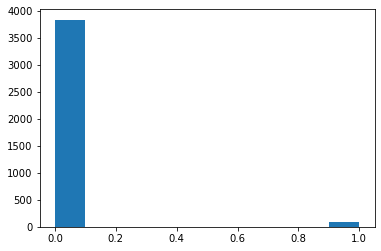

In [9]:
# construct target variable y (for the SARS-CoV-2 main protease data set, we convert Ki to pKi by taking negative decadic logarithm)

if settings_dict["dataset_name"] == "postera_sars_cov_2_mpro":
    y = -np.log10(dataframe.loc[:, settings_dict["prop_name"]].values.astype(float))
else:
    y = dataframe.loc[:, settings_dict["prop_name"]].values.astype(float)

print("Mean Value (Target) = ", np.mean(y))
print("Standard Deviation (Target) = ", np.std(y))
print("Maximum Value (Target) = ", np.amax(y))
print("Minimum Value (Target) = ", np.amin(y), "\n")

print("Shape of y = ", y.shape)
print("\n y = ", y)

plt.hist(y)

Shape of x_smiles =  (3921,)
CN(C(=O)CCCOc1ccc2[nH]c(=O)ccc2c1)C1CCCCC1


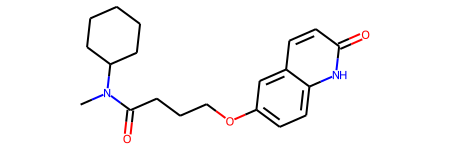

In [10]:
# extract SMILES strings

x_smiles = np.reshape(dataframe["SMILES"].values, (len(dataframe), 1))[:,0]

print("Shape of x_smiles = ", x_smiles.shape)
print(x_smiles[0])
display(Chem.MolFromSmiles(x_smiles[0]))

In [11]:
# create dictionary that maps smiles strings to their target values

x_smiles_to_y_dict = dict(list(zip(x_smiles, y)))

# Prepare Data Split

In [13]:
# choose settings for data splitting strategy

settings_dict["split_type"] = "rand" # choose "rand" for random split and "scaff" for scaffold split
settings_dict["split_type_rand_stratified"] = False # given a random split and a classification problem, choose whether to stratify the split
settings_dict["k_splits"] = 2 # choose number of cross validation folds k_splits
settings_dict["m_reps"] = 3 # choose number of random seeds m_reps with which the cross validation scheme is repeated
settings_dict["random_state_cv"] = 42 # choose random state

In [14]:
# construct data split dictionary

if settings_dict["split_type"] == "rand" and settings_dict["split_type_rand_stratified"] == False:
    
    data_split_dict = create_data_split_dict_random(x_smiles = x_smiles,
                                                    k_splits = settings_dict["k_splits"],
                                                    m_reps = settings_dict["m_reps"],
                                                    random_state_cv = settings_dict["random_state_cv"])

elif settings_dict["split_type"] == "rand" and settings_dict["split_type_rand_stratified"] == True:
    
    data_split_dict = create_data_split_dict_random_strat(x_smiles = x_smiles,
                                                          y = y,
                                                          k_splits = settings_dict["k_splits"],
                                                          m_reps = settings_dict["m_reps"],
                                                          random_state_cv = settings_dict["random_state_cv"])
    
elif settings_dict["split_type"] == "scaff":
    
    data_split_dict = create_data_split_dict_scaffold(x_smiles = x_smiles,
                                                      k_splits = settings_dict["k_splits"],
                                                      m_reps = settings_dict["m_reps"],
                                                      scaffold_func = "Bemis_Murcko_generic",
                                                      random_state_cv = settings_dict["random_state_cv"])

# Evaluate Models

In [18]:
# choose ECFP hyperparameters and ml model

settings_dict["ecfp_settings"] = {"mol_to_invs_function": ecfp_invariants,
                                  "radius": 2,
                                  "pool_method": "sorted",
                                  "dimension": 1024,
                                  "use_bond_invs": True,
                                  "use_chirality": True,
                                  "use_counts": False}

In [19]:
# chose sampling technique for imbalanced classification

settings_dict["oversampling"] = False
settings_dict["undersampling"] = False

In [20]:
# chose ml model: rf or mlp

settings_dict["ml_model"] = "rf"

In [21]:
# choose rf hyperparameters

settings_dict["rf_settings"] = {"n_estimators" : 100,
                                "max_depth" : None,
                                "min_samples_leaf" : 1,
                                "min_samples_split" : 2,
                                "bootstrap" : True,
                                "max_features": "sqrt",
                                "random_state" : 42}

if settings_dict["task_type"] == "regression":

    settings_dict["rf_settings"]["criterion"] = "squared_error"

elif settings_dict["task_type"] == "classification":

    settings_dict["rf_settings"]["criterion"] = "gini"

In [22]:
# choose mlp hyperparameters

settings_dict["mlp_settings"] = {"architecture" : list(arch(settings_dict["ecfp_settings"]["dimension"], 1, 512, 5)),
                                "hidden_activation" : nn.ReLU(),
                                "use_bias" : True,
                                "hidden_dropout_rate" : 0.25,
                                "hidden_batchnorm" : True,
                                "batch_size" : 64,
                                "dataloader_shuffle" : True,
                                "dataloader_drop_last" : True,
                                "learning_rate" : 1e-3,
                                "lr_lambda" : lambda epoch: max(0.98**epoch, 1e-2),
                                "lr_last_epoch": 0,
                                "weight_decay" : 0.1,
                                "num_epochs" : 250,
                                "optimiser" : torch.optim.AdamW,
                                "print_results_per_epochs" : None}

if settings_dict["task_type"] == "regression":

    settings_dict["mlp_settings"]["output_activation"] = nn.Identity()
    settings_dict["mlp_settings"]["loss_function"] = nn.MSELoss()
    settings_dict["mlp_settings"]["performance_metrics"] = "regression"

elif settings_dict["task_type"] == "classification":

    settings_dict["mlp_settings"]["output_activation"] = nn.Sigmoid()
    settings_dict["mlp_settings"]["loss_function"] = nn.BCELoss()
    settings_dict["mlp_settings"]["performance_metrics"] = "classification"

In [23]:
%%time
# run model and save results

scores_dict = {}

for (m, k) in data_split_dict.keys():

    # extract training- and test indices
    (ind_train, ind_test) = data_split_dict[(m, k)]
    
    # create smiles arrays
    x_smiles_train = x_smiles[ind_train]
    x_smiles_test = x_smiles[ind_test]
    
    # create target arrays
    y_train = y[ind_train]
    y_test = y[ind_test]
    
    # oversample
    if settings_dict["oversampling"] == True:
        (x_smiles_train, y_train) = oversample(x_smiles_train, y_train, random_seed = 42)
    
    # undersample
    if settings_dict["undersampling"] == True:
        (x_smiles_train, y_train) = undersample(x_smiles_train, y_train)
    
    # create ecfp featuriser
    featuriser = create_ecfp_featuriser(ecfp_settings = settings_dict["ecfp_settings"], 
                                        x_smiles_train = x_smiles_train, 
                                        y_train = y_train, 
                                        discretise_y = True if settings_dict["task_type"] == "regression" else False,
                                        base = 2, 
                                        random_state = 42)
    
    # create ecfp-based feature matrices
    X_train = featuriser(x_smiles_train)
    X_test = featuriser(x_smiles_test)

    # create ml model + train ml model + make predictions on test set
    if settings_dict["ml_model"] == "rf":
        
        rf_model = create_rf_model(settings_dict["rf_settings"], settings_dict["task_type"], balanced = False)
        rf_model.fit(X_train, y_train)
        y_test_pred = make_rf_prediction(rf_model, X_test, settings_dict["task_type"])
        
    if settings_dict["ml_model"] == "mlp":
        
        mlp_model = create_mlp_model(settings_dict["mlp_settings"])
        (loss_curve_train, loss_curve_test) = train_mlp_model(mlp_model, settings_dict["mlp_settings"], X_train, y_train, X_test, y_test)
        plt.plot(loss_curve_train)
        plt.plot(loss_curve_test)
        y_test_pred = mlp_model(torch.tensor(X_test, dtype = torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')).cpu().detach().numpy()[:,0]
        
    # record scores
    print(m, k)
    if settings_dict["task_type"] == "regression":
        scores_dict[(m, k)] = regression_scores(y_test, y_test_pred, display_results = True)
    elif settings_dict["task_type"] == "classification":
        scores_dict[(m, k)] = binary_classification_scores(y_test, y_test_pred, display_results = True)
        
# summarise, display and save scores for this experiment
summarise_display_and_save_results_and_settings(scores_dict, settings_dict, display_results = True)

Number of unique substructures =  11562
0 0


,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
Scores:,0.662294,0.53036,0.860095,3.2206,0.739764,0.70403,0.486495,2100.0


Number of unique substructures =  11685
0 1


,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
Scores:,0.676304,0.531758,0.877097,3.4915,0.769299,0.698275,0.470589,2100.0


Number of unique substructures =  11811
1 0


,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
Scores:,0.657243,0.5411,0.844173,3.2917,0.712628,0.706672,0.487921,2100.0


Number of unique substructures =  11563
1 1


,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
Scores:,0.667691,0.5232,0.86428,3.276,0.74698,0.722525,0.502459,2100.0


Number of unique substructures =  11834
2 0


,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
Scores:,0.67139,0.525667,0.873236,3.47805,0.762542,0.699449,0.475776,2100.0


Number of unique substructures =  11537
2 1


,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
Scores:,0.670294,0.52935,0.866193,3.1793,0.75029,0.699429,0.478649,2100.0


CPU times: user 33.9 s, sys: 51.8 ms, total: 33.9 s
Wall time: 33.9 s


In [55]:
%%time
# run full battery of experiments for one data set and data splitting type

delete_all_files_in_folder("results/" + settings_dict["dataset_name"] + "/" + settings_dict["split_type"] + "/")

for pool_method in ["hashed", "chi2", "mim", "sorted"]:
    for dimension in [512, 1024, 2048, 4096]:
        for inv_func in [ecfp_invariants, fcfp_invariants]:
            for radius in [1, 2, 3]:

                print("pool_method = ", pool_method)
                print("dimension = ", dimension)
                print("inv_func = ", inv_func)
                print("radius = ", radius, "\n")

                # choose ECFP hyperparameters
                settings_dict["ecfp_settings"] = {"mol_to_invs_function": inv_func,
                                                  "radius": radius,
                                                  "pool_method": pool_method,
                                                  "dimension": dimension,
                                                  "use_bond_invs": True,
                                                  "use_chirality": True,
                                                  "use_counts": False}

                # run rf- and mlp model and save results
                scores_dict_rf = {}
                scores_dict_mlp = {}

                for (m, k) in data_split_dict.keys():

                    # extract training- and test indices
                    (ind_train, ind_test) = data_split_dict[(m, k)]
                    
                    # create smiles arrays
                    x_smiles_train = x_smiles[ind_train]
                    x_smiles_test = x_smiles[ind_test]

                    # create target arrays
                    y_train = y[ind_train]
                    y_test = y[ind_test]

                    # oversample
                    if settings_dict["oversampling"] == True:
                        (x_smiles_train, y_train) = oversample(x_smiles_train, y_train, random_seed = 42)

                    # undersample
                    if settings_dict["undersampling"] == True:
                        (x_smiles_train, y_train) = undersample(x_smiles_train, y_train)

                    # create ecfp featuriser
                    featuriser = create_ecfp_featuriser(ecfp_settings = settings_dict["ecfp_settings"], 
                                                        x_smiles_train = x_smiles_train, 
                                                        y_train = y_train, 
                                                        discretise_y = True if settings_dict["task_type"] == "regression" else False,  
                                                        base = 2, 
                                                        random_state = 42)

                    # create ecfp-based feature matrices
                    X_train = featuriser(x_smiles_train)
                    X_test = featuriser(x_smiles_test)
                    
                    # create rf model + train ml model + make predictions on test set
                    rf_model = create_rf_model(settings_dict["rf_settings"], settings_dict["task_type"], balanced = False)
                    rf_model.fit(X_train, y_train)
                    y_test_pred = make_rf_prediction(rf_model, X_test, settings_dict["task_type"])

                    # record rf scores
                    print(m, k, "rf")
                    if settings_dict["task_type"] == "regression":
                        scores_dict_rf[(m, k)] = regression_scores(y_test, y_test_pred, display_results = False)
                    elif settings_dict["task_type"] == "classification":
                        scores_dict_rf[(m, k)] = binary_classification_scores(y_test, y_test_pred, display_results = False)
                        
                    # create mlp model + train ml model + make predictions on test set
                    settings_dict["mlp_settings"]["architecture"][0] = dimension
                    mlp_model = create_mlp_model(settings_dict["mlp_settings"])
                    (loss_curve_train, loss_curve_test) = train_mlp_model(mlp_model, settings_dict["mlp_settings"], X_train, y_train, X_test, y_test)
                    y_test_pred = mlp_model(torch.tensor(X_test, dtype = torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')).cpu().detach().numpy()[:,0]

                    # record mlp scores
                    print(m, k, "mlp")
                    if settings_dict["task_type"] == "regression":
                        scores_dict_mlp[(m, k)] = regression_scores(y_test, y_test_pred, display_results = False)
                    elif settings_dict["task_type"] == "classification":
                        scores_dict_mlp[(m, k)] = binary_classification_scores(y_test, y_test_pred, display_results = False)
                    
                # summarise, display and save scores for this experiment
                settings_dict["ml_model"] = "rf"
                summarise_display_and_save_results_and_settings(scores_dict_rf, settings_dict, display_results = True)
                settings_dict["ml_model"] = "mlp"
                summarise_display_and_save_results_and_settings(scores_dict_mlp, settings_dict, display_results = True)
                print("\n \n \n")

pool_method =  hashed
dimension =  512
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  1 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.073802,0.662232,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.082601,0.710113,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.026349,0.536324,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.048742,0.601808,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.074866,0.590679,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.057809,0.767964,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.060695,0.644853,0.981073,0.499895,0.0,-0.001149,0.0,0.999789,0.0,0.981276,1708.000000,1676.000000,32.000000
std,0.019076,0.077764,0.002401,0.000149,0.0,0.001625,0.0,0.000299,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.057652,0.595492,0.970899,0.535734,0.098361,0.085507,0.083333,0.988134,0.120000,0.982306,1890.000000,1854.000000,36.000000
"(0, 1)",0.084306,0.590144,0.975754,0.567089,0.177778,0.171573,0.142857,0.991322,0.235294,0.984095,1526.000000,1498.000000,28.000000
"(1, 0)",0.036194,0.598923,0.978299,0.498208,0.000000,-0.008087,0.000000,0.996416,0.000000,0.981754,1705.000000,1674.000000,31.000000
"(1, 1)",0.024956,0.474781,0.973115,0.496126,0.000000,-0.012271,0.000000,0.992253,0.000000,0.980565,1711.000000,1678.000000,33.000000
"(2, 0)",0.054889,0.481758,0.971362,0.509531,0.039216,0.034091,0.025641,0.993421,0.083333,0.977634,1711.000000,1672.000000,39.000000
"(2, 1)",0.039088,0.564357,0.974194,0.514048,0.043478,0.030618,0.040000,0.988095,0.047619,0.985748,1705.000000,1680.000000,25.000000
mean,0.049514,0.550909,0.973937,0.520123,0.059805,0.050239,0.048639,0.991607,0.081041,0.982017,1708.000000,1676.000000,32.000000
std,0.019126,0.052584,0.002547,0.024680,0.062247,0.063141,0.050688,0.002924,0.081209,0.002573,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  512
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  2 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.073815,0.651130,0.980952,0.5,0.0,0.0,0.0,1.0,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.087199,0.643274,0.981651,0.5,0.0,0.0,0.0,1.0,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.034614,0.543232,0.981818,0.5,0.0,0.0,0.0,1.0,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.057680,0.664563,0.980713,0.5,0.0,0.0,0.0,1.0,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.075288,0.541897,0.977206,0.5,0.0,0.0,0.0,1.0,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.034810,0.693583,0.985337,0.5,0.0,0.0,0.0,1.0,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.060568,0.622947,0.981280,0.5,0.0,0.0,0.0,1.0,NaN,0.981280,1708.000000,1676.000000,32.000000
std,0.020194,0.058953,0.002377,0.0,0.0,0.0,0.0,0.0,NaN,0.002377,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.057639,0.572471,0.976720,0.525081,0.083333,0.086326,0.055556,0.994606,0.166667,0.981896,1890.000000,1854.000000,36.000000
"(0, 1)",0.103192,0.609050,0.977720,0.533044,0.105263,0.109928,0.071429,0.994660,0.200000,0.982850,1526.000000,1498.000000,28.000000
"(1, 0)",0.066931,0.469765,0.981818,0.531661,0.114286,0.174875,0.064516,0.998805,0.500000,0.982951,1705.000000,1674.000000,31.000000
"(1, 1)",0.030992,0.523766,0.976622,0.497914,0.000000,-0.008988,0.000000,0.995828,0.000000,0.980634,1711.000000,1678.000000,33.000000
"(2, 0)",0.063100,0.467673,0.975453,0.524146,0.086957,0.112912,0.051282,0.997010,0.285714,0.978286,1711.000000,1672.000000,39.000000
"(2, 1)",0.024839,0.523357,0.980059,0.497321,0.000000,-0.008886,0.000000,0.994643,0.000000,0.985259,1705.000000,1680.000000,25.000000
mean,0.057782,0.527680,0.978065,0.518195,0.064973,0.077694,0.040464,0.995925,0.192063,0.981979,1708.000000,1676.000000,32.000000
std,0.025746,0.051017,0.002195,0.014898,0.047114,0.066843,0.029317,0.001553,0.172279,0.002157,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  512
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  3 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.047810,0.648897,0.980952,0.5,0.0,0.0,0.0,1.0,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.074211,0.634978,0.981651,0.5,0.0,0.0,0.0,1.0,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.020488,0.526593,0.981818,0.5,0.0,0.0,0.0,1.0,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.032384,0.605185,0.980713,0.5,0.0,0.0,0.0,1.0,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.059344,0.509554,0.977206,0.5,0.0,0.0,0.0,1.0,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.064464,0.748024,0.985337,0.5,0.0,0.0,0.0,1.0,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.049784,0.612205,0.981280,0.5,0.0,0.0,0.0,1.0,NaN,0.981280,1708.000000,1676.000000,32.000000
std,0.018567,0.079820,0.002377,0.0,0.0,0.0,0.0,0.0,NaN,0.002377,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.059656,0.581475,0.977249,0.538970,0.122449,0.128902,0.083333,0.994606,0.230769,0.982419,1890.000000,1854.000000,36.000000
"(0, 1)",0.020138,0.517523,0.980341,0.499332,0.000000,-0.004953,0.000000,0.998665,0.000000,0.981627,1526.000000,1498.000000,28.000000
"(1, 0)",0.030117,0.539793,0.980645,0.499403,0.000000,-0.004663,0.000000,0.998805,0.000000,0.981797,1705.000000,1674.000000,31.000000
"(1, 1)",0.035599,0.555694,0.977206,0.498212,0.000000,-0.008319,0.000000,0.996424,0.000000,0.980645,1711.000000,1678.000000,33.000000
"(2, 0)",0.024943,0.430898,0.976037,0.499402,0.000000,-0.005225,0.000000,0.998804,0.000000,0.977180,1711.000000,1672.000000,39.000000
"(2, 1)",0.018586,0.509500,0.981232,0.497917,0.000000,-0.007832,0.000000,0.995833,0.000000,0.985277,1705.000000,1680.000000,25.000000
mean,0.031506,0.522481,0.978785,0.505539,0.020408,0.016318,0.013889,0.997190,0.038462,0.981491,1708.000000,1676.000000,32.000000
std,0.013846,0.047370,0.002011,0.014962,0.045634,0.050369,0.031056,0.001658,0.086003,0.002402,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  512
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  1 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.043275,0.619067,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.054944,0.633809,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.019771,0.457866,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.033088,0.489219,0.979544,0.499404,0.0,-0.004797,0.0,0.998808,0.0,0.980690,1711.000000,1678.000000,33.000000
"(2, 0)",0.064926,0.586692,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.039788,0.645940,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.042632,0.572099,0.980976,0.499845,0.0,-0.001383,0.0,0.999690,0.0,0.981274,1708.000000,1676.000000,32.000000
std,0.014554,0.072569,0.002449,0.000232,0.0,0.001991,0.0,0.000464,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.039064,0.615673,0.973016,0.536812,0.105263,0.096010,0.083333,0.990291,0.142857,0.982343,1890.000000,1854.000000,36.000000
"(0, 1)",0.045103,0.579856,0.974443,0.531375,0.093023,0.085364,0.071429,0.991322,0.133333,0.982793,1526.000000,1498.000000,28.000000
"(1, 0)",0.028699,0.502919,0.974780,0.512246,0.044444,0.036262,0.032258,0.992234,0.071429,0.982259,1705.000000,1674.000000,31.000000
"(1, 1)",0.038817,0.599623,0.975453,0.512172,0.045455,0.041891,0.030303,0.994041,0.090909,0.981176,1711.000000,1678.000000,33.000000
"(2, 0)",0.030614,0.549219,0.971946,0.509830,0.040000,0.036713,0.025641,0.994019,0.090909,0.977647,1711.000000,1672.000000,39.000000
"(2, 1)",0.041418,0.619893,0.976540,0.534940,0.090909,0.080016,0.080000,0.989881,0.105263,0.986358,1705.000000,1680.000000,25.000000
mean,0.037286,0.577864,0.974363,0.522896,0.069849,0.062709,0.053827,0.991965,0.105783,0.982096,1708.000000,1676.000000,32.000000
std,0.005801,0.041050,0.001514,0.011617,0.026976,0.024934,0.024761,0.001641,0.025022,0.002562,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  512
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  2 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.096090,0.624146,0.980952,0.5,0.0,0.0,0.0,1.0,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.052539,0.651953,0.981651,0.5,0.0,0.0,0.0,1.0,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.031629,0.567638,0.981818,0.5,0.0,0.0,0.0,1.0,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.053429,0.577798,0.980713,0.5,0.0,0.0,0.0,1.0,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.093971,0.570543,0.977206,0.5,0.0,0.0,0.0,1.0,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.045004,0.719619,0.985337,0.5,0.0,0.0,0.0,1.0,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.062110,0.618616,0.981280,0.5,0.0,0.0,0.0,1.0,NaN,0.981280,1708.000000,1676.000000,32.000000
std,0.024353,0.054649,0.002377,0.0,0.0,0.0,0.0,0.0,NaN,0.002377,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.051336,0.506128,0.976720,0.511462,0.043478,0.043192,0.027778,0.995146,0.100000,0.981383,1890.000000,1854.000000,36.000000
"(0, 1)",0.050807,0.584124,0.977720,0.515521,0.055556,0.057689,0.035714,0.995327,0.125000,0.982213,1526.000000,1498.000000,28.000000
"(1, 0)",0.091892,0.581397,0.980059,0.514934,0.055556,0.073801,0.032258,0.997611,0.200000,0.982353,1705.000000,1674.000000,31.000000
"(1, 1)",0.051447,0.538854,0.978960,0.513960,0.052632,0.071135,0.030303,0.997616,0.200000,0.981243,1711.000000,1678.000000,33.000000
"(2, 0)",0.066239,0.453188,0.974284,0.523548,0.083333,0.097169,0.051282,0.995813,0.222222,0.978261,1711.000000,1672.000000,39.000000
"(2, 1)",0.038365,0.634976,0.982991,0.518512,0.064516,0.075151,0.040000,0.997024,0.166667,0.985874,1705.000000,1680.000000,25.000000
mean,0.058348,0.549778,0.978455,0.516323,0.059178,0.069690,0.036223,0.996423,0.168981,0.981888,1708.000000,1676.000000,32.000000
std,0.017031,0.058868,0.002719,0.003847,0.012434,0.016583,0.007782,0.001033,0.043698,0.002237,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  512
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  3 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.056689,0.604766,0.980952,0.5,0.0,0.0,0.0,1.0,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.042169,0.682076,0.981651,0.5,0.0,0.0,0.0,1.0,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.019434,0.477753,0.981818,0.5,0.0,0.0,0.0,1.0,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.056384,0.616598,0.980713,0.5,0.0,0.0,0.0,1.0,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.082205,0.553621,0.977206,0.5,0.0,0.0,0.0,1.0,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.055695,0.691560,0.985337,0.5,0.0,0.0,0.0,1.0,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.052096,0.604396,0.981280,0.5,0.0,0.0,0.0,1.0,NaN,0.981280,1708.000000,1676.000000,32.000000
std,0.018816,0.073482,0.002377,0.0,0.0,0.0,0.0,0.0,NaN,0.002377,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.038769,0.588877,0.977249,0.498112,0.000000,-0.008496,0.000000,0.996224,0.000000,0.980882,1890.000000,1854.000000,36.000000
"(0, 1)",0.049962,0.526094,0.980341,0.499332,0.000000,-0.004953,0.000000,0.998665,0.000000,0.981627,1526.000000,1498.000000,28.000000
"(1, 0)",0.028161,0.479448,0.979472,0.514636,0.054054,0.066043,0.032258,0.997013,0.166667,0.982343,1705.000000,1674.000000,31.000000
"(1, 1)",0.031684,0.513075,0.977791,0.513364,0.050000,0.057587,0.030303,0.996424,0.142857,0.981221,1711.000000,1678.000000,33.000000
"(2, 0)",0.084959,0.548606,0.975453,0.524146,0.086957,0.112912,0.051282,0.997010,0.285714,0.978286,1711.000000,1672.000000,39.000000
"(2, 1)",0.091016,0.610524,0.982405,0.537917,0.117647,0.125791,0.080000,0.995833,0.222222,0.986439,1705.000000,1680.000000,25.000000
mean,0.054092,0.544437,0.978785,0.514584,0.051443,0.058147,0.032307,0.996862,0.136243,0.981800,1708.000000,1676.000000,32.000000
std,0.024975,0.044541,0.002253,0.013792,0.042712,0.051737,0.028066,0.000908,0.106323,0.002428,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  1024
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  1 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.077453,0.642657,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.116043,0.732441,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.051137,0.555141,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.054832,0.641438,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.093580,0.551481,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.073572,0.691655,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.077770,0.635802,0.981182,0.499950,0.0,-0.000565,0.0,0.999901,0.0,0.981278,1708.000000,1676.000000,32.000000
std,0.022241,0.066022,0.002410,0.000111,0.0,0.001264,0.0,0.000222,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.077996,0.588877,0.972487,0.550162,0.133333,0.122475,0.111111,0.989213,0.166667,0.982851,1890.000000,1854.000000,36.000000
"(0, 1)",0.059113,0.566279,0.975754,0.549566,0.139535,0.134856,0.107143,0.991989,0.200000,0.983455,1526.000000,1498.000000,28.000000
"(1, 0)",0.084404,0.622625,0.982405,0.516129,0.062500,0.178017,0.032258,1.000000,1.000000,0.982394,1705.000000,1674.000000,31.000000
"(1, 1)",0.024872,0.520542,0.970777,0.494934,0.000000,-0.014048,0.000000,0.989869,0.000000,0.980519,1711.000000,1678.000000,33.000000
"(2, 0)",0.071045,0.533194,0.972531,0.547694,0.145455,0.147909,0.102564,0.992823,0.250000,0.979351,1711.000000,1672.000000,39.000000
"(2, 1)",0.045625,0.589071,0.970088,0.511964,0.037736,0.022631,0.040000,0.983929,0.035714,0.985689,1705.000000,1680.000000,25.000000
mean,0.060509,0.570098,0.974007,0.528408,0.086426,0.098640,0.065513,0.991304,0.275397,0.982377,1708.000000,1676.000000,32.000000
std,0.020336,0.034890,0.004160,0.021735,0.056151,0.069623,0.043270,0.004817,0.335781,0.002040,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  1024
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  2 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.068899,0.641114,0.980952,0.5,0.0,0.0,0.0,1.0,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.133030,0.643298,0.981651,0.5,0.0,0.0,0.0,1.0,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.059492,0.497032,0.981818,0.5,0.0,0.0,0.0,1.0,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.040520,0.661059,0.980713,0.5,0.0,0.0,0.0,1.0,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.123556,0.554042,0.977206,0.5,0.0,0.0,0.0,1.0,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.070559,0.754036,0.985337,0.5,0.0,0.0,0.0,1.0,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.082676,0.625097,0.981280,0.5,0.0,0.0,0.0,1.0,NaN,0.981280,1708.000000,1676.000000,32.000000
std,0.033808,0.081604,0.002377,0.0,0.0,0.0,0.0,0.0,NaN,0.002377,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.065628,0.628086,0.977249,0.498112,0.000000,-0.008496,0.000000,0.996224,0.000000,0.980882,1890.000000,1854.000000,36.000000
"(0, 1)",0.102941,0.635669,0.980341,0.534379,0.117647,0.147456,0.071429,0.997330,0.333333,0.982895,1526.000000,1498.000000,28.000000
"(1, 0)",0.063393,0.475142,0.982405,0.531959,0.117647,0.203773,0.064516,0.999403,0.666667,0.982961,1705.000000,1674.000000,31.000000
"(1, 1)",0.027241,0.419475,0.977206,0.513066,0.048780,0.052682,0.030303,0.995828,0.125000,0.981210,1711.000000,1678.000000,33.000000
"(2, 0)",0.080344,0.521025,0.976037,0.536966,0.127660,0.161746,0.076923,0.997010,0.375000,0.978861,1711.000000,1672.000000,39.000000
"(2, 1)",0.046154,0.514500,0.981232,0.537321,0.111111,0.112062,0.080000,0.994643,0.181818,0.986423,1705.000000,1680.000000,25.000000
mean,0.064284,0.532316,0.979078,0.525301,0.087141,0.111537,0.053862,0.996740,0.280303,0.982205,1708.000000,1676.000000,32.000000
std,0.023999,0.077783,0.002359,0.014698,0.046802,0.070935,0.029135,0.001472,0.213481,0.002337,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  1024
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  3 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.061422,0.659610,0.980952,0.5,0.0,0.0,0.0,1.0,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.059743,0.595866,0.981651,0.5,0.0,0.0,0.0,1.0,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.033617,0.472945,0.981818,0.5,0.0,0.0,0.0,1.0,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.028226,0.532100,0.980713,0.5,0.0,0.0,0.0,1.0,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.073388,0.536361,0.977206,0.5,0.0,0.0,0.0,1.0,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.062759,0.794071,0.985337,0.5,0.0,0.0,0.0,1.0,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.053193,0.598492,0.981280,0.5,0.0,0.0,0.0,1.0,NaN,0.981280,1708.000000,1676.000000,32.000000
std,0.016414,0.104900,0.002377,0.0,0.0,0.0,0.0,0.0,NaN,0.002377,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.067238,0.609628,0.979894,0.513080,0.050000,0.077810,0.027778,0.998382,0.250000,0.981442,1890.000000,1854.000000,36.000000
"(0, 1)",0.065414,0.531447,0.979685,0.516522,0.060606,0.077603,0.035714,0.997330,0.200000,0.982249,1526.000000,1498.000000,28.000000
"(1, 0)",0.057780,0.521717,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.026751,0.503196,0.978375,0.498808,0.000000,-0.006789,0.000000,0.997616,0.000000,0.980668,1711.000000,1678.000000,33.000000
"(2, 0)",0.066017,0.487502,0.974868,0.536368,0.122449,0.142413,0.076923,0.995813,0.300000,0.978836,1711.000000,1672.000000,39.000000
"(2, 1)",0.013656,0.448595,0.981818,0.498214,0.000000,-0.007249,0.000000,0.996429,0.000000,0.985285,1705.000000,1680.000000,25.000000
mean,0.049476,0.517014,0.979410,0.510499,0.038843,0.047298,0.023403,0.997595,0.150000,0.981716,1708.000000,1676.000000,32.000000
std,0.021259,0.049246,0.002367,0.013601,0.044934,0.056324,0.027923,0.001355,0.126491,0.001937,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  1024
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  1 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.047894,0.652883,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.047428,0.638339,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.023506,0.453097,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.034902,0.506059,0.979544,0.499404,0.0,-0.004797,0.0,0.998808,0.0,0.980690,1711.000000,1678.000000,33.000000
"(2, 0)",0.082722,0.565345,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.049473,0.671179,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.047654,0.581150,0.980976,0.499845,0.0,-0.001383,0.0,0.999690,0.0,0.981274,1708.000000,1676.000000,32.000000
std,0.018161,0.080423,0.002449,0.000232,0.0,0.001991,0.0,0.000464,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.034713,0.549585,0.969312,0.521305,0.064516,0.050005,0.055556,0.987055,0.076923,0.981760,1890.000000,1854.000000,36.000000
"(0, 1)",0.037307,0.599096,0.969201,0.528705,0.078431,0.063238,0.071429,0.985981,0.086957,0.982701,1526.000000,1498.000000,28.000000
"(1, 0)",0.051373,0.484998,0.972434,0.511051,0.040816,0.028894,0.032258,0.989845,0.055556,0.982217,1705.000000,1674.000000,31.000000
"(1, 1)",0.023347,0.520542,0.973700,0.511278,0.042553,0.034435,0.030303,0.992253,0.071429,0.981143,1711.000000,1678.000000,33.000000
"(2, 0)",0.041447,0.567453,0.969024,0.508335,0.036364,0.025848,0.025641,0.991029,0.062500,0.977581,1711.000000,1672.000000,39.000000
"(2, 1)",0.077953,0.634583,0.974780,0.534048,0.085106,0.072525,0.080000,0.988095,0.090909,0.986334,1705.000000,1680.000000,25.000000
mean,0.044357,0.559376,0.971408,0.519120,0.057965,0.045824,0.049198,0.989043,0.074045,0.981956,1708.000000,1676.000000,32.000000
std,0.017178,0.049049,0.002332,0.009682,0.019134,0.017555,0.021144,0.002203,0.012526,0.002570,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  1024
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  2 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.095335,0.644590,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.065444,0.682076,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.028483,0.619002,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.057754,0.551992,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.077530,0.525066,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.042342,0.711190,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.061148,0.622319,0.981182,0.499950,0.0,-0.000565,0.0,0.999901,0.0,0.981278,1708.000000,1676.000000,32.000000
std,0.021939,0.066307,0.002410,0.000111,0.0,0.001264,0.0,0.000222,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.040702,0.600114,0.976720,0.497843,0.000000,-0.009085,0.000000,0.995685,0.000000,0.980871,1890.000000,1854.000000,36.000000
"(0, 1)",0.035591,0.559043,0.975754,0.514519,0.051282,0.046069,0.035714,0.993324,0.090909,0.982178,1526.000000,1498.000000,28.000000
"(1, 0)",0.115780,0.699272,0.981232,0.531362,0.111111,0.154983,0.064516,0.998208,0.400000,0.982941,1705.000000,1674.000000,31.000000
"(1, 1)",0.035540,0.542484,0.976622,0.512768,0.047619,0.048551,0.030303,0.995232,0.111111,0.981199,1711.000000,1678.000000,33.000000
"(2, 0)",0.073852,0.575535,0.972531,0.535172,0.113208,0.116540,0.076923,0.993421,0.214286,0.978786,1711.000000,1672.000000,39.000000
"(2, 1)",0.067199,0.596238,0.980059,0.536726,0.105263,0.101498,0.080000,0.993452,0.153846,0.986407,1705.000000,1680.000000,25.000000
mean,0.061444,0.595448,0.977153,0.521398,0.071414,0.076426,0.047909,0.994887,0.161692,0.982064,1708.000000,1676.000000,32.000000
std,0.028604,0.050545,0.002854,0.014146,0.041912,0.053882,0.028581,0.001753,0.124721,0.002329,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  1024
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  3 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.078464,0.711150,0.980952,0.5,0.0,0.0,0.0,1.0,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.047315,0.712033,0.981651,0.5,0.0,0.0,0.0,1.0,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.044292,0.546634,0.981818,0.5,0.0,0.0,0.0,1.0,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.053129,0.610891,0.980713,0.5,0.0,0.0,0.0,1.0,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.136951,0.557148,0.977206,0.5,0.0,0.0,0.0,1.0,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.039155,0.653381,0.985337,0.5,0.0,0.0,0.0,1.0,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.066551,0.631873,0.981280,0.5,0.0,0.0,0.0,1.0,NaN,0.981280,1708.000000,1676.000000,32.000000
std,0.033898,0.066411,0.002377,0.0,0.0,0.0,0.0,0.0,NaN,0.002377,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.059063,0.586540,0.977249,0.511731,0.044444,0.046588,0.027778,0.995685,0.111111,0.981393,1890.000000,1854.000000,36.000000
"(0, 1)",0.033086,0.570320,0.980996,0.499666,0.000000,-0.003501,0.000000,0.999332,0.000000,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.073242,0.541074,0.982405,0.516129,0.062500,0.178017,0.032258,1.000000,1.000000,0.982394,1705.000000,1674.000000,31.000000
"(1, 1)",0.028295,0.488081,0.979544,0.514258,0.054054,0.081205,0.030303,0.998212,0.250000,0.981254,1711.000000,1678.000000,33.000000
"(2, 0)",0.089793,0.584023,0.974868,0.523847,0.085106,0.104342,0.051282,0.996411,0.250000,0.978274,1711.000000,1672.000000,39.000000
"(2, 1)",0.043672,0.630071,0.982991,0.498810,0.000000,-0.005916,0.000000,0.997619,0.000000,0.985303,1705.000000,1680.000000,25.000000
mean,0.054525,0.566685,0.979676,0.510740,0.041017,0.066789,0.023603,0.997877,0.268519,0.981709,1708.000000,1676.000000,32.000000
std,0.021910,0.043895,0.002864,0.008936,0.031496,0.064063,0.018337,0.001514,0.342718,0.002062,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  2048
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  1 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.095011,0.673896,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.113948,0.670561,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.051239,0.591388,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.039259,0.586936,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.099722,0.606045,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.088061,0.737786,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.081206,0.644435,0.981182,0.499950,0.0,-0.000565,0.0,0.999901,0.0,0.981278,1708.000000,1676.000000,32.000000
std,0.026802,0.054557,0.002410,0.000111,0.0,0.001264,0.0,0.000222,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.080757,0.608572,0.970370,0.521845,0.066667,0.053336,0.055556,0.988134,0.083333,0.981779,1890.000000,1854.000000,36.000000
"(0, 1)",0.082448,0.496138,0.971166,0.547230,0.120000,0.106352,0.107143,0.987316,0.136364,0.983378,1526.000000,1498.000000,28.000000
"(1, 0)",0.080048,0.608404,0.980645,0.531063,0.108108,0.140173,0.064516,0.997611,0.333333,0.982931,1705.000000,1674.000000,31.000000
"(1, 1)",0.037531,0.609483,0.973115,0.510980,0.041667,0.032398,0.030303,0.991657,0.066667,0.981132,1711.000000,1678.000000,33.000000
"(2, 0)",0.071644,0.556872,0.976037,0.536966,0.127660,0.161746,0.076923,0.997010,0.375000,0.978861,1711.000000,1672.000000,39.000000
"(2, 1)",0.043004,0.609190,0.973021,0.513452,0.041667,0.028033,0.040000,0.986905,0.043478,0.985731,1705.000000,1680.000000,25.000000
mean,0.065906,0.581443,0.974059,0.526923,0.084295,0.087006,0.062407,0.991439,0.173029,0.982302,1708.000000,1676.000000,32.000000
std,0.018515,0.042622,0.003446,0.012857,0.035748,0.052250,0.025153,0.004428,0.131641,0.002113,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  2048
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  2 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.075040,0.654523,0.980423,0.499730,0.0,-0.003206,0.0,0.999461,0.0,0.980942,1890.000000,1854.000000,36.000000
"(0, 1)",0.141094,0.651929,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.056592,0.483023,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.033538,0.589076,0.980713,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.136787,0.533792,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.047655,0.702369,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.081784,0.602452,0.981192,0.499955,0.0,-0.000534,0.0,0.999910,0.0,0.981278,1708.000000,1676.000000,32.000000
std,0.042261,0.075608,0.002398,0.000101,0.0,0.001195,0.0,0.000201,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.069507,0.596511,0.977249,0.525351,0.085106,0.091110,0.055556,0.995146,0.181818,0.981905,1890.000000,1854.000000,36.000000
"(0, 1)",0.106462,0.636706,0.977720,0.533044,0.105263,0.109928,0.071429,0.994660,0.200000,0.982850,1526.000000,1498.000000,28.000000
"(1, 0)",0.087485,0.496782,0.980645,0.515233,0.057143,0.084138,0.032258,0.998208,0.250000,0.982363,1705.000000,1674.000000,31.000000
"(1, 1)",0.022170,0.402662,0.976622,0.512768,0.047619,0.048551,0.030303,0.995232,0.111111,0.981199,1711.000000,1678.000000,33.000000
"(2, 0)",0.085650,0.601905,0.974284,0.536069,0.120000,0.134709,0.076923,0.995215,0.272727,0.978824,1711.000000,1672.000000,39.000000
"(2, 1)",0.030129,0.550595,0.981232,0.497917,0.000000,-0.007832,0.000000,0.995833,0.000000,0.985277,1705.000000,1680.000000,25.000000
mean,0.066900,0.547527,0.977958,0.520064,0.069189,0.076767,0.044411,0.995716,0.169276,0.982070,1708.000000,1676.000000,32.000000
std,0.030822,0.078400,0.002373,0.013036,0.039862,0.045953,0.026553,0.001165,0.091613,0.001928,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  2048
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  3 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.070236,0.601605,0.980952,0.5,0.0,0.0,0.0,1.0,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.118823,0.619922,0.981651,0.5,0.0,0.0,0.0,1.0,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.059687,0.556558,0.981818,0.5,0.0,0.0,0.0,1.0,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.033044,0.617474,0.980713,0.5,0.0,0.0,0.0,1.0,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.101163,0.496166,0.977206,0.5,0.0,0.0,0.0,1.0,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.049567,0.737179,0.985337,0.5,0.0,0.0,0.0,1.0,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.072087,0.604817,0.981280,0.5,0.0,0.0,0.0,1.0,NaN,0.981280,1708.000000,1676.000000,32.000000
std,0.029491,0.073089,0.002377,0.0,0.0,0.0,0.0,0.0,NaN,0.002377,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.080250,0.574464,0.976190,0.524811,0.081633,0.082069,0.055556,0.994067,0.153846,0.981886,1890.000000,1854.000000,36.000000
"(0, 1)",0.163917,0.592743,0.981651,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.067063,0.504856,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.032524,0.523711,0.977791,0.498510,0.000000,-0.007592,0.000000,0.997020,0.000000,0.980657,1711.000000,1678.000000,33.000000
"(2, 0)",0.092816,0.455328,0.977206,0.512521,0.048780,0.109383,0.025641,0.999402,0.500000,0.977765,1711.000000,1672.000000,39.000000
"(2, 1)",0.010371,0.312619,0.980059,0.497321,0.000000,-0.008886,0.000000,0.994643,0.000000,0.985259,1705.000000,1680.000000,25.000000
mean,0.074490,0.493953,0.979119,0.505527,0.021736,0.029162,0.013533,0.997522,0.163462,0.981506,1708.000000,1676.000000,32.000000
std,0.048809,0.092754,0.002183,0.009987,0.032168,0.047843,0.020996,0.002459,0.204200,0.002201,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  2048
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  1 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.032889,0.591431,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.054945,0.669941,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.022739,0.511938,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.029122,0.460523,0.979544,0.499404,0.0,-0.004797,0.0,0.998808,0.0,0.980690,1711.000000,1678.000000,33.000000
"(2, 0)",0.077835,0.604864,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.038687,0.689417,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.042703,0.588019,0.980976,0.499845,0.0,-0.001383,0.0,0.999690,0.0,0.981274,1708.000000,1676.000000,32.000000
std,0.018617,0.080965,0.002449,0.000232,0.0,0.001991,0.0,0.000464,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.032395,0.583461,0.969841,0.521575,0.065574,0.051627,0.055556,0.987594,0.080000,0.981769,1890.000000,1854.000000,36.000000
"(0, 1)",0.057361,0.575041,0.972477,0.547897,0.125000,0.113044,0.107143,0.988652,0.150000,0.983400,1526.000000,1498.000000,28.000000
"(1, 0)",0.067033,0.520050,0.978886,0.530167,0.100000,0.111248,0.064516,0.995818,0.222222,0.982901,1705.000000,1674.000000,31.000000
"(1, 1)",0.033564,0.501345,0.976037,0.512470,0.046512,0.044998,0.030303,0.994636,0.100000,0.981188,1711.000000,1678.000000,33.000000
"(2, 0)",0.043067,0.528754,0.964348,0.518464,0.061538,0.045053,0.051282,0.985646,0.076923,0.978042,1711.000000,1672.000000,39.000000
"(2, 1)",0.031387,0.581321,0.967155,0.530179,0.066667,0.051164,0.080000,0.980357,0.057143,0.986228,1705.000000,1680.000000,25.000000
mean,0.044135,0.548329,0.971458,0.526792,0.077548,0.069522,0.064800,0.988784,0.114381,0.982254,1708.000000,1676.000000,32.000000
std,0.013616,0.032728,0.004981,0.011328,0.026574,0.030256,0.024091,0.005260,0.056224,0.002471,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  2048
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  2 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.083590,0.631210,0.980952,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.067479,0.658187,0.981651,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.040578,0.574652,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.050004,0.612201,0.980129,0.499702,0.000000,-0.003391,0.000000,0.999404,0.000000,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.080449,0.579683,0.977791,0.512821,0.050000,0.158339,0.025641,1.000000,1.000000,0.977778,1711.000000,1672.000000,39.000000
"(2, 1)",0.040947,0.639774,0.984751,0.499702,0.000000,-0.002955,0.000000,0.999405,0.000000,0.985329,1705.000000,1680.000000,25.000000
mean,0.060508,0.615951,0.981182,0.502037,0.008333,0.025332,0.004274,0.999801,0.333333,0.981372,1708.000000,1676.000000,32.000000
std,0.017650,0.030603,0.002083,0.004824,0.018634,0.059500,0.009556,0.000281,0.471405,0.002216,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.048756,0.616819,0.976190,0.511192,0.042553,0.040224,0.027778,0.994606,0.090909,0.981373,1890.000000,1854.000000,36.000000
"(0, 1)",0.046670,0.668260,0.975098,0.514186,0.050000,0.043108,0.035714,0.992657,0.083333,0.982166,1526.000000,1498.000000,28.000000
"(1, 0)",0.091997,0.518326,0.980645,0.531063,0.108108,0.140173,0.064516,0.997611,0.333333,0.982931,1705.000000,1674.000000,31.000000
"(1, 1)",0.036406,0.504632,0.977206,0.513066,0.048780,0.052682,0.030303,0.995828,0.125000,0.981210,1711.000000,1678.000000,33.000000
"(2, 0)",0.116263,0.589429,0.975453,0.524146,0.086957,0.112912,0.051282,0.997010,0.285714,0.978286,1711.000000,1672.000000,39.000000
"(2, 1)",0.052948,0.621429,0.980059,0.536726,0.105263,0.101498,0.080000,0.993452,0.153846,0.986407,1705.000000,1680.000000,25.000000
mean,0.065507,0.586483,0.977442,0.521730,0.073610,0.081766,0.048266,0.995194,0.178689,0.982062,1708.000000,1676.000000,32.000000
std,0.028629,0.057998,0.002167,0.009668,0.027412,0.038377,0.019062,0.001796,0.096321,0.002419,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  2048
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  3 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.070578,0.711435,0.980952,0.5,0.0,0.0,0.0,1.0,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.063468,0.663766,0.981651,0.5,0.0,0.0,0.0,1.0,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.068707,0.581850,0.981818,0.5,0.0,0.0,0.0,1.0,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.051928,0.662387,0.980713,0.5,0.0,0.0,0.0,1.0,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.096674,0.573457,0.977206,0.5,0.0,0.0,0.0,1.0,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.050113,0.723679,0.985337,0.5,0.0,0.0,0.0,1.0,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.066912,0.652762,0.981280,0.5,0.0,0.0,0.0,1.0,NaN,0.981280,1708.000000,1676.000000,32.000000
std,0.015390,0.057740,0.002377,0.0,0.0,0.0,0.0,0.0,NaN,0.002377,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.041597,0.493078,0.977778,0.512001,0.045455,0.050536,0.027778,0.996224,0.125000,0.981403,1890.000000,1854.000000,36.000000
"(0, 1)",0.035925,0.506091,0.980341,0.516856,0.062500,0.088487,0.035714,0.997997,0.250000,0.982260,1526.000000,1498.000000,28.000000
"(1, 0)",0.103732,0.506542,0.982405,0.531959,0.117647,0.203773,0.064516,0.999403,0.666667,0.982961,1705.000000,1674.000000,31.000000
"(1, 1)",0.026908,0.441913,0.978960,0.499106,0.000000,-0.005877,0.000000,0.998212,0.000000,0.980679,1711.000000,1678.000000,33.000000
"(2, 0)",0.098842,0.500820,0.974284,0.561112,0.185185,0.195681,0.128205,0.994019,0.333333,0.979953,1711.000000,1672.000000,39.000000
"(2, 1)",0.061992,0.620167,0.983578,0.518810,0.066667,0.083622,0.040000,0.997619,0.200000,0.985882,1705.000000,1680.000000,25.000000
mean,0.061499,0.511435,0.979557,0.523307,0.079576,0.102704,0.049369,0.997246,0.262500,0.982190,1708.000000,1676.000000,32.000000
std,0.030070,0.053476,0.003061,0.019491,0.058534,0.075208,0.040046,0.001720,0.208264,0.001921,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  4096
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  1 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.070866,0.668217,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.102055,0.730927,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.050821,0.549013,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.048026,0.595045,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.084008,0.580964,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.093460,0.732250,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.074873,0.642736,0.981073,0.499895,0.0,-0.001149,0.0,0.999789,0.0,0.981276,1708.000000,1676.000000,32.000000
std,0.020343,0.072243,0.002401,0.000149,0.0,0.001625,0.0,0.000299,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.069377,0.520017,0.971958,0.536273,0.101695,0.090445,0.083333,0.989213,0.130435,0.982325,1890.000000,1854.000000,36.000000
"(0, 1)",0.083428,0.585638,0.977064,0.550234,0.146341,0.146713,0.107143,0.993324,0.230769,0.983477,1526.000000,1498.000000,28.000000
"(1, 0)",0.069549,0.591157,0.976540,0.513142,0.047619,0.043863,0.032258,0.994026,0.090909,0.982290,1705.000000,1674.000000,31.000000
"(1, 1)",0.029320,0.513752,0.970777,0.509788,0.038462,0.025692,0.030303,0.989273,0.052632,0.981087,1711.000000,1678.000000,33.000000
"(2, 0)",0.094975,0.516110,0.972531,0.547694,0.145455,0.147909,0.102564,0.992823,0.250000,0.979351,1711.000000,1672.000000,39.000000
"(2, 1)",0.062303,0.559905,0.975367,0.514643,0.045455,0.033533,0.040000,0.989286,0.052632,0.985765,1705.000000,1680.000000,25.000000
mean,0.068159,0.547763,0.974039,0.528629,0.087504,0.081359,0.065934,0.991324,0.134563,0.982383,1708.000000,1676.000000,32.000000
std,0.020406,0.032643,0.002395,0.016729,0.046162,0.050949,0.032708,0.002096,0.079508,0.001980,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  4096
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  2 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.066153,0.615823,0.980423,0.499730,0.0,-0.003206,0.0,0.999461,0.0,0.980942,1890.000000,1854.000000,36.000000
"(0, 1)",0.058815,0.612746,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.046589,0.569854,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.033235,0.574782,0.980713,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.117860,0.534559,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.073173,0.698083,0.984751,0.499702,0.0,-0.002955,0.0,0.999405,0.0,0.985329,1705.000000,1680.000000,25.000000
mean,0.065971,0.600975,0.981094,0.499905,0.0,-0.001027,0.0,0.999811,0.0,0.981277,1708.000000,1676.000000,32.000000
std,0.026592,0.051405,0.002233,0.000134,0.0,0.001454,0.0,0.000268,0.0,0.002375,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.090478,0.608092,0.976190,0.552050,0.150943,0.150716,0.111111,0.992988,0.235294,0.982915,1890.000000,1854.000000,36.000000
"(0, 1)",0.077216,0.562011,0.975754,0.532043,0.097561,0.093584,0.071429,0.992657,0.153846,0.982816,1526.000000,1498.000000,28.000000
"(1, 0)",0.061337,0.559024,0.980645,0.499403,0.000000,-0.004663,0.000000,0.998805,0.000000,0.981797,1705.000000,1674.000000,31.000000
"(1, 1)",0.053595,0.530068,0.976622,0.512768,0.047619,0.048551,0.030303,0.995232,0.111111,0.981199,1711.000000,1678.000000,33.000000
"(2, 0)",0.104103,0.571678,0.978375,0.538162,0.139535,0.235869,0.076923,0.999402,0.750000,0.978910,1711.000000,1672.000000,39.000000
"(2, 1)",0.035499,0.500333,0.981232,0.517619,0.058824,0.058452,0.040000,0.995238,0.111111,0.985849,1705.000000,1680.000000,25.000000
mean,0.070371,0.555201,0.978136,0.525341,0.082414,0.097085,0.054961,0.995720,0.226894,0.982248,1708.000000,1676.000000,32.000000
std,0.022979,0.033596,0.002148,0.017384,0.052833,0.077836,0.035960,0.002595,0.244042,0.002089,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  4096
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  3 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.098628,0.703539,0.980952,0.5,0.0,0.0,0.0,1.0,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.048105,0.662717,0.981651,0.5,0.0,0.0,0.0,1.0,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.035700,0.552790,0.981818,0.5,0.0,0.0,0.0,1.0,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.029930,0.553048,0.980713,0.5,0.0,0.0,0.0,1.0,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.081745,0.539711,0.977206,0.5,0.0,0.0,0.0,1.0,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.055917,0.735345,0.985337,0.5,0.0,0.0,0.0,1.0,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.058338,0.624525,0.981280,0.5,0.0,0.0,0.0,1.0,NaN,0.981280,1708.000000,1676.000000,32.000000
std,0.024499,0.078984,0.002377,0.0,0.0,0.0,0.0,0.0,NaN,0.002377,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.059561,0.541509,0.976190,0.511192,0.042553,0.040224,0.027778,0.994606,0.090909,0.981373,1890.000000,1854.000000,36.000000
"(0, 1)",0.072290,0.382045,0.982307,0.517857,0.068966,0.187302,0.035714,1.000000,1.000000,0.982295,1526.000000,1498.000000,28.000000
"(1, 0)",0.032485,0.396578,0.980645,0.499403,0.000000,-0.004663,0.000000,0.998805,0.000000,0.981797,1705.000000,1674.000000,31.000000
"(1, 1)",0.033913,0.466266,0.978375,0.513662,0.051282,0.063569,0.030303,0.997020,0.166667,0.981232,1711.000000,1678.000000,33.000000
"(2, 0)",0.081474,0.481091,0.977206,0.550086,0.170213,0.219151,0.102564,0.997608,0.500000,0.979448,1711.000000,1672.000000,39.000000
"(2, 1)",0.035392,0.642310,0.980645,0.497619,0.000000,-0.008376,0.000000,0.995238,0.000000,0.985268,1705.000000,1680.000000,25.000000
mean,0.052519,0.484966,0.979228,0.514970,0.055502,0.082868,0.032727,0.997213,0.292929,0.981902,1708.000000,1676.000000,32.000000
std,0.019663,0.088246,0.002142,0.017325,0.057280,0.089123,0.034299,0.001879,0.358515,0.001744,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  4096
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  1 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.044797,0.622610,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.049014,0.634107,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.020543,0.484160,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.035543,0.526456,0.979544,0.499404,0.0,-0.004797,0.0,0.998808,0.0,0.980690,1711.000000,1678.000000,33.000000
"(2, 0)",0.066250,0.579469,0.976622,0.499701,0.0,-0.003693,0.0,0.999402,0.0,0.977193,1711.000000,1672.000000,39.000000
"(2, 1)",0.045044,0.692214,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.043532,0.589836,0.980878,0.499795,0.0,-0.001999,0.0,0.999590,0.0,0.981272,1708.000000,1676.000000,32.000000
std,0.013799,0.069291,0.002604,0.000225,0.0,0.002039,0.0,0.000450,0.0,0.002382,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.048016,0.647691,0.970370,0.535464,0.096774,0.083236,0.083333,0.987594,0.115385,0.982296,1890.000000,1854.000000,36.000000
"(0, 1)",0.033698,0.575041,0.975098,0.514186,0.050000,0.043108,0.035714,0.992657,0.083333,0.982166,1526.000000,1498.000000,28.000000
"(1, 0)",0.048351,0.584297,0.977713,0.529570,0.095238,0.098693,0.064516,0.994624,0.181818,0.982881,1705.000000,1674.000000,31.000000
"(1, 1)",0.021424,0.442274,0.973115,0.510980,0.041667,0.032398,0.030303,0.991657,0.066667,0.981132,1711.000000,1678.000000,33.000000
"(2, 0)",0.049960,0.551014,0.970777,0.546796,0.137931,0.133296,0.102564,0.991029,0.210526,0.979314,1711.000000,1672.000000,39.000000
"(2, 1)",0.064063,0.522917,0.976540,0.534940,0.090909,0.080016,0.080000,0.989881,0.105263,0.986358,1705.000000,1680.000000,25.000000
mean,0.044252,0.553872,0.973936,0.528656,0.085420,0.078458,0.066072,0.991240,0.127165,0.982358,1708.000000,1676.000000,32.000000
std,0.013470,0.062711,0.002762,0.012501,0.032098,0.033697,0.025907,0.002191,0.051858,0.002125,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  4096
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  2 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.078052,0.662636,0.980423,0.499730,0.000000,-0.003206,0.000000,0.999461,0.000000,0.980942,1890.000000,1854.000000,36.000000
"(0, 1)",0.066240,0.661728,0.981651,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.048977,0.550353,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.051400,0.544940,0.980129,0.499702,0.000000,-0.003391,0.000000,0.999404,0.000000,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.087684,0.558605,0.977791,0.512821,0.050000,0.158339,0.025641,1.000000,1.000000,0.977778,1711.000000,1672.000000,39.000000
"(2, 1)",0.050808,0.730845,0.985337,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.063860,0.618184,0.981192,0.502042,0.008333,0.025290,0.004274,0.999811,0.333333,0.981371,1708.000000,1676.000000,32.000000
std,0.014842,0.070805,0.002276,0.004822,0.018634,0.059519,0.009556,0.000268,0.471405,0.002219,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.060815,0.623577,0.976190,0.511192,0.042553,0.040224,0.027778,0.994606,0.090909,0.981373,1890.000000,1854.000000,36.000000
"(0, 1)",0.055287,0.591086,0.975098,0.531709,0.095238,0.089270,0.071429,0.991989,0.142857,0.982804,1526.000000,1498.000000,28.000000
"(1, 0)",0.101420,0.591167,0.981232,0.547192,0.157895,0.197216,0.096774,0.997611,0.428571,0.983510,1705.000000,1674.000000,31.000000
"(1, 1)",0.069183,0.563468,0.974868,0.511874,0.044444,0.039137,0.030303,0.993445,0.083333,0.981165,1711.000000,1678.000000,33.000000
"(2, 0)",0.082617,0.563926,0.974284,0.548591,0.153846,0.167029,0.102564,0.994617,0.307692,0.979388,1711.000000,1672.000000,39.000000
"(2, 1)",0.102707,0.727714,0.980645,0.537024,0.108108,0.106467,0.080000,0.994048,0.166667,0.986415,1705.000000,1680.000000,25.000000
mean,0.078671,0.610156,0.977053,0.531264,0.100347,0.106557,0.068141,0.994386,0.203338,0.982442,1708.000000,1676.000000,32.000000
std,0.018559,0.056334,0.002810,0.015090,0.046053,0.059330,0.029488,0.001695,0.124943,0.002204,105.106295,102.800778,4.690416



 
 

pool_method =  hashed
dimension =  4096
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  3 

0 0 rf
0 0 mlp
0 1 rf
0 1 mlp
1 0 rf
1 0 mlp
1 1 rf
1 1 mlp
2 0 rf
2 0 mlp
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.082654,0.636162,0.980952,0.5,0.0,0.0,0.0,1.0,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.051142,0.638721,0.981651,0.5,0.0,0.0,0.0,1.0,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.044181,0.483669,0.981818,0.5,0.0,0.0,0.0,1.0,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.053040,0.608607,0.980713,0.5,0.0,0.0,0.0,1.0,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.107308,0.540325,0.977206,0.5,0.0,0.0,0.0,1.0,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.058895,0.723393,0.985337,0.5,0.0,0.0,0.0,1.0,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.066203,0.605146,0.981280,0.5,0.0,0.0,0.0,1.0,NaN,0.981280,1708.000000,1676.000000,32.000000
std,0.021980,0.076422,0.002377,0.0,0.0,0.0,0.0,0.0,NaN,0.002377,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.075960,0.615321,0.977249,0.525351,0.085106,0.091110,0.055556,0.995146,0.181818,0.981905,1890.000000,1854.000000,36.000000
"(0, 1)",0.055077,0.562977,0.975754,0.514519,0.051282,0.046069,0.035714,0.993324,0.090909,0.982178,1526.000000,1498.000000,28.000000
"(1, 0)",0.086177,0.569632,0.982405,0.531959,0.117647,0.203773,0.064516,0.999403,0.666667,0.982961,1705.000000,1674.000000,31.000000
"(1, 1)",0.048795,0.402427,0.976037,0.512470,0.046512,0.044998,0.030303,0.994636,0.100000,0.981188,1711.000000,1678.000000,33.000000
"(2, 0)",0.092058,0.553069,0.978375,0.525641,0.097561,0.223991,0.051282,1.000000,1.000000,0.978350,1711.000000,1672.000000,39.000000
"(2, 1)",0.112299,0.692714,0.982991,0.538214,0.121212,0.134429,0.080000,0.996429,0.250000,0.986447,1705.000000,1680.000000,25.000000
mean,0.078394,0.566023,0.978802,0.524692,0.086553,0.124062,0.052895,0.996490,0.381566,0.982171,1708.000000,1676.000000,32.000000
std,0.021689,0.087020,0.002888,0.009036,0.029265,0.070554,0.016758,0.002452,0.337815,0.002399,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  512
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  1 

Number of unique substructures =  2167
0 0 rf
0 0 mlp
Number of unique substructures =  1931
0 1 rf
0 1 mlp
Number of unique substructures =  1928
1 0 rf
1 0 mlp
Number of unique substructures =  2181
1 1 rf
1 1 mlp
Number of unique substructures =  1825
2 0 rf
2 0 mlp
Number of unique substructures =  2265
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.067333,0.660202,0.980952,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.106790,0.723214,0.981651,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.026695,0.588517,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.044080,0.583776,0.980129,0.499702,0.000000,-0.003391,0.000000,0.999404,0.000000,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.102772,0.628259,0.977791,0.512821,0.050000,0.158339,0.025641,1.000000,1.000000,0.977778,1711.000000,1672.000000,39.000000
"(2, 1)",0.081502,0.693381,0.984164,0.499405,0.000000,-0.004180,0.000000,0.998810,0.000000,0.985320,1705.000000,1680.000000,25.000000
mean,0.071529,0.646225,0.981084,0.501988,0.008333,0.025128,0.004274,0.999702,0.333333,0.981370,1708.000000,1676.000000,32.000000
std,0.029155,0.051477,0.001920,0.004849,0.018634,0.059598,0.009556,0.000455,0.471405,0.002214,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.041799,0.552005,0.970370,0.521845,0.066667,0.053336,0.055556,0.988134,0.083333,0.981779,1890.000000,1854.000000,36.000000
"(0, 1)",0.081871,0.594054,0.975098,0.531709,0.095238,0.089270,0.071429,0.991989,0.142857,0.982804,1526.000000,1498.000000,28.000000
"(1, 0)",0.030171,0.597824,0.976540,0.497312,0.000000,-0.009913,0.000000,0.994624,0.000000,0.981722,1705.000000,1674.000000,31.000000
"(1, 1)",0.058854,0.643687,0.976037,0.512470,0.046512,0.044998,0.030303,0.994636,0.100000,0.981188,1711.000000,1678.000000,33.000000
"(2, 0)",0.065868,0.545838,0.973115,0.535471,0.115385,0.121931,0.076923,0.994019,0.230769,0.978799,1711.000000,1672.000000,39.000000
"(2, 1)",0.018055,0.509833,0.975953,0.495238,0.000000,-0.011873,0.000000,0.990476,0.000000,0.985198,1705.000000,1680.000000,25.000000
mean,0.049436,0.573873,0.974519,0.515674,0.053967,0.047958,0.039035,0.992313,0.092827,0.981915,1708.000000,1676.000000,32.000000
std,0.021699,0.043244,0.002159,0.015557,0.043812,0.048554,0.031309,0.002401,0.080526,0.001909,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  512
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  2 

Number of unique substructures =  9867
0 0 rf
0 0 mlp
Number of unique substructures =  9837
0 1 rf
0 1 mlp
Number of unique substructures =  9442
1 0 rf
1 0 mlp
Number of unique substructures =  10322
1 1 rf
1 1 mlp
Number of unique substructures =  8811
2 0 rf
2 0 mlp
Number of unique substructures =  10942
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.078979,0.679237,0.977249,0.498112,0.0,-0.008496,0.0,0.996224,0.0,0.980882,1890.000000,1854.000000,36.000000
"(0, 1)",0.144625,0.714119,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.035191,0.602777,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.048410,0.601338,0.978960,0.499106,0.0,-0.005877,0.0,0.998212,0.0,0.980679,1711.000000,1678.000000,33.000000
"(2, 0)",0.077528,0.562922,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.057044,0.673405,0.981818,0.498214,0.0,-0.007249,0.0,0.996429,0.0,0.985285,1705.000000,1680.000000,25.000000
mean,0.073629,0.638966,0.979784,0.499239,0.0,-0.003604,0.0,0.998478,0.0,0.981254,1708.000000,1676.000000,32.000000
std,0.035291,0.053173,0.002062,0.000824,0.0,0.003682,0.0,0.001648,0.0,0.002366,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.065721,0.663266,0.970899,0.522114,0.067797,0.055141,0.055556,0.988673,0.086957,0.981789,1890.000000,1854.000000,36.000000
"(0, 1)",0.081321,0.630567,0.980996,0.499666,0.000000,-0.003501,0.000000,0.999332,0.000000,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.036167,0.443269,0.980059,0.514934,0.055556,0.073801,0.032258,0.997611,0.200000,0.982353,1705.000000,1674.000000,31.000000
"(1, 1)",0.072896,0.623921,0.978960,0.513960,0.052632,0.071135,0.030303,0.997616,0.200000,0.981243,1711.000000,1678.000000,33.000000
"(2, 0)",0.051000,0.542763,0.974868,0.523847,0.085106,0.104342,0.051282,0.996411,0.250000,0.978274,1711.000000,1672.000000,39.000000
"(2, 1)",0.050668,0.519179,0.980059,0.497321,0.000000,-0.008886,0.000000,0.994643,0.000000,0.985259,1705.000000,1680.000000,25.000000
mean,0.059629,0.570494,0.977640,0.511974,0.043515,0.048672,0.028233,0.995714,0.122826,0.981759,1708.000000,1676.000000,32.000000
std,0.015215,0.076002,0.003601,0.010187,0.032493,0.041457,0.021956,0.003452,0.099619,0.002043,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  512
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  3 

Number of unique substructures =  19912
0 0 rf
0 0 mlp
Number of unique substructures =  21652
0 1 rf
0 1 mlp
Number of unique substructures =  20168
1 0 rf
1 0 mlp
Number of unique substructures =  21512
1 1 rf
1 1 mlp
Number of unique substructures =  19005
2 0 rf
2 0 mlp
Number of unique substructures =  22682
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.074210,0.632042,0.977249,0.498112,0.0,-0.008496,0.0,0.996224,0.0,0.980882,1890.000000,1854.000000,36.000000
"(0, 1)",0.092566,0.660941,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.036165,0.616092,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.045885,0.604941,0.978960,0.499106,0.0,-0.005877,0.0,0.998212,0.0,0.980679,1711.000000,1678.000000,33.000000
"(2, 0)",0.082840,0.577023,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.058578,0.674333,0.981818,0.498214,0.0,-0.007249,0.0,0.996429,0.0,0.985285,1705.000000,1680.000000,25.000000
mean,0.065041,0.627562,0.979784,0.499239,0.0,-0.003604,0.0,0.998478,0.0,0.981254,1708.000000,1676.000000,32.000000
std,0.020005,0.032963,0.002062,0.000824,0.0,0.003682,0.0,0.001648,0.0,0.002366,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.081360,0.553878,0.971958,0.536273,0.101695,0.090445,0.083333,0.989213,0.130435,0.982325,1890.000000,1854.000000,36.000000
"(0, 1)",0.061200,0.576829,0.980341,0.516856,0.062500,0.088487,0.035714,0.997997,0.250000,0.982260,1526.000000,1498.000000,28.000000
"(1, 0)",0.032234,0.527209,0.980059,0.499104,0.000000,-0.005713,0.000000,0.998208,0.000000,0.981786,1705.000000,1674.000000,31.000000
"(1, 1)",0.038236,0.588959,0.978375,0.498808,0.000000,-0.006789,0.000000,0.997616,0.000000,0.980668,1711.000000,1678.000000,33.000000
"(2, 0)",0.071461,0.513879,0.976037,0.524445,0.088889,0.123433,0.051282,0.997608,0.333333,0.978299,1711.000000,1672.000000,39.000000
"(2, 1)",0.028679,0.459702,0.980059,0.497321,0.000000,-0.008886,0.000000,0.994643,0.000000,0.985259,1705.000000,1680.000000,25.000000
mean,0.052195,0.536743,0.977805,0.512135,0.042181,0.046829,0.028388,0.995881,0.118961,0.981766,1708.000000,1676.000000,32.000000
std,0.020204,0.043158,0.003006,0.014851,0.043730,0.055145,0.031661,0.003212,0.132736,0.002081,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  512
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  1 

Number of unique substructures =  525
0 0 rf
0 0 mlp
Number of unique substructures =  499
0 1 rf
0 1 mlp
Number of unique substructures =  497
1 0 rf
1 0 mlp
Number of unique substructures =  534
1 1 rf
1 1 mlp
Number of unique substructures =  471
2 0 rf
2 0 mlp
Number of unique substructures =  543
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.046993,0.621344,0.980423,0.499730,0.000000,-0.003206,0.000000,0.999461,0.000000,0.980942,1890.000000,1854.000000,36.000000
"(0, 1)",0.051809,0.700708,0.980996,0.499666,0.000000,-0.003501,0.000000,0.999332,0.000000,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.023707,0.504895,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.035119,0.539974,0.980129,0.514556,0.055556,0.095699,0.030303,0.998808,0.333333,0.981265,1711.000000,1678.000000,33.000000
"(2, 0)",0.076578,0.560736,0.977791,0.512821,0.050000,0.158339,0.025641,1.000000,1.000000,0.977778,1711.000000,1672.000000,39.000000
"(2, 1)",0.061706,0.703429,0.985337,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.049319,0.605181,0.981082,0.504462,0.017593,0.041222,0.009324,0.999600,0.333333,0.981463,1708.000000,1676.000000,32.000000
std,0.017155,0.076729,0.002267,0.006544,0.024931,0.063320,0.013255,0.000447,0.408248,0.002201,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.038903,0.635046,0.969312,0.494067,0.000000,-0.015122,0.000000,0.988134,0.000000,0.980728,1890.000000,1854.000000,36.000000
"(0, 1)",0.044334,0.549316,0.971822,0.530040,0.085106,0.072716,0.071429,0.988652,0.105263,0.982747,1526.000000,1498.000000,28.000000
"(1, 0)",0.087632,0.544119,0.980059,0.530765,0.105263,0.128565,0.064516,0.997013,0.285714,0.982921,1705.000000,1674.000000,31.000000
"(1, 1)",0.034996,0.442798,0.971946,0.510384,0.040000,0.028798,0.030303,0.990465,0.058824,0.981110,1711.000000,1678.000000,33.000000
"(2, 0)",0.057448,0.611597,0.972531,0.522651,0.078431,0.081016,0.051282,0.994019,0.166667,0.978222,1711.000000,1672.000000,39.000000
"(2, 1)",0.026763,0.568821,0.973021,0.513452,0.041667,0.028033,0.040000,0.986905,0.043478,0.985731,1705.000000,1680.000000,25.000000
mean,0.048346,0.558616,0.973115,0.516893,0.058411,0.054001,0.042922,0.990865,0.109991,0.981910,1708.000000,1676.000000,32.000000
std,0.019898,0.061187,0.003318,0.012739,0.034976,0.046057,0.023660,0.003558,0.094210,0.002308,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  512
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  2 

Number of unique substructures =  4992
0 0 rf
0 0 mlp
Number of unique substructures =  4808
0 1 rf
0 1 mlp
Number of unique substructures =  4680
1 0 rf
1 0 mlp
Number of unique substructures =  5180
1 1 rf
1 1 mlp
Number of unique substructures =  4304
2 0 rf
2 0 mlp
Number of unique substructures =  5479
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.081377,0.646890,0.978836,0.498921,0.000000,-0.006417,0.000000,0.997843,0.000000,0.980912,1890.000000,1854.000000,36.000000
"(0, 1)",0.103888,0.637123,0.980996,0.499666,0.000000,-0.003501,0.000000,0.999332,0.000000,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.044310,0.547597,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.071985,0.562313,0.981297,0.515152,0.058824,0.172441,0.030303,1.000000,1.000000,0.981287,1711.000000,1678.000000,33.000000
"(2, 0)",0.089739,0.567530,0.977791,0.512821,0.050000,0.158339,0.025641,1.000000,1.000000,0.977778,1711.000000,1672.000000,39.000000
"(2, 1)",0.053106,0.673060,0.983578,0.499107,0.000000,-0.005121,0.000000,0.998214,0.000000,0.985311,1705.000000,1680.000000,25.000000
mean,0.074067,0.605752,0.980719,0.504278,0.018137,0.052623,0.009324,0.999232,0.400000,0.981458,1708.000000,1676.000000,32.000000
std,0.020484,0.048195,0.001911,0.006907,0.025776,0.079866,0.013255,0.000889,0.489898,0.002194,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.043233,0.597072,0.975661,0.524542,0.080000,0.078245,0.055556,0.993528,0.142857,0.981876,1890.000000,1854.000000,36.000000
"(0, 1)",0.121342,0.689360,0.978375,0.568425,0.195122,0.199842,0.142857,0.993992,0.307692,0.984137,1526.000000,1498.000000,28.000000
"(1, 0)",0.091620,0.599800,0.980645,0.531063,0.108108,0.140173,0.064516,0.997611,0.333333,0.982931,1705.000000,1674.000000,31.000000
"(1, 1)",0.054265,0.484433,0.978960,0.513960,0.052632,0.071135,0.030303,0.997616,0.200000,0.981243,1711.000000,1678.000000,33.000000
"(2, 0)",0.065948,0.535632,0.973115,0.535471,0.115385,0.121931,0.076923,0.994019,0.230769,0.978799,1711.000000,1672.000000,39.000000
"(2, 1)",0.036888,0.685083,0.975367,0.494940,0.000000,-0.012242,0.000000,0.989881,0.000000,0.985190,1705.000000,1680.000000,25.000000
mean,0.068883,0.598563,0.977020,0.528067,0.091874,0.099847,0.061692,0.994441,0.202442,0.982363,1708.000000,1676.000000,32.000000
std,0.029362,0.073846,0.002535,0.022366,0.059998,0.065787,0.044077,0.002650,0.110719,0.002068,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  512
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  3 

Number of unique substructures =  13270
0 0 rf
0 0 mlp
Number of unique substructures =  14191
0 1 rf
0 1 mlp
Number of unique substructures =  13290
1 0 rf
1 0 mlp
Number of unique substructures =  14294
1 1 rf
1 1 mlp
Number of unique substructures =  12390
2 0 rf
2 0 mlp
Number of unique substructures =  15099
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.081439,0.683215,0.977249,0.498112,0.000000,-0.008496,0.000000,0.996224,0.000000,0.980882,1890.000000,1854.000000,36.000000
"(0, 1)",0.144953,0.613854,0.982307,0.517857,0.068966,0.187302,0.035714,1.000000,1.000000,0.982295,1526.000000,1498.000000,28.000000
"(1, 0)",0.040864,0.555507,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.059891,0.555342,0.981297,0.515152,0.058824,0.172441,0.030303,1.000000,1.000000,0.981287,1711.000000,1678.000000,33.000000
"(2, 0)",0.084684,0.592427,0.977791,0.512821,0.050000,0.158339,0.025641,1.000000,1.000000,0.977778,1711.000000,1672.000000,39.000000
"(2, 1)",0.054360,0.691012,0.981232,0.497917,0.000000,-0.007832,0.000000,0.995833,0.000000,0.985277,1705.000000,1680.000000,25.000000
mean,0.077699,0.615226,0.980282,0.506976,0.029632,0.083626,0.015276,0.998676,0.600000,0.981556,1708.000000,1676.000000,32.000000
std,0.033676,0.054833,0.001992,0.008453,0.030134,0.089502,0.015551,0.001875,0.489898,0.002208,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.050109,0.610647,0.977778,0.525620,0.086957,0.096548,0.055556,0.995685,0.200000,0.981915,1890.000000,1854.000000,36.000000
"(0, 1)",0.161181,0.573205,0.980341,0.569426,0.210526,0.230960,0.142857,0.995995,0.400000,0.984169,1526.000000,1498.000000,28.000000
"(1, 0)",0.052639,0.608066,0.979472,0.514636,0.054054,0.066043,0.032258,0.997013,0.166667,0.982343,1705.000000,1674.000000,31.000000
"(1, 1)",0.057147,0.522863,0.978960,0.513960,0.052632,0.071135,0.030303,0.997616,0.200000,0.981243,1711.000000,1678.000000,33.000000
"(2, 0)",0.083740,0.669136,0.974284,0.536069,0.120000,0.134709,0.076923,0.995215,0.272727,0.978824,1711.000000,1672.000000,39.000000
"(2, 1)",0.048542,0.585988,0.979472,0.516726,0.054054,0.048099,0.040000,0.993452,0.083333,0.985824,1705.000000,1680.000000,25.000000
mean,0.075560,0.594984,0.978384,0.529406,0.096370,0.107915,0.062983,0.995829,0.220455,0.982386,1708.000000,1676.000000,32.000000
std,0.040083,0.044105,0.001988,0.019484,0.056529,0.061470,0.039093,0.001334,0.097895,0.002207,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  1024
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  1 

Number of unique substructures =  2167
0 0 rf
0 0 mlp
Number of unique substructures =  1931
0 1 rf
0 1 mlp
Number of unique substructures =  1928
1 0 rf
1 0 mlp
Number of unique substructures =  2181
1 1 rf
1 1 mlp
Number of unique substructures =  1825
2 0 rf
2 0 mlp
Number of unique substructures =  2265
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.080320,0.642372,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.079481,0.663015,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.028574,0.557569,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.050139,0.623542,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.097599,0.608568,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.052778,0.687571,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.064815,0.630440,0.981073,0.499895,0.0,-0.001149,0.0,0.999789,0.0,0.981276,1708.000000,1676.000000,32.000000
std,0.023108,0.041440,0.002401,0.000149,0.0,0.001625,0.0,0.000299,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.085046,0.526227,0.969841,0.535194,0.095238,0.081081,0.083333,0.987055,0.111111,0.982287,1890.000000,1854.000000,36.000000
"(0, 1)",0.143160,0.610802,0.974443,0.583945,0.204082,0.193412,0.178571,0.989319,0.238095,0.984718,1526.000000,1498.000000,28.000000
"(1, 0)",0.032807,0.589288,0.978886,0.498507,0.000000,-0.007380,0.000000,0.997013,0.000000,0.981765,1705.000000,1674.000000,31.000000
"(1, 1)",0.036703,0.542177,0.971362,0.510086,0.039216,0.027192,0.030303,0.989869,0.055556,0.981099,1711.000000,1678.000000,33.000000
"(2, 0)",0.062463,0.485025,0.973700,0.548292,0.150943,0.160010,0.102564,0.994019,0.285714,0.979375,1711.000000,1672.000000,39.000000
"(2, 1)",0.018340,0.573095,0.974194,0.494345,0.000000,-0.012950,0.000000,0.988690,0.000000,0.985172,1705.000000,1680.000000,25.000000
mean,0.063087,0.554436,0.973737,0.528395,0.081580,0.073561,0.065795,0.990994,0.115079,0.982402,1708.000000,1676.000000,32.000000
std,0.041852,0.041841,0.002829,0.031400,0.076496,0.079666,0.063634,0.003422,0.111276,0.002013,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  1024
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  2 

Number of unique substructures =  9867
0 0 rf
0 0 mlp
Number of unique substructures =  9837
0 1 rf
0 1 mlp
Number of unique substructures =  9442
1 0 rf
1 0 mlp
Number of unique substructures =  10322
1 1 rf
1 1 mlp
Number of unique substructures =  8811
2 0 rf
2 0 mlp
Number of unique substructures =  10942
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.084113,0.653175,0.977778,0.498382,0.0,-0.007864,0.0,0.996764,0.0,0.980892,1890.000000,1854.000000,36.000000
"(0, 1)",0.065097,0.645206,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.034818,0.628994,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.045814,0.598413,0.980713,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.086089,0.595172,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.055725,0.671310,0.981818,0.498214,0.0,-0.007249,0.0,0.996429,0.0,0.985285,1705.000000,1680.000000,25.000000
mean,0.061943,0.632045,0.980164,0.499433,0.0,-0.002519,0.0,0.998865,0.0,0.981261,1708.000000,1676.000000,32.000000
std,0.018793,0.027873,0.001933,0.000804,0.0,0.003567,0.0,0.001607,0.0,0.002364,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.057784,0.577782,0.973545,0.523463,0.074074,0.066043,0.055556,0.991370,0.111111,0.981838,1890.000000,1854.000000,36.000000
"(0, 1)",0.134118,0.672242,0.981651,0.517523,0.066667,0.130009,0.035714,0.999332,0.500000,0.982283,1526.000000,1498.000000,28.000000
"(1, 0)",0.045350,0.646067,0.978886,0.514337,0.052632,0.059914,0.032258,0.996416,0.142857,0.982332,1705.000000,1674.000000,31.000000
"(1, 1)",0.047674,0.620219,0.974868,0.511874,0.044444,0.039137,0.030303,0.993445,0.083333,0.981165,1711.000000,1678.000000,33.000000
"(2, 0)",0.047182,0.539573,0.972531,0.522651,0.078431,0.081016,0.051282,0.994019,0.166667,0.978222,1711.000000,1672.000000,39.000000
"(2, 1)",0.031253,0.601976,0.979472,0.497024,0.000000,-0.009370,0.000000,0.994048,0.000000,0.985251,1705.000000,1680.000000,25.000000
mean,0.060560,0.609643,0.976826,0.514479,0.052708,0.061125,0.034185,0.994772,0.167328,0.981849,1708.000000,1676.000000,32.000000
std,0.033798,0.043476,0.003356,0.008834,0.026330,0.042070,0.017976,0.002514,0.157842,0.002066,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  1024
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  3 

Number of unique substructures =  19912
0 0 rf
0 0 mlp
Number of unique substructures =  21652
0 1 rf
0 1 mlp
Number of unique substructures =  20168
1 0 rf
1 0 mlp
Number of unique substructures =  21512
1 1 rf
1 1 mlp
Number of unique substructures =  19005
2 0 rf
2 0 mlp
Number of unique substructures =  22682
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.068605,0.652171,0.978307,0.498652,0.0,-0.007177,0.0,0.997303,0.0,0.980902,1890.000000,1854.000000,36.000000
"(0, 1)",0.097386,0.711902,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.039252,0.612075,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.052671,0.593780,0.980713,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.073958,0.585327,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.062828,0.702464,0.982405,0.498512,0.0,-0.006616,0.0,0.997024,0.0,0.985294,1705.000000,1680.000000,25.000000
mean,0.065784,0.642953,0.980350,0.499527,0.0,-0.002299,0.0,0.999054,0.0,0.981264,1708.000000,1676.000000,32.000000
std,0.018065,0.050121,0.001926,0.000670,0.0,0.003255,0.0,0.001340,0.0,0.002366,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.079221,0.617703,0.975661,0.579018,0.206897,0.201402,0.166667,0.991370,0.272727,0.983940,1890.000000,1854.000000,36.000000
"(0, 1)",0.122638,0.635216,0.982307,0.535381,0.129032,0.214397,0.071429,0.999332,0.666667,0.982928,1526.000000,1498.000000,28.000000
"(1, 0)",0.032506,0.603972,0.977713,0.497909,0.000000,-0.008737,0.000000,0.995818,0.000000,0.981743,1705.000000,1674.000000,31.000000
"(1, 1)",0.037038,0.454491,0.978375,0.513662,0.051282,0.063569,0.030303,0.997020,0.166667,0.981232,1711.000000,1678.000000,33.000000
"(2, 0)",0.082493,0.561112,0.973700,0.548292,0.150943,0.160010,0.102564,0.994019,0.285714,0.979375,1711.000000,1672.000000,39.000000
"(2, 1)",0.031463,0.424036,0.984164,0.499405,0.000000,-0.004180,0.000000,0.998810,0.000000,0.985320,1705.000000,1680.000000,25.000000
mean,0.064227,0.549422,0.978653,0.528944,0.089692,0.104410,0.061827,0.996062,0.231962,0.982423,1708.000000,1676.000000,32.000000
std,0.033639,0.081516,0.003609,0.028846,0.078103,0.092067,0.059696,0.002751,0.225609,0.001920,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  1024
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  1 

Number of unique substructures =  525
0 0 rf
0 0 mlp
Number of unique substructures =  499
0 1 rf
0 1 mlp
Number of unique substructures =  497
1 0 rf
1 0 mlp
Number of unique substructures =  534
1 1 rf
1 1 mlp
Number of unique substructures =  471
2 0 rf
2 0 mlp
Number of unique substructures =  543
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.041912,0.622131,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.041076,0.663373,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.020195,0.501166,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.033101,0.538791,0.979544,0.499404,0.0,-0.004797,0.0,0.998808,0.0,0.980690,1711.000000,1678.000000,33.000000
"(2, 0)",0.061209,0.560836,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.037649,0.707690,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.039190,0.598998,0.980976,0.499845,0.0,-0.001383,0.0,0.999690,0.0,0.981274,1708.000000,1676.000000,32.000000
std,0.012221,0.072048,0.002449,0.000232,0.0,0.001991,0.0,0.000464,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.032721,0.609890,0.968783,0.521036,0.063492,0.048462,0.055556,0.986516,0.074074,0.981750,1890.000000,1854.000000,36.000000
"(0, 1)",0.035506,0.513530,0.976409,0.532377,0.100000,0.098388,0.071429,0.993324,0.166667,0.982827,1526.000000,1498.000000,28.000000
"(1, 0)",0.058448,0.516081,0.975367,0.512545,0.045455,0.038537,0.032258,0.992832,0.076923,0.982270,1705.000000,1674.000000,31.000000
"(1, 1)",0.038750,0.525888,0.977791,0.513364,0.050000,0.057587,0.030303,0.996424,0.142857,0.981221,1711.000000,1678.000000,33.000000
"(2, 0)",0.040215,0.534681,0.969024,0.508335,0.036364,0.025848,0.025641,0.991029,0.062500,0.977581,1711.000000,1672.000000,39.000000
"(2, 1)",0.019928,0.531107,0.972434,0.493452,0.000000,-0.013947,0.000000,0.986905,0.000000,0.985146,1705.000000,1680.000000,25.000000
mean,0.037595,0.538529,0.973301,0.513518,0.049218,0.042479,0.035864,0.991172,0.087170,0.981799,1708.000000,1676.000000,32.000000
std,0.011426,0.032790,0.003501,0.011851,0.029958,0.033828,0.022684,0.003533,0.054627,0.002259,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  1024
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  2 

Number of unique substructures =  4992
0 0 rf
0 0 mlp
Number of unique substructures =  4808
0 1 rf
0 1 mlp
Number of unique substructures =  4680
1 0 rf
1 0 mlp
Number of unique substructures =  5180
1 1 rf
1 1 mlp
Number of unique substructures =  4304
2 0 rf
2 0 mlp
Number of unique substructures =  5479
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.073980,0.653437,0.978836,0.498921,0.000000,-0.006417,0.000000,0.997843,0.000000,0.980912,1890.000000,1854.000000,36.000000
"(0, 1)",0.123732,0.624177,0.981651,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.030209,0.568293,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.067172,0.529030,0.980713,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.087164,0.595533,0.977791,0.512821,0.050000,0.158339,0.025641,1.000000,1.000000,0.977778,1711.000000,1672.000000,39.000000
"(2, 1)",0.058242,0.679512,0.983578,0.499107,0.000000,-0.005121,0.000000,0.998214,0.000000,0.985311,1705.000000,1680.000000,25.000000
mean,0.073416,0.608330,0.980731,0.501808,0.008333,0.024467,0.004274,0.999343,0.333333,0.981364,1708.000000,1676.000000,32.000000
std,0.028452,0.050675,0.001931,0.004945,0.018634,0.059926,0.009556,0.000936,0.471405,0.002212,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.053279,0.573362,0.976190,0.524811,0.081633,0.082069,0.055556,0.994067,0.153846,0.981886,1890.000000,1854.000000,36.000000
"(0, 1)",0.079537,0.689217,0.977720,0.533044,0.105263,0.109928,0.071429,0.994660,0.200000,0.982850,1526.000000,1498.000000,28.000000
"(1, 0)",0.043086,0.616738,0.980059,0.499104,0.000000,-0.005713,0.000000,0.998208,0.000000,0.981786,1705.000000,1674.000000,31.000000
"(1, 1)",0.058570,0.541175,0.975453,0.512172,0.045455,0.041891,0.030303,0.994041,0.090909,0.981176,1711.000000,1678.000000,33.000000
"(2, 0)",0.083687,0.569332,0.974284,0.561112,0.185185,0.195681,0.128205,0.994019,0.333333,0.979953,1711.000000,1672.000000,39.000000
"(2, 1)",0.054891,0.663107,0.978299,0.535833,0.097561,0.089344,0.080000,0.991667,0.125000,0.986382,1705.000000,1680.000000,25.000000
mean,0.062175,0.608822,0.977001,0.527679,0.085849,0.085533,0.060915,0.994443,0.150515,0.982339,1708.000000,1676.000000,32.000000
std,0.014570,0.053019,0.001914,0.019486,0.056864,0.061894,0.040165,0.001933,0.102259,0.002007,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  1024
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  3 

Number of unique substructures =  13270
0 0 rf
0 0 mlp
Number of unique substructures =  14191
0 1 rf
0 1 mlp
Number of unique substructures =  13290
1 0 rf
1 0 mlp
Number of unique substructures =  14294
1 1 rf
1 1 mlp
Number of unique substructures =  12390
2 0 rf
2 0 mlp
Number of unique substructures =  15099
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.086756,0.649721,0.977249,0.498112,0.000000,-0.008496,0.000000,0.996224,0.000000,0.980882,1890.000000,1854.000000,36.000000
"(0, 1)",0.156777,0.642130,0.982307,0.517857,0.068966,0.187302,0.035714,1.000000,1.000000,0.982295,1526.000000,1498.000000,28.000000
"(1, 0)",0.038929,0.563668,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.066269,0.599957,0.981297,0.515152,0.058824,0.172441,0.030303,1.000000,1.000000,0.981287,1711.000000,1678.000000,33.000000
"(2, 0)",0.092853,0.580151,0.977206,0.512521,0.048780,0.109383,0.025641,0.999402,0.500000,0.977765,1711.000000,1672.000000,39.000000
"(2, 1)",0.066897,0.748798,0.981232,0.497917,0.000000,-0.007832,0.000000,0.995833,0.000000,0.985277,1705.000000,1680.000000,25.000000
mean,0.084747,0.630738,0.980185,0.506926,0.029428,0.075466,0.015276,0.998577,0.500000,0.981554,1708.000000,1676.000000,32.000000
std,0.036555,0.061146,0.002121,0.008419,0.030000,0.084405,0.015551,0.001817,0.447214,0.002212,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.052215,0.587978,0.975661,0.538161,0.115385,0.113870,0.083333,0.992988,0.187500,0.982391,1890.000000,1854.000000,36.000000
"(0, 1)",0.096201,0.607083,0.979685,0.569092,0.205128,0.219225,0.142857,0.995327,0.363636,0.984158,1526.000000,1498.000000,28.000000
"(1, 0)",0.083613,0.602440,0.979472,0.530466,0.102564,0.119129,0.064516,0.996416,0.250000,0.982911,1705.000000,1674.000000,31.000000
"(1, 1)",0.060082,0.542457,0.980713,0.514854,0.057143,0.119571,0.030303,0.999404,0.500000,0.981276,1711.000000,1678.000000,33.000000
"(2, 0)",0.080271,0.590487,0.973115,0.535471,0.115385,0.121931,0.076923,0.994019,0.230769,0.978799,1711.000000,1672.000000,39.000000
"(2, 1)",0.035201,0.544083,0.980059,0.536726,0.105263,0.101498,0.080000,0.993452,0.153846,0.986407,1705.000000,1680.000000,25.000000
mean,0.067930,0.579088,0.978118,0.537462,0.116811,0.132537,0.079655,0.995268,0.280959,0.982657,1708.000000,1676.000000,32.000000
std,0.020725,0.026157,0.002764,0.016153,0.044160,0.039343,0.033368,0.002179,0.117746,0.002354,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  2048
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  1 

Number of unique substructures =  2167
0 0 rf
0 0 mlp
Number of unique substructures =  1931
0 1 rf
0 1 mlp
Number of unique substructures =  1928
1 0 rf
1 0 mlp
Number of unique substructures =  2181
1 1 rf
1 1 mlp
Number of unique substructures =  1825
2 0 rf
2 0 mlp
Number of unique substructures =  2265
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.127835,0.683290,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.077907,0.683352,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.042156,0.534281,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.042378,0.618883,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.112120,0.539773,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.053557,0.692429,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.075992,0.625334,0.981073,0.499895,0.0,-0.001149,0.0,0.999789,0.0,0.981276,1708.000000,1676.000000,32.000000
std,0.033602,0.066932,0.002401,0.000149,0.0,0.001625,0.0,0.000299,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.088085,0.570126,0.972487,0.577400,0.187500,0.175150,0.166667,0.988134,0.214286,0.983888,1890.000000,1854.000000,36.000000
"(0, 1)",0.085897,0.609360,0.977720,0.533044,0.105263,0.109928,0.071429,0.994660,0.200000,0.982850,1526.000000,1498.000000,28.000000
"(1, 0)",0.130865,0.685156,0.980645,0.546894,0.153846,0.183365,0.096774,0.997013,0.375000,0.983500,1705.000000,1674.000000,31.000000
"(1, 1)",0.025727,0.547622,0.974868,0.511874,0.044444,0.039137,0.030303,0.993445,0.083333,0.981165,1711.000000,1678.000000,33.000000
"(2, 0)",0.089852,0.546045,0.974284,0.548591,0.153846,0.167029,0.102564,0.994617,0.307692,0.979388,1711.000000,1672.000000,39.000000
"(2, 1)",0.023570,0.599738,0.973021,0.493750,0.000000,-0.013622,0.000000,0.987500,0.000000,0.985154,1705.000000,1680.000000,25.000000
mean,0.073999,0.593008,0.975504,0.535259,0.107483,0.110164,0.077956,0.992561,0.196719,0.982658,1708.000000,1676.000000,32.000000
std,0.038075,0.047597,0.002843,0.026968,0.066123,0.074368,0.053572,0.003523,0.126473,0.001889,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  2048
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  2 

Number of unique substructures =  9867
0 0 rf
0 0 mlp
Number of unique substructures =  9837
0 1 rf
0 1 mlp
Number of unique substructures =  9442
1 0 rf
1 0 mlp
Number of unique substructures =  10322
1 1 rf
1 1 mlp
Number of unique substructures =  8811
2 0 rf
2 0 mlp
Number of unique substructures =  10942
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.076688,0.616310,0.978836,0.498921,0.0,-0.006417,0.0,0.997843,0.0,0.980912,1890.000000,1854.000000,36.000000
"(0, 1)",0.093136,0.656101,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.032673,0.565277,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.043757,0.578981,0.980713,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.084752,0.589368,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.059462,0.686440,0.981818,0.498214,0.0,-0.007249,0.0,0.996429,0.0,0.985285,1705.000000,1680.000000,25.000000
mean,0.065078,0.615413,0.980341,0.499523,0.0,-0.002278,0.0,0.999045,0.0,0.981264,1708.000000,1676.000000,32.000000
std,0.021776,0.043244,0.001747,0.000705,0.0,0.003230,0.0,0.001411,0.0,0.002364,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.056330,0.559908,0.974603,0.551241,0.142857,0.136903,0.111111,0.991370,0.200000,0.982888,1890.000000,1854.000000,36.000000
"(0, 1)",0.120511,0.590204,0.980996,0.534713,0.121212,0.163045,0.071429,0.997997,0.400000,0.982906,1526.000000,1498.000000,28.000000
"(1, 0)",0.039900,0.569883,0.980645,0.515233,0.057143,0.084138,0.032258,0.998208,0.250000,0.982363,1705.000000,1674.000000,31.000000
"(1, 1)",0.046208,0.527648,0.974284,0.511576,0.043478,0.036669,0.030303,0.992849,0.076923,0.981154,1711.000000,1678.000000,33.000000
"(2, 0)",0.111620,0.573795,0.975453,0.549189,0.160000,0.183707,0.102564,0.995813,0.363636,0.979412,1711.000000,1672.000000,39.000000
"(2, 1)",0.028492,0.505976,0.980059,0.497321,0.000000,-0.008886,0.000000,0.994643,0.000000,0.985259,1705.000000,1680.000000,25.000000
mean,0.067177,0.554569,0.977673,0.526545,0.087448,0.099263,0.057944,0.995147,0.215093,0.982330,1708.000000,1676.000000,32.000000
std,0.035632,0.028834,0.002927,0.019981,0.057696,0.068870,0.040375,0.002508,0.143212,0.001785,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  2048
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  3 

Number of unique substructures =  19912
0 0 rf
0 0 mlp
Number of unique substructures =  21652
0 1 rf
0 1 mlp
Number of unique substructures =  20168
1 0 rf
1 0 mlp
Number of unique substructures =  21512
1 1 rf
1 1 mlp
Number of unique substructures =  19005
2 0 rf
2 0 mlp
Number of unique substructures =  22682
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.066054,0.649257,0.979894,0.499461,0.0,-0.004535,0.0,0.998921,0.0,0.980932,1890.000000,1854.000000,36.000000
"(0, 1)",0.102463,0.714536,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.029492,0.562262,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.047760,0.624093,0.980713,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.093180,0.628849,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.058609,0.683917,0.982405,0.498512,0.0,-0.006616,0.0,0.997024,0.0,0.985294,1705.000000,1680.000000,25.000000
mean,0.066260,0.643819,0.980615,0.499662,0.0,-0.001859,0.0,0.999324,0.0,0.981269,1708.000000,1676.000000,32.000000
std,0.025127,0.048137,0.001726,0.000551,0.0,0.002696,0.0,0.001102,0.0,0.002366,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.047637,0.522594,0.974074,0.510113,0.039216,0.031159,0.027778,0.992449,0.066667,0.981333,1890.000000,1854.000000,36.000000
"(0, 1)",0.124448,0.587963,0.981651,0.535047,0.125000,0.183982,0.071429,0.998665,0.500000,0.982917,1526.000000,1498.000000,28.000000
"(1, 0)",0.029542,0.540708,0.978886,0.498507,0.000000,-0.007380,0.000000,0.997013,0.000000,0.981765,1705.000000,1674.000000,31.000000
"(1, 1)",0.038285,0.559378,0.977791,0.513364,0.050000,0.057587,0.030303,0.996424,0.142857,0.981221,1711.000000,1678.000000,33.000000
"(2, 0)",0.048021,0.499210,0.971946,0.522352,0.076923,0.076833,0.051282,0.993421,0.153846,0.978210,1711.000000,1672.000000,39.000000
"(2, 1)",0.027824,0.476571,0.982405,0.518214,0.062500,0.068478,0.040000,0.996429,0.142857,0.985866,1705.000000,1680.000000,25.000000
mean,0.052626,0.531071,0.977792,0.516266,0.058940,0.068443,0.036799,0.995733,0.167705,0.981885,1708.000000,1676.000000,32.000000
std,0.033061,0.036941,0.003772,0.011219,0.037954,0.058704,0.021973,0.002134,0.158209,0.002280,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  2048
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  1 

Number of unique substructures =  525
0 0 rf
0 0 mlp
Number of unique substructures =  499
0 1 rf
0 1 mlp
Number of unique substructures =  497
1 0 rf
1 0 mlp
Number of unique substructures =  534
1 1 rf
1 1 mlp
Number of unique substructures =  471
2 0 rf
2 0 mlp
Number of unique substructures =  543
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.050052,0.571422,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.045791,0.586520,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.021958,0.485172,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.034845,0.582042,0.979544,0.499404,0.0,-0.004797,0.0,0.998808,0.0,0.980690,1711.000000,1678.000000,33.000000
"(2, 0)",0.079883,0.556956,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.038866,0.642964,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.045233,0.570846,0.980976,0.499845,0.0,-0.001383,0.0,0.999690,0.0,0.981274,1708.000000,1676.000000,32.000000
std,0.017862,0.046736,0.002449,0.000232,0.0,0.001991,0.0,0.000464,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.029808,0.565541,0.969312,0.494067,0.000000,-0.015122,0.000000,0.988134,0.000000,0.980728,1890.000000,1854.000000,36.000000
"(0, 1)",0.046716,0.617430,0.975754,0.532043,0.097561,0.093584,0.071429,0.992657,0.153846,0.982816,1526.000000,1498.000000,28.000000
"(1, 0)",0.069186,0.522459,0.980645,0.531063,0.108108,0.140173,0.064516,0.997611,0.333333,0.982931,1705.000000,1674.000000,31.000000
"(1, 1)",0.026239,0.490311,0.967855,0.508298,0.035088,0.019409,0.030303,0.986293,0.041667,0.981031,1711.000000,1678.000000,33.000000
"(2, 0)",0.043332,0.525925,0.966102,0.519361,0.064516,0.050183,0.051282,0.987440,0.086957,0.978081,1711.000000,1672.000000,39.000000
"(2, 1)",0.027435,0.560345,0.967742,0.530476,0.067797,0.052407,0.080000,0.980952,0.058824,0.986236,1705.000000,1680.000000,25.000000
mean,0.040452,0.547002,0.971235,0.519218,0.062178,0.056772,0.049588,0.988848,0.112438,0.981970,1708.000000,1676.000000,32.000000
std,0.015044,0.040295,0.005206,0.014044,0.036512,0.049897,0.027260,0.005207,0.109304,0.002496,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  2048
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  2 

Number of unique substructures =  4992
0 0 rf
0 0 mlp
Number of unique substructures =  4808
0 1 rf
0 1 mlp
Number of unique substructures =  4680
1 0 rf
1 0 mlp
Number of unique substructures =  5180
1 1 rf
1 1 mlp
Number of unique substructures =  4304
2 0 rf
2 0 mlp
Number of unique substructures =  5479
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.075275,0.649616,0.979365,0.499191,0.000000,-0.005556,0.000000,0.998382,0.000000,0.980922,1890.000000,1854.000000,36.000000
"(0, 1)",0.148768,0.670978,0.981651,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.037088,0.558697,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.046718,0.535667,0.980129,0.499702,0.000000,-0.003391,0.000000,0.999404,0.000000,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.087396,0.515083,0.977791,0.512821,0.050000,0.158339,0.025641,1.000000,1.000000,0.977778,1711.000000,1672.000000,39.000000
"(2, 1)",0.058471,0.709012,0.984164,0.499405,0.000000,-0.004180,0.000000,0.998810,0.000000,0.985320,1705.000000,1680.000000,25.000000
mean,0.075619,0.606509,0.980820,0.501853,0.008333,0.024202,0.004274,0.999433,0.250000,0.981365,1708.000000,1676.000000,32.000000
std,0.036751,0.073240,0.002027,0.004914,0.018634,0.060023,0.009556,0.000640,0.433013,0.002215,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.057933,0.606646,0.975661,0.538161,0.115385,0.113870,0.083333,0.992988,0.187500,0.982391,1890.000000,1854.000000,36.000000
"(0, 1)",0.121561,0.666520,0.979030,0.586282,0.238095,0.242909,0.178571,0.993992,0.357143,0.984788,1526.000000,1498.000000,28.000000
"(1, 0)",0.106942,0.534397,0.980059,0.530765,0.105263,0.128565,0.064516,0.997013,0.285714,0.982921,1705.000000,1674.000000,31.000000
"(1, 1)",0.041599,0.497851,0.974284,0.511576,0.043478,0.036669,0.030303,0.992849,0.076923,0.981154,1711.000000,1678.000000,33.000000
"(2, 0)",0.072355,0.551152,0.973115,0.522950,0.080000,0.085711,0.051282,0.994617,0.181818,0.978235,1711.000000,1672.000000,39.000000
"(2, 1)",0.034648,0.619512,0.974780,0.514345,0.044444,0.032029,0.040000,0.988690,0.050000,0.985757,1705.000000,1680.000000,25.000000
mean,0.072506,0.579346,0.976155,0.534013,0.104444,0.106625,0.074668,0.993358,0.189850,0.982541,1708.000000,1676.000000,32.000000
std,0.032128,0.056884,0.002529,0.025075,0.065698,0.070714,0.049482,0.002501,0.107670,0.002450,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  2048
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  3 

Number of unique substructures =  13270
0 0 rf
0 0 mlp
Number of unique substructures =  14191
0 1 rf
0 1 mlp
Number of unique substructures =  13290
1 0 rf
1 0 mlp
Number of unique substructures =  14294
1 1 rf
1 1 mlp
Number of unique substructures =  12390
2 0 rf
2 0 mlp
Number of unique substructures =  15099
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.083156,0.681050,0.977249,0.498112,0.000000,-0.008496,0.000000,0.996224,0.000000,0.980882,1890.000000,1854.000000,36.000000
"(0, 1)",0.156435,0.624082,0.981651,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.031042,0.592872,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.064222,0.552660,0.980713,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.087932,0.572023,0.977791,0.512821,0.050000,0.158339,0.025641,1.000000,1.000000,0.977778,1711.000000,1672.000000,39.000000
"(2, 1)",0.060892,0.741905,0.984164,0.499405,0.000000,-0.004180,0.000000,0.998810,0.000000,0.985320,1705.000000,1680.000000,25.000000
mean,0.080613,0.627432,0.980564,0.501723,0.008333,0.024277,0.004274,0.999172,0.333333,0.981360,1708.000000,1676.000000,32.000000
std,0.038566,0.065632,0.002395,0.005008,0.018634,0.060034,0.009556,0.001388,0.471405,0.002216,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.060179,0.617157,0.973545,0.537082,0.107143,0.099075,0.083333,0.990831,0.150000,0.982353,1890.000000,1854.000000,36.000000
"(0, 1)",0.188019,0.651023,0.980341,0.604473,0.285714,0.294122,0.214286,0.994660,0.428571,0.985450,1526.000000,1498.000000,28.000000
"(1, 0)",0.063931,0.599154,0.978886,0.514337,0.052632,0.059914,0.032258,0.996416,0.142857,0.982332,1705.000000,1674.000000,31.000000
"(1, 1)",0.071126,0.505454,0.977206,0.527919,0.093023,0.100748,0.060606,0.995232,0.200000,0.981775,1711.000000,1678.000000,33.000000
"(2, 0)",0.086210,0.568028,0.973700,0.535770,0.117647,0.127942,0.076923,0.994617,0.250000,0.978811,1711.000000,1672.000000,39.000000
"(2, 1)",0.069583,0.674179,0.981232,0.537321,0.111111,0.112062,0.080000,0.994643,0.181818,0.986423,1705.000000,1680.000000,25.000000
mean,0.089841,0.602499,0.977485,0.542817,0.127878,0.132310,0.091234,0.994400,0.225541,0.982857,1708.000000,1676.000000,32.000000
std,0.044654,0.055264,0.003002,0.028715,0.073717,0.075226,0.057665,0.001716,0.097405,0.002500,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  4096
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  1 

Number of unique substructures =  2167
0 0 rf
0 0 mlp
Number of unique substructures =  1931
0 1 rf
0 1 mlp
Number of unique substructures =  1928
1 0 rf
1 0 mlp
Number of unique substructures =  2181
1 1 rf
1 1 mlp
Number of unique substructures =  1825
2 0 rf
2 0 mlp
Number of unique substructures =  2265
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.104127,0.650246,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.105349,0.677701,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.035911,0.552838,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.041671,0.576904,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.086343,0.626541,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.057061,0.693048,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.071744,0.629546,0.981073,0.499895,0.0,-0.001149,0.0,0.999789,0.0,0.981276,1708.000000,1676.000000,32.000000
std,0.028270,0.050735,0.002401,0.000149,0.0,0.001625,0.0,0.000299,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.084075,0.669236,0.971958,0.549892,0.131148,0.119387,0.111111,0.988673,0.160000,0.982842,1890.000000,1854.000000,36.000000
"(0, 1)",0.115519,0.476373,0.977064,0.567757,0.186047,0.184349,0.142857,0.992657,0.266667,0.984116,1526.000000,1498.000000,28.000000
"(1, 0)",0.064892,0.717434,0.975953,0.528674,0.088889,0.084906,0.064516,0.992832,0.142857,0.982850,1705.000000,1674.000000,31.000000
"(1, 1)",0.042849,0.649086,0.973115,0.510980,0.041667,0.032398,0.030303,0.991657,0.066667,0.981132,1711.000000,1678.000000,33.000000
"(2, 0)",0.095000,0.536522,0.974868,0.536368,0.122449,0.142413,0.076923,0.995813,0.300000,0.978836,1711.000000,1672.000000,39.000000
"(2, 1)",0.028118,0.528714,0.972434,0.513155,0.040816,0.026844,0.040000,0.986310,0.041667,0.985723,1705.000000,1680.000000,25.000000
mean,0.071742,0.596228,0.974232,0.534471,0.101836,0.098383,0.077618,0.991324,0.162976,0.982583,1708.000000,1676.000000,32.000000
std,0.029984,0.086894,0.001873,0.019955,0.051457,0.056897,0.039166,0.003068,0.094809,0.002179,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  4096
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  2 

Number of unique substructures =  9867
0 0 rf
0 0 mlp
Number of unique substructures =  9837
0 1 rf
0 1 mlp
Number of unique substructures =  9442
1 0 rf
1 0 mlp
Number of unique substructures =  10322
1 1 rf
1 1 mlp
Number of unique substructures =  8811
2 0 rf
2 0 mlp
Number of unique substructures =  10942
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.080586,0.672195,0.977249,0.498112,0.0,-0.008496,0.0,0.996224,0.0,0.980882,1890.000000,1854.000000,36.000000
"(0, 1)",0.130116,0.659367,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.043519,0.541151,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.059915,0.632616,0.980713,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.105587,0.589583,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.071875,0.736702,0.981818,0.498214,0.0,-0.007249,0.0,0.996429,0.0,0.985285,1705.000000,1680.000000,25.000000
mean,0.081933,0.638603,0.980076,0.499388,0.0,-0.002624,0.0,0.998775,0.0,0.981259,1708.000000,1676.000000,32.000000
std,0.028707,0.062074,0.002049,0.000866,0.0,0.003729,0.0,0.001733,0.0,0.002364,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.065155,0.609126,0.974603,0.524002,0.076923,0.071621,0.055556,0.992449,0.125000,0.981857,1890.000000,1854.000000,36.000000
"(0, 1)",0.185130,0.641582,0.981651,0.587617,0.263158,0.291476,0.178571,0.996662,0.500000,0.984828,1526.000000,1498.000000,28.000000
"(1, 0)",0.044864,0.450755,0.980645,0.531063,0.108108,0.140173,0.064516,0.997611,0.333333,0.982931,1705.000000,1674.000000,31.000000
"(1, 1)",0.048560,0.499359,0.974868,0.511874,0.044444,0.039137,0.030303,0.993445,0.083333,0.981165,1711.000000,1678.000000,33.000000
"(2, 0)",0.126140,0.507813,0.976037,0.549488,0.163265,0.193788,0.102564,0.996411,0.400000,0.979424,1711.000000,1672.000000,39.000000
"(2, 1)",0.044807,0.528405,0.980059,0.517024,0.055556,0.051116,0.040000,0.994048,0.090909,0.985832,1705.000000,1680.000000,25.000000
mean,0.085776,0.539507,0.977977,0.536845,0.118576,0.131218,0.078585,0.995104,0.255429,0.982673,1708.000000,1676.000000,32.000000
std,0.052699,0.065679,0.002880,0.025666,0.075512,0.089559,0.050200,0.001886,0.163544,0.002168,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  4096
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  3 

Number of unique substructures =  19912
0 0 rf
0 0 mlp
Number of unique substructures =  21652
0 1 rf
0 1 mlp
Number of unique substructures =  20168
1 0 rf
1 0 mlp
Number of unique substructures =  21512
1 1 rf
1 1 mlp
Number of unique substructures =  19005
2 0 rf
2 0 mlp
Number of unique substructures =  22682
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.079465,0.712543,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.098337,0.663432,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.037363,0.591118,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.039940,0.609438,0.980713,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.068791,0.600939,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.081094,0.725976,0.984751,0.499702,0.0,-0.002955,0.0,0.999405,0.0,0.985329,1705.000000,1680.000000,25.000000
mean,0.067499,0.650574,0.981182,0.499950,0.0,-0.000493,0.0,0.999901,0.0,0.981278,1708.000000,1676.000000,32.000000
std,0.022167,0.053824,0.002215,0.000111,0.0,0.001101,0.0,0.000222,0.0,0.002375,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.057303,0.597896,0.971429,0.590480,0.205882,0.191730,0.194444,0.986516,0.218750,0.984392,1890.000000,1854.000000,36.000000
"(0, 1)",0.120084,0.560283,0.979030,0.551235,0.157895,0.170444,0.107143,0.995327,0.300000,0.983509,1526.000000,1498.000000,28.000000
"(1, 0)",0.049627,0.557772,0.978886,0.530167,0.100000,0.111248,0.064516,0.995818,0.222222,0.982901,1705.000000,1674.000000,31.000000
"(1, 1)",0.039131,0.513309,0.977791,0.513364,0.050000,0.057587,0.030303,0.996424,0.142857,0.981221,1711.000000,1678.000000,33.000000
"(2, 0)",0.063953,0.502170,0.974284,0.548591,0.153846,0.167029,0.102564,0.994617,0.307692,0.979388,1711.000000,1672.000000,39.000000
"(2, 1)",0.064914,0.697405,0.979472,0.516726,0.054054,0.048099,0.040000,0.993452,0.083333,0.985824,1705.000000,1680.000000,25.000000
mean,0.065835,0.571473,0.976815,0.541760,0.120280,0.124356,0.089828,0.993693,0.212476,0.982872,1708.000000,1676.000000,32.000000
std,0.025807,0.064622,0.002962,0.026069,0.057163,0.056169,0.054884,0.003344,0.079985,0.002094,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  4096
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  1 

Number of unique substructures =  525
0 0 rf
0 0 mlp
Number of unique substructures =  499
0 1 rf
0 1 mlp
Number of unique substructures =  497
1 0 rf
1 0 mlp
Number of unique substructures =  534
1 1 rf
1 1 mlp
Number of unique substructures =  471
2 0 rf
2 0 mlp
Number of unique substructures =  543
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.047472,0.607500,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.041069,0.632033,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.024340,0.474496,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.035451,0.594304,0.979544,0.499404,0.0,-0.004797,0.0,0.998808,0.0,0.980690,1711.000000,1678.000000,33.000000
"(2, 0)",0.054762,0.562262,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.041566,0.701083,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.040777,0.595280,0.980976,0.499845,0.0,-0.001383,0.0,0.999690,0.0,0.981274,1708.000000,1676.000000,32.000000
std,0.009484,0.068768,0.002449,0.000232,0.0,0.001991,0.0,0.000464,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.037091,0.629308,0.962434,0.517799,0.053333,0.034230,0.055556,0.980043,0.051282,0.981632,1890.000000,1854.000000,36.000000
"(0, 1)",0.034442,0.525999,0.969201,0.528705,0.078431,0.063238,0.071429,0.985981,0.086957,0.982701,1526.000000,1498.000000,28.000000
"(1, 0)",0.092263,0.573062,0.977126,0.529271,0.093023,0.093564,0.064516,0.994026,0.166667,0.982871,1705.000000,1674.000000,31.000000
"(1, 1)",0.019955,0.392341,0.974868,0.497020,0.000000,-0.010752,0.000000,0.994041,0.000000,0.980600,1711.000000,1678.000000,33.000000
"(2, 0)",0.039448,0.569945,0.969024,0.508335,0.036364,0.025848,0.025641,0.991029,0.062500,0.977581,1711.000000,1672.000000,39.000000
"(2, 1)",0.021874,0.500393,0.967155,0.510476,0.034483,0.018280,0.040000,0.980952,0.030303,0.985646,1705.000000,1680.000000,25.000000
mean,0.040846,0.531841,0.969968,0.515268,0.049272,0.037401,0.042857,0.987679,0.066285,0.981838,1708.000000,1676.000000,32.000000
std,0.024142,0.074313,0.004855,0.011453,0.030534,0.033291,0.024454,0.005751,0.052332,0.002450,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  4096
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  2 

Number of unique substructures =  4992
0 0 rf
0 0 mlp
Number of unique substructures =  4808
0 1 rf
0 1 mlp
Number of unique substructures =  4680
1 0 rf
1 0 mlp
Number of unique substructures =  5180
1 1 rf
1 1 mlp
Number of unique substructures =  4304
2 0 rf
2 0 mlp
Number of unique substructures =  5479
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.074181,0.697404,0.980423,0.499730,0.000000,-0.003206,0.000000,0.999461,0.000000,0.980942,1890.000000,1854.000000,36.000000
"(0, 1)",0.081396,0.697811,0.981651,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.044889,0.575500,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.052406,0.571776,0.980129,0.499702,0.000000,-0.003391,0.000000,0.999404,0.000000,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.113217,0.581830,0.977791,0.512821,0.050000,0.158339,0.025641,1.000000,1.000000,0.977778,1711.000000,1672.000000,39.000000
"(2, 1)",0.054563,0.743952,0.985337,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.070109,0.644712,0.981192,0.502042,0.008333,0.025290,0.004274,0.999811,0.333333,0.981371,1708.000000,1676.000000,32.000000
std,0.023070,0.070129,0.002276,0.004822,0.018634,0.059519,0.009556,0.000268,0.471405,0.002219,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.072073,0.702086,0.973545,0.509844,0.038462,0.029373,0.027778,0.991909,0.062500,0.981323,1890.000000,1854.000000,36.000000
"(0, 1)",0.073953,0.629542,0.975098,0.514186,0.050000,0.043108,0.035714,0.992657,0.083333,0.982166,1526.000000,1498.000000,28.000000
"(1, 0)",0.064399,0.522623,0.978886,0.530167,0.100000,0.111248,0.064516,0.995818,0.222222,0.982901,1705.000000,1674.000000,31.000000
"(1, 1)",0.068934,0.585040,0.977791,0.513364,0.050000,0.057587,0.030303,0.996424,0.142857,0.981221,1711.000000,1678.000000,33.000000
"(2, 0)",0.072878,0.591576,0.971946,0.534873,0.111111,0.111664,0.076923,0.992823,0.200000,0.978774,1711.000000,1672.000000,39.000000
"(2, 1)",0.047886,0.642310,0.976540,0.534940,0.090909,0.080016,0.080000,0.989881,0.105263,0.986358,1705.000000,1680.000000,25.000000
mean,0.066687,0.612196,0.975634,0.522896,0.073414,0.072166,0.052539,0.993252,0.136029,0.982124,1708.000000,1676.000000,32.000000
std,0.008981,0.055488,0.002391,0.010634,0.028143,0.031721,0.021919,0.002249,0.058734,0.002281,105.106295,102.800778,4.690416



 
 

pool_method =  chi2
dimension =  4096
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  3 

Number of unique substructures =  13270
0 0 rf
0 0 mlp
Number of unique substructures =  14191
0 1 rf
0 1 mlp
Number of unique substructures =  13290
1 0 rf
1 0 mlp
Number of unique substructures =  14294
1 1 rf
1 1 mlp
Number of unique substructures =  12390
2 0 rf
2 0 mlp
Number of unique substructures =  15099
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.070613,0.722544,0.978836,0.498921,0.000000,-0.006417,0.000000,0.997843,0.000000,0.980912,1890.000000,1854.000000,36.000000
"(0, 1)",0.138036,0.582551,0.981651,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.025446,0.522874,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.063989,0.581374,0.980713,0.514854,0.057143,0.119571,0.030303,0.999404,0.500000,0.981276,1711.000000,1678.000000,33.000000
"(2, 0)",0.101944,0.618015,0.977791,0.512821,0.050000,0.158339,0.025641,1.000000,1.000000,0.977778,1711.000000,1672.000000,39.000000
"(2, 1)",0.047744,0.714202,0.984164,0.499405,0.000000,-0.004180,0.000000,0.998810,0.000000,0.985320,1705.000000,1680.000000,25.000000
mean,0.074629,0.623593,0.980829,0.504333,0.017857,0.044552,0.009324,0.999343,0.375000,0.981459,1708.000000,1676.000000,32.000000
std,0.036601,0.072622,0.002081,0.006756,0.025338,0.067722,0.013255,0.000799,0.414578,0.002197,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.069173,0.609980,0.974074,0.550971,0.140351,0.132936,0.111111,0.990831,0.190476,0.982879,1890.000000,1854.000000,36.000000
"(0, 1)",0.154549,0.490142,0.974443,0.566422,0.170213,0.160784,0.142857,0.989987,0.210526,0.984074,1526.000000,1498.000000,28.000000
"(1, 0)",0.059363,0.494537,0.979472,0.514636,0.054054,0.066043,0.032258,0.997013,0.166667,0.982343,1705.000000,1674.000000,31.000000
"(1, 1)",0.036564,0.469453,0.975453,0.512172,0.045455,0.041891,0.030303,0.994041,0.090909,0.981176,1711.000000,1678.000000,33.000000
"(2, 0)",0.046365,0.509677,0.973115,0.535471,0.115385,0.121931,0.076923,0.994019,0.230769,0.978799,1711.000000,1672.000000,39.000000
"(2, 1)",0.040531,0.571440,0.981818,0.517917,0.060606,0.063027,0.040000,0.995833,0.125000,0.985857,1705.000000,1680.000000,25.000000
mean,0.067757,0.524205,0.976396,0.532931,0.097677,0.097769,0.072242,0.993621,0.169058,0.982521,1708.000000,1676.000000,32.000000
std,0.040367,0.049729,0.003155,0.020185,0.047259,0.043065,0.042654,0.002508,0.048375,0.002212,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  512
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  1 

Number of unique substructures =  2167
Number of unique substructures after removal of support duplicates =  1724
0 0 rf
0 0 mlp
Number of unique substructures =  1931
Number of unique substructures after removal of support duplicates =  1541
0 1 rf
0 1 mlp
Number of unique substructures =  1928
Number of unique substructures after removal of support duplicates =  1515
1 0 rf
1 0 mlp
Number of unique substructures =  2181
Number of unique substructures after removal of support duplicates =  1747
1 1 rf
1 1 mlp
Number of unique substructures =  1825
Number of unique substructures after removal of support duplicates =  1454
2 0 rf
2 0 mlp
Number of unique substructures =  2265
Number of unique substructures after removal of support duplicates =  1830
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.071945,0.661850,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.092259,0.675246,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.065071,0.550690,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.043776,0.661077,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.068264,0.535463,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.062938,0.696000,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.067375,0.630054,0.981182,0.499950,0.0,-0.000565,0.0,0.999901,0.0,0.981278,1708.000000,1676.000000,32.000000
std,0.014276,0.062730,0.002410,0.000111,0.0,0.001264,0.0,0.000222,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.086141,0.559301,0.973545,0.537082,0.107143,0.099075,0.083333,0.990831,0.150000,0.982353,1890.000000,1854.000000,36.000000
"(0, 1)",0.072685,0.568460,0.976409,0.532377,0.100000,0.098388,0.071429,0.993324,0.166667,0.982827,1526.000000,1498.000000,28.000000
"(1, 0)",0.063776,0.541999,0.978299,0.514038,0.051282,0.054893,0.032258,0.995818,0.125000,0.982322,1705.000000,1674.000000,31.000000
"(1, 1)",0.028125,0.593573,0.976037,0.497616,0.000000,-0.009612,0.000000,0.995232,0.000000,0.980622,1711.000000,1678.000000,33.000000
"(2, 0)",0.076878,0.520044,0.973115,0.535471,0.115385,0.121931,0.076923,0.994019,0.230769,0.978799,1711.000000,1672.000000,39.000000
"(2, 1)",0.034048,0.530262,0.971848,0.512857,0.040000,0.025714,0.040000,0.985714,0.040000,0.985714,1705.000000,1680.000000,25.000000
mean,0.060275,0.552273,0.974876,0.521574,0.068968,0.065065,0.050657,0.992490,0.118739,0.982106,1708.000000,1676.000000,32.000000
std,0.021727,0.024650,0.002216,0.014475,0.041800,0.046060,0.029460,0.003423,0.077635,0.002113,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  512
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  2 

Number of unique substructures =  9867
Number of unique substructures after removal of support duplicates =  3715
0 0 rf
0 0 mlp
Number of unique substructures =  9837
Number of unique substructures after removal of support duplicates =  4095
0 1 rf
0 1 mlp
Number of unique substructures =  9442
Number of unique substructures after removal of support duplicates =  3802
1 0 rf
1 0 mlp
Number of unique substructures =  10322
Number of unique substructures after removal of support duplicates =  4042
1 1 rf
1 1 mlp
Number of unique substructures =  8811
Number of unique substructures after removal of support duplicates =  3687
2 0 rf
2 0 mlp
Number of unique substructures =  10942
Number of unique substructures after removal of support duplicates =  4183
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.062311,0.661558,0.980423,0.499730,0.0,-0.003206,0.0,0.999461,0.0,0.980942,1890.000000,1854.000000,36.000000
"(0, 1)",0.085340,0.675424,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.034041,0.601756,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.056619,0.620201,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.070298,0.604151,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.085726,0.686095,0.981818,0.498214,0.0,-0.007249,0.0,0.996429,0.0,0.985285,1705.000000,1680.000000,25.000000
mean,0.065722,0.641531,0.980508,0.499608,0.0,-0.002308,0.0,0.999216,0.0,0.981268,1708.000000,1676.000000,32.000000
std,0.017815,0.034083,0.001622,0.000636,0.0,0.002658,0.0,0.001272,0.0,0.002363,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.053199,0.610205,0.973016,0.523193,0.072727,0.063560,0.055556,0.990831,0.105263,0.981828,1890.000000,1854.000000,36.000000
"(0, 1)",0.052487,0.583945,0.980996,0.517190,0.064516,0.104165,0.035714,0.998665,0.333333,0.982272,1526.000000,1498.000000,28.000000
"(1, 0)",0.030073,0.462597,0.981232,0.499701,0.000000,-0.003297,0.000000,0.999403,0.000000,0.981808,1705.000000,1674.000000,31.000000
"(1, 1)",0.021310,0.464279,0.976037,0.497616,0.000000,-0.009612,0.000000,0.995232,0.000000,0.980622,1711.000000,1678.000000,33.000000
"(2, 0)",0.060000,0.533378,0.975453,0.524146,0.086957,0.112912,0.051282,0.997010,0.285714,0.978286,1711.000000,1672.000000,39.000000
"(2, 1)",0.046923,0.540417,0.983578,0.518810,0.066667,0.083622,0.040000,0.997619,0.200000,0.985882,1705.000000,1680.000000,25.000000
mean,0.043999,0.532470,0.978385,0.513443,0.048478,0.058558,0.030425,0.996460,0.154052,0.981783,1708.000000,1676.000000,32.000000
std,0.013723,0.055210,0.003760,0.010738,0.035016,0.048581,0.022500,0.002839,0.130021,0.002259,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  512
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  3 

Number of unique substructures =  19912
Number of unique substructures after removal of support duplicates =  4382
0 0 rf
0 0 mlp
Number of unique substructures =  21652
Number of unique substructures after removal of support duplicates =  5298
0 1 rf
0 1 mlp
Number of unique substructures =  20168
Number of unique substructures after removal of support duplicates =  4835
1 0 rf
1 0 mlp
Number of unique substructures =  21512
Number of unique substructures after removal of support duplicates =  4866
1 1 rf
1 1 mlp
Number of unique substructures =  19005
Number of unique substructures after removal of support duplicates =  4810
2 0 rf
2 0 mlp
Number of unique substructures =  22682
Number of unique substructures after removal of support duplicates =  4921
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.066879,0.672622,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.131468,0.656828,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.029879,0.635912,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.040402,0.601130,0.980713,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.061745,0.562002,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.064727,0.690869,0.982405,0.498512,0.0,-0.006616,0.0,0.997024,0.0,0.985294,1705.000000,1680.000000,25.000000
mean,0.065850,0.636561,0.980791,0.499752,0.0,-0.001103,0.0,0.999504,0.0,0.981273,1708.000000,1676.000000,32.000000
std,0.032317,0.043733,0.001697,0.000555,0.0,0.002466,0.0,0.001109,0.0,0.002365,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.070124,0.619322,0.977778,0.525620,0.086957,0.096548,0.055556,0.995685,0.200000,0.981915,1890.000000,1854.000000,36.000000
"(0, 1)",0.102734,0.690468,0.979685,0.516522,0.060606,0.077603,0.035714,0.997330,0.200000,0.982249,1526.000000,1498.000000,28.000000
"(1, 0)",0.020759,0.452788,0.980059,0.499104,0.000000,-0.005713,0.000000,0.998208,0.000000,0.981786,1705.000000,1674.000000,31.000000
"(1, 1)",0.012905,0.299075,0.976037,0.497616,0.000000,-0.009612,0.000000,0.995232,0.000000,0.980622,1711.000000,1678.000000,33.000000
"(2, 0)",0.054397,0.522206,0.973115,0.535471,0.115385,0.121931,0.076923,0.994019,0.230769,0.978799,1711.000000,1672.000000,39.000000
"(2, 1)",0.045647,0.580012,0.981818,0.517917,0.060606,0.063027,0.040000,0.995833,0.125000,0.985857,1705.000000,1680.000000,25.000000
mean,0.051094,0.527312,0.978082,0.515375,0.053926,0.057297,0.034699,0.996051,0.125962,0.981871,1708.000000,1676.000000,32.000000
std,0.030133,0.126184,0.002869,0.013520,0.042374,0.049346,0.027854,0.001370,0.094588,0.002123,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  512
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  1 

Number of unique substructures =  525
Number of unique substructures after removal of support duplicates =  512
0 0 rf
0 0 mlp
Number of unique substructures =  499
Number of unique substructures after removal of support duplicates =  499
0 1 rf
0 1 mlp
Number of unique substructures =  497
Number of unique substructures after removal of support duplicates =  497
1 0 rf
1 0 mlp
Number of unique substructures =  534
Number of unique substructures after removal of support duplicates =  512
1 1 rf
1 1 mlp
Number of unique substructures =  471
Number of unique substructures after removal of support duplicates =  471
2 0 rf
2 0 mlp
Number of unique substructures =  543
Number of unique substructures after removal of support duplicates =  512
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.042856,0.599230,0.980952,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.056015,0.640533,0.980996,0.499666,0.000000,-0.003501,0.000000,0.999332,0.000000,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.023519,0.478572,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.035080,0.535730,0.979544,0.499404,0.000000,-0.004797,0.000000,0.998808,0.000000,0.980690,1711.000000,1678.000000,33.000000
"(2, 0)",0.081156,0.548897,0.977791,0.512821,0.050000,0.158339,0.025641,1.000000,1.000000,0.977778,1711.000000,1672.000000,39.000000
"(2, 1)",0.041638,0.706429,0.985337,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.046711,0.584898,0.981073,0.501982,0.008333,0.025007,0.004274,0.999690,0.333333,0.981369,1708.000000,1676.000000,32.000000
std,0.018197,0.074262,0.002305,0.004852,0.018634,0.059658,0.009556,0.000464,0.471405,0.002219,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.037386,0.598039,0.968254,0.520766,0.062500,0.046991,0.055556,0.985976,0.071429,0.981740,1890.000000,1854.000000,36.000000
"(0, 1)",0.043876,0.539422,0.976409,0.532377,0.100000,0.098388,0.071429,0.993324,0.166667,0.982827,1526.000000,1498.000000,28.000000
"(1, 0)",0.019474,0.438538,0.974780,0.512246,0.044444,0.036262,0.032258,0.992234,0.071429,0.982259,1705.000000,1674.000000,31.000000
"(1, 1)",0.034577,0.474040,0.976622,0.512768,0.047619,0.048551,0.030303,0.995232,0.111111,0.981199,1711.000000,1678.000000,33.000000
"(2, 0)",0.055765,0.627737,0.967855,0.507737,0.035088,0.022635,0.025641,0.989833,0.055556,0.977555,1711.000000,1672.000000,39.000000
"(2, 1)",0.026455,0.602179,0.975953,0.514940,0.046512,0.035142,0.040000,0.989881,0.055556,0.985774,1705.000000,1680.000000,25.000000
mean,0.036256,0.546659,0.973312,0.516806,0.056027,0.047995,0.042531,0.991080,0.088624,0.981892,1708.000000,1676.000000,32.000000
std,0.011694,0.069895,0.003765,0.007968,0.021250,0.024107,0.016080,0.002962,0.039528,0.002429,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  512
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  2 

Number of unique substructures =  4992
Number of unique substructures after removal of support duplicates =  2615
0 0 rf
0 0 mlp
Number of unique substructures =  4808
Number of unique substructures after removal of support duplicates =  2711
0 1 rf
0 1 mlp
Number of unique substructures =  4680
Number of unique substructures after removal of support duplicates =  2547
1 0 rf
1 0 mlp
Number of unique substructures =  5180
Number of unique substructures after removal of support duplicates =  2814
1 1 rf
1 1 mlp
Number of unique substructures =  4304
Number of unique substructures after removal of support duplicates =  2402
2 0 rf
2 0 mlp
Number of unique substructures =  5479
Number of unique substructures after removal of support duplicates =  2977
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.076852,0.690287,0.978836,0.498921,0.000000,-0.006417,0.000000,0.997843,0.000000,0.980912,1890.000000,1854.000000,36.000000
"(0, 1)",0.122892,0.695403,0.981651,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.031992,0.556953,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.076758,0.573040,0.981297,0.515152,0.058824,0.172441,0.030303,1.000000,1.000000,0.981287,1711.000000,1678.000000,33.000000
"(2, 0)",0.100174,0.608384,0.977791,0.512821,0.050000,0.158339,0.025641,1.000000,1.000000,0.977778,1711.000000,1672.000000,39.000000
"(2, 1)",0.059383,0.692643,0.985337,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.078008,0.636118,0.981122,0.504482,0.018137,0.054060,0.009324,0.999640,0.666667,0.981464,1708.000000,1676.000000,32.000000
std,0.028790,0.058679,0.002411,0.006765,0.025776,0.078860,0.013255,0.000804,0.471405,0.002202,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.045420,0.538513,0.975132,0.497033,0.000000,-0.010662,0.000000,0.994067,0.000000,0.980841,1890.000000,1854.000000,36.000000
"(0, 1)",0.070122,0.710006,0.975754,0.532043,0.097561,0.093584,0.071429,0.992657,0.153846,0.982816,1526.000000,1498.000000,28.000000
"(1, 0)",0.046109,0.561558,0.981232,0.515532,0.058824,0.099030,0.032258,0.998805,0.333333,0.982374,1705.000000,1674.000000,31.000000
"(1, 1)",0.071974,0.652238,0.977791,0.513364,0.050000,0.057587,0.030303,0.996424,0.142857,0.981221,1711.000000,1678.000000,33.000000
"(2, 0)",0.080575,0.627109,0.970193,0.546497,0.135593,0.129128,0.102564,0.990431,0.200000,0.979302,1711.000000,1672.000000,39.000000
"(2, 1)",0.037031,0.516643,0.980059,0.536726,0.105263,0.101498,0.080000,0.993452,0.153846,0.986407,1705.000000,1680.000000,25.000000
mean,0.058539,0.601011,0.976693,0.523533,0.074540,0.078361,0.052759,0.994306,0.163980,0.982160,1708.000000,1676.000000,32.000000
std,0.016276,0.068027,0.003622,0.016550,0.043983,0.044960,0.034831,0.002685,0.097911,0.002210,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  512
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  3 

Number of unique substructures =  13270
Number of unique substructures after removal of support duplicates =  3751
0 0 rf
0 0 mlp
Number of unique substructures =  14191
Number of unique substructures after removal of support duplicates =  4551
0 1 rf
0 1 mlp
Number of unique substructures =  13290
Number of unique substructures after removal of support duplicates =  4128
1 0 rf
1 0 mlp
Number of unique substructures =  14294
Number of unique substructures after removal of support duplicates =  4206
1 1 rf
1 1 mlp
Number of unique substructures =  12390
Number of unique substructures after removal of support duplicates =  4054
2 0 rf
2 0 mlp
Number of unique substructures =  15099
Number of unique substructures after removal of support duplicates =  4347
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.082715,0.691208,0.977249,0.498112,0.000000,-0.008496,0.000000,0.996224,0.000000,0.980882,1890.000000,1854.000000,36.000000
"(0, 1)",0.128912,0.653610,0.981651,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.062480,0.581589,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.060468,0.560137,0.980713,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.091009,0.546543,0.977791,0.512821,0.050000,0.158339,0.025641,1.000000,1.000000,0.977778,1711.000000,1672.000000,39.000000
"(2, 1)",0.050236,0.735869,0.983578,0.499107,0.000000,-0.005121,0.000000,0.998214,0.000000,0.985311,1705.000000,1680.000000,25.000000
mean,0.079303,0.628159,0.980467,0.501673,0.008333,0.024120,0.004274,0.999073,0.333333,0.981359,1708.000000,1676.000000,32.000000
std,0.026117,0.070334,0.002254,0.005032,0.018634,0.060110,0.009556,0.001431,0.471405,0.002213,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.063266,0.619127,0.976190,0.511192,0.042553,0.040224,0.027778,0.994606,0.090909,0.981373,1890.000000,1854.000000,36.000000
"(0, 1)",0.125811,0.699897,0.979030,0.568758,0.200000,0.208947,0.142857,0.994660,0.333333,0.984148,1526.000000,1498.000000,28.000000
"(1, 0)",0.070573,0.622586,0.982405,0.516129,0.062500,0.178017,0.032258,1.000000,1.000000,0.982394,1705.000000,1674.000000,31.000000
"(1, 1)",0.050856,0.484198,0.977791,0.513364,0.050000,0.057587,0.030303,0.996424,0.142857,0.981221,1711.000000,1678.000000,33.000000
"(2, 0)",0.081244,0.511655,0.976622,0.537265,0.130435,0.174262,0.076923,0.997608,0.428571,0.978873,1711.000000,1672.000000,39.000000
"(2, 1)",0.047922,0.674524,0.980645,0.497619,0.000000,-0.008376,0.000000,0.995238,0.000000,0.985268,1705.000000,1680.000000,25.000000
mean,0.073279,0.601998,0.978781,0.524055,0.080915,0.108444,0.051687,0.996423,0.332612,0.982213,1708.000000,1676.000000,32.000000
std,0.026065,0.079162,0.002199,0.023146,0.065761,0.081813,0.046595,0.001915,0.331580,0.002080,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  1024
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  1 

Number of unique substructures =  2167
Number of unique substructures after removal of support duplicates =  1724
0 0 rf
0 0 mlp
Number of unique substructures =  1931
Number of unique substructures after removal of support duplicates =  1541
0 1 rf
0 1 mlp
Number of unique substructures =  1928
Number of unique substructures after removal of support duplicates =  1515
1 0 rf
1 0 mlp
Number of unique substructures =  2181
Number of unique substructures after removal of support duplicates =  1747
1 1 rf
1 1 mlp
Number of unique substructures =  1825
Number of unique substructures after removal of support duplicates =  1454
2 0 rf
2 0 mlp
Number of unique substructures =  2265
Number of unique substructures after removal of support duplicates =  1830
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.104827,0.687522,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.080255,0.691493,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.047377,0.560787,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.039709,0.604237,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.077050,0.580121,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.046362,0.682012,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.065930,0.634362,0.981073,0.499895,0.0,-0.001149,0.0,0.999789,0.0,0.981276,1708.000000,1676.000000,32.000000
std,0.023297,0.054196,0.002401,0.000149,0.0,0.001625,0.0,0.000299,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.055281,0.584794,0.974603,0.537621,0.111111,0.105896,0.083333,0.991909,0.166667,0.982372,1890.000000,1854.000000,36.000000
"(0, 1)",0.066895,0.587057,0.979685,0.516522,0.060606,0.077603,0.035714,0.997330,0.200000,0.982249,1526.000000,1498.000000,28.000000
"(1, 0)",0.054769,0.625361,0.980059,0.514934,0.055556,0.073801,0.032258,0.997611,0.200000,0.982353,1705.000000,1674.000000,31.000000
"(1, 1)",0.033814,0.497282,0.976622,0.512768,0.047619,0.048551,0.030303,0.995232,0.111111,0.981199,1711.000000,1678.000000,33.000000
"(2, 0)",0.088632,0.542188,0.966686,0.544703,0.123077,0.109077,0.102564,0.986842,0.153846,0.979228,1711.000000,1672.000000,39.000000
"(2, 1)",0.020058,0.523810,0.973607,0.513750,0.042553,0.029289,0.040000,0.987500,0.045455,0.985740,1705.000000,1680.000000,25.000000
mean,0.053242,0.560082,0.975210,0.523383,0.073420,0.074036,0.054029,0.992737,0.146180,0.982190,1708.000000,1676.000000,32.000000
std,0.022075,0.043165,0.004493,0.012788,0.031592,0.028599,0.028236,0.004358,0.054233,0.001933,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  1024
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  2 

Number of unique substructures =  9867
Number of unique substructures after removal of support duplicates =  3715
0 0 rf
0 0 mlp
Number of unique substructures =  9837
Number of unique substructures after removal of support duplicates =  4095
0 1 rf
0 1 mlp
Number of unique substructures =  9442
Number of unique substructures after removal of support duplicates =  3802
1 0 rf
1 0 mlp
Number of unique substructures =  10322
Number of unique substructures after removal of support duplicates =  4042
1 1 rf
1 1 mlp
Number of unique substructures =  8811
Number of unique substructures after removal of support duplicates =  3687
2 0 rf
2 0 mlp
Number of unique substructures =  10942
Number of unique substructures after removal of support duplicates =  4183
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.071287,0.667963,0.977249,0.498112,0.0,-0.008496,0.0,0.996224,0.0,0.980882,1890.000000,1854.000000,36.000000
"(0, 1)",0.088040,0.600980,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.036810,0.590203,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.052162,0.650919,0.978960,0.499106,0.0,-0.005877,0.0,0.998212,0.0,0.980679,1711.000000,1678.000000,33.000000
"(2, 0)",0.084038,0.612923,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.076072,0.699155,0.981818,0.498214,0.0,-0.007249,0.0,0.996429,0.0,0.985285,1705.000000,1680.000000,25.000000
mean,0.068068,0.637024,0.979784,0.499239,0.0,-0.003604,0.0,0.998478,0.0,0.981254,1708.000000,1676.000000,32.000000
std,0.018067,0.038907,0.002062,0.000824,0.0,0.003682,0.0,0.001648,0.0,0.002366,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.059446,0.590308,0.975132,0.510653,0.040816,0.035236,0.027778,0.993528,0.076923,0.981353,1890.000000,1854.000000,36.000000
"(0, 1)",0.052950,0.578307,0.980341,0.516856,0.062500,0.088487,0.035714,0.997997,0.250000,0.982260,1526.000000,1498.000000,28.000000
"(1, 0)",0.064246,0.461190,0.981232,0.515532,0.058824,0.099030,0.032258,0.998805,0.333333,0.982374,1705.000000,1674.000000,31.000000
"(1, 1)",0.029315,0.489724,0.977791,0.498510,0.000000,-0.007592,0.000000,0.997020,0.000000,0.980657,1711.000000,1678.000000,33.000000
"(2, 0)",0.052017,0.517774,0.975453,0.524146,0.086957,0.112912,0.051282,0.997010,0.285714,0.978286,1711.000000,1672.000000,39.000000
"(2, 1)",0.043524,0.596405,0.981232,0.517619,0.058824,0.058452,0.040000,0.995238,0.111111,0.985849,1705.000000,1680.000000,25.000000
mean,0.050250,0.538951,0.978530,0.513886,0.051320,0.064421,0.031172,0.996600,0.176180,0.981797,1708.000000,1676.000000,32.000000
std,0.011361,0.052291,0.002564,0.007933,0.026620,0.041234,0.015745,0.001754,0.120602,0.002265,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  1024
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  3 

Number of unique substructures =  19912
Number of unique substructures after removal of support duplicates =  4382
0 0 rf
0 0 mlp
Number of unique substructures =  21652
Number of unique substructures after removal of support duplicates =  5298
0 1 rf
0 1 mlp
Number of unique substructures =  20168
Number of unique substructures after removal of support duplicates =  4835
1 0 rf
1 0 mlp
Number of unique substructures =  21512
Number of unique substructures after removal of support duplicates =  4866
1 1 rf
1 1 mlp
Number of unique substructures =  19005
Number of unique substructures after removal of support duplicates =  4810
2 0 rf
2 0 mlp
Number of unique substructures =  22682
Number of unique substructures after removal of support duplicates =  4921
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.068755,0.660464,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.126115,0.646398,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.031925,0.623656,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.044216,0.665077,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.056811,0.571418,0.976622,0.499701,0.0,-0.003693,0.0,0.999402,0.0,0.977193,1711.000000,1672.000000,39.000000
"(2, 1)",0.066229,0.675190,0.981818,0.498214,0.0,-0.007249,0.0,0.996429,0.0,0.985285,1705.000000,1680.000000,25.000000
mean,0.065675,0.640367,0.980498,0.499603,0.0,-0.002389,0.0,0.999206,0.0,0.981267,1708.000000,1676.000000,32.000000
std,0.029835,0.034873,0.001834,0.000635,0.0,0.002691,0.0,0.001270,0.0,0.002367,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.036524,0.503483,0.977778,0.512001,0.045455,0.050536,0.027778,0.996224,0.125000,0.981403,1890.000000,1854.000000,36.000000
"(0, 1)",0.048580,0.442483,0.980341,0.499332,0.000000,-0.004953,0.000000,0.998665,0.000000,0.981627,1526.000000,1498.000000,28.000000
"(1, 0)",0.022056,0.494604,0.980645,0.499403,0.000000,-0.004663,0.000000,0.998805,0.000000,0.981797,1705.000000,1674.000000,31.000000
"(1, 1)",0.043621,0.536533,0.977791,0.498510,0.000000,-0.007592,0.000000,0.997020,0.000000,0.980657,1711.000000,1678.000000,33.000000
"(2, 0)",0.060734,0.580596,0.975453,0.524146,0.086957,0.112912,0.051282,0.997010,0.285714,0.978286,1711.000000,1672.000000,39.000000
"(2, 1)",0.058460,0.617548,0.982991,0.498810,0.000000,-0.005916,0.000000,0.997619,0.000000,0.985303,1705.000000,1680.000000,25.000000
mean,0.044996,0.529208,0.979166,0.505367,0.022069,0.023387,0.013177,0.997557,0.068452,0.981512,1708.000000,1676.000000,32.000000
std,0.013177,0.057560,0.002443,0.009649,0.033430,0.045019,0.019831,0.000927,0.107349,0.002066,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  1024
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  1 

Number of unique substructures =  525
Number of unique substructures after removal of support duplicates =  525
0 0 rf
0 0 mlp
Number of unique substructures =  499
Number of unique substructures after removal of support duplicates =  499
0 1 rf
0 1 mlp
Number of unique substructures =  497
Number of unique substructures after removal of support duplicates =  497
1 0 rf
1 0 mlp
Number of unique substructures =  534
Number of unique substructures after removal of support duplicates =  534
1 1 rf
1 1 mlp
Number of unique substructures =  471
Number of unique substructures after removal of support duplicates =  471
2 0 rf
2 0 mlp
Number of unique substructures =  543
Number of unique substructures after removal of support duplicates =  543
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.050448,0.664187,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.046310,0.621841,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.026006,0.492976,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.033154,0.506736,0.979544,0.499404,0.0,-0.004797,0.0,0.998808,0.0,0.980690,1711.000000,1678.000000,33.000000
"(2, 0)",0.083669,0.626771,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.040568,0.683500,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.046693,0.599335,0.980976,0.499845,0.0,-0.001383,0.0,0.999690,0.0,0.981274,1708.000000,1676.000000,32.000000
std,0.018395,0.073525,0.002449,0.000232,0.0,0.001991,0.0,0.000464,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.030583,0.489542,0.971958,0.522654,0.070175,0.059083,0.055556,0.989752,0.095238,0.981808,1890.000000,1854.000000,36.000000
"(0, 1)",0.048694,0.636599,0.970511,0.529372,0.081633,0.067675,0.071429,0.987316,0.095238,0.982724,1526.000000,1498.000000,28.000000
"(1, 0)",0.043413,0.570750,0.975367,0.528375,0.086957,0.081197,0.064516,0.992234,0.133333,0.982840,1705.000000,1674.000000,31.000000
"(1, 1)",0.034599,0.520362,0.976037,0.512470,0.046512,0.044998,0.030303,0.994636,0.100000,0.981188,1711.000000,1678.000000,33.000000
"(2, 0)",0.044223,0.548867,0.971946,0.522352,0.076923,0.076833,0.051282,0.993421,0.153846,0.978210,1711.000000,1672.000000,39.000000
"(2, 1)",0.028775,0.548488,0.969501,0.531369,0.071429,0.056441,0.080000,0.982738,0.064516,0.986260,1705.000000,1680.000000,25.000000
mean,0.038381,0.552435,0.972553,0.524432,0.072271,0.064371,0.058848,0.990016,0.107029,0.982172,1708.000000,1676.000000,32.000000
std,0.007452,0.045518,0.002390,0.006307,0.012869,0.012352,0.015920,0.004045,0.028921,0.002390,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  1024
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  2 

Number of unique substructures =  4992
Number of unique substructures after removal of support duplicates =  2615
0 0 rf
0 0 mlp
Number of unique substructures =  4808
Number of unique substructures after removal of support duplicates =  2711
0 1 rf
0 1 mlp
Number of unique substructures =  4680
Number of unique substructures after removal of support duplicates =  2547
1 0 rf
1 0 mlp
Number of unique substructures =  5180
Number of unique substructures after removal of support duplicates =  2814
1 1 rf
1 1 mlp
Number of unique substructures =  4304
Number of unique substructures after removal of support duplicates =  2402
2 0 rf
2 0 mlp
Number of unique substructures =  5479
Number of unique substructures after removal of support duplicates =  2977
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.075606,0.674518,0.979894,0.499461,0.000000,-0.004535,0.000000,0.998921,0.0,0.980932,1890.000000,1854.000000,36.000000
"(0, 1)",0.094037,0.608693,0.981651,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.029094,0.585935,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.081297,0.626413,0.981297,0.515152,0.058824,0.172441,0.030303,1.000000,1.0,0.981287,1711.000000,1678.000000,33.000000
"(2, 0)",0.088564,0.580880,0.977791,0.512821,0.050000,0.158339,0.025641,1.000000,1.0,0.977778,1711.000000,1672.000000,39.000000
"(2, 1)",0.061525,0.734595,0.983578,0.499107,0.000000,-0.005121,0.000000,0.998214,0.0,0.985311,1705.000000,1680.000000,25.000000
mean,0.071687,0.635172,0.981005,0.504423,0.018137,0.053521,0.009324,0.999523,0.5,0.981463,1708.000000,1676.000000,32.000000
std,0.021639,0.054134,0.001796,0.006802,0.025776,0.079233,0.013255,0.000705,0.5,0.002193,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.054665,0.623344,0.976720,0.511462,0.043478,0.043192,0.027778,0.995146,0.100000,0.981383,1890.000000,1854.000000,36.000000
"(0, 1)",0.100922,0.683614,0.979030,0.568758,0.200000,0.208947,0.142857,0.994660,0.333333,0.984148,1526.000000,1498.000000,28.000000
"(1, 0)",0.065612,0.529522,0.981818,0.515830,0.060606,0.123582,0.032258,0.999403,0.500000,0.982384,1705.000000,1674.000000,31.000000
"(1, 1)",0.074697,0.598711,0.977206,0.513066,0.048780,0.052682,0.030303,0.995828,0.125000,0.981210,1711.000000,1678.000000,33.000000
"(2, 0)",0.065334,0.500805,0.973700,0.535770,0.117647,0.127942,0.076923,0.994617,0.250000,0.978811,1711.000000,1672.000000,39.000000
"(2, 1)",0.057179,0.621393,0.980645,0.517321,0.057143,0.054532,0.040000,0.994643,0.100000,0.985841,1705.000000,1680.000000,25.000000
mean,0.069735,0.592898,0.978186,0.527035,0.087942,0.101813,0.058353,0.995716,0.234722,0.982296,1708.000000,1676.000000,32.000000
std,0.015375,0.061237,0.002683,0.020309,0.055746,0.058765,0.041282,0.001703,0.146441,0.002242,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  1024
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  3 

Number of unique substructures =  13270
Number of unique substructures after removal of support duplicates =  3751
0 0 rf
0 0 mlp
Number of unique substructures =  14191
Number of unique substructures after removal of support duplicates =  4551
0 1 rf
0 1 mlp
Number of unique substructures =  13290
Number of unique substructures after removal of support duplicates =  4128
1 0 rf
1 0 mlp
Number of unique substructures =  14294
Number of unique substructures after removal of support duplicates =  4206
1 1 rf
1 1 mlp
Number of unique substructures =  12390
Number of unique substructures after removal of support duplicates =  4054
2 0 rf
2 0 mlp
Number of unique substructures =  15099
Number of unique substructures after removal of support duplicates =  4347
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.078704,0.676825,0.977778,0.498382,0.000000,-0.007864,0.000000,0.996764,0.000000,0.980892,1890.000000,1854.000000,36.000000
"(0, 1)",0.147413,0.677570,0.981651,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.075172,0.603740,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.068381,0.572381,0.980713,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.093587,0.581654,0.977791,0.512821,0.050000,0.158339,0.025641,1.000000,1.000000,0.977778,1711.000000,1672.000000,39.000000
"(2, 1)",0.054720,0.726762,0.982405,0.498512,0.000000,-0.006616,0.000000,0.997024,0.000000,0.985294,1705.000000,1680.000000,25.000000
mean,0.086329,0.639822,0.980359,0.501619,0.008333,0.023977,0.004274,0.998965,0.333333,0.981358,1708.000000,1676.000000,32.000000
std,0.029687,0.057135,0.001887,0.005058,0.018634,0.060177,0.009556,0.001466,0.471405,0.002208,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.062300,0.545585,0.975661,0.510922,0.041667,0.037594,0.027778,0.994067,0.083333,0.981363,1890.000000,1854.000000,36.000000
"(0, 1)",0.130177,0.650498,0.979030,0.568758,0.200000,0.208947,0.142857,0.994660,0.333333,0.984148,1526.000000,1498.000000,28.000000
"(1, 0)",0.102483,0.510415,0.982405,0.531959,0.117647,0.203773,0.064516,0.999403,0.666667,0.982961,1705.000000,1674.000000,31.000000
"(1, 1)",0.046000,0.405714,0.979544,0.514258,0.054054,0.081205,0.030303,0.998212,0.250000,0.981254,1711.000000,1678.000000,33.000000
"(2, 0)",0.072830,0.494786,0.974868,0.536368,0.122449,0.142413,0.076923,0.995813,0.300000,0.978836,1711.000000,1672.000000,39.000000
"(2, 1)",0.055125,0.619583,0.981232,0.497917,0.000000,-0.007832,0.000000,0.995833,0.000000,0.985277,1705.000000,1680.000000,25.000000
mean,0.078153,0.537764,0.978790,0.526697,0.089303,0.111017,0.057063,0.996331,0.272222,0.982306,1708.000000,1676.000000,32.000000
std,0.029275,0.081135,0.002733,0.022812,0.065374,0.081225,0.045899,0.001889,0.212277,0.002109,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  2048
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  1 

Number of unique substructures =  2167
Number of unique substructures after removal of support duplicates =  2048
0 0 rf
0 0 mlp
Number of unique substructures =  1931
Number of unique substructures after removal of support duplicates =  1931
0 1 rf
0 1 mlp
Number of unique substructures =  1928
Number of unique substructures after removal of support duplicates =  1928
1 0 rf
1 0 mlp
Number of unique substructures =  2181
Number of unique substructures after removal of support duplicates =  2048
1 1 rf
1 1 mlp
Number of unique substructures =  1825
Number of unique substructures after removal of support duplicates =  1825
2 0 rf
2 0 mlp
Number of unique substructures =  2265
Number of unique substructures after removal of support duplicates =  2048
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.075825,0.670592,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.102888,0.679084,0.980341,0.499332,0.0,-0.004953,0.0,0.998665,0.0,0.981627,1526.000000,1498.000000,28.000000
"(1, 0)",0.045192,0.558764,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.041522,0.623858,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.094804,0.533186,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.062766,0.704167,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.070499,0.628275,0.980964,0.499839,0.0,-0.001391,0.0,0.999678,0.0,0.981274,1708.000000,1676.000000,32.000000
std,0.023123,0.063279,0.002417,0.000251,0.0,0.002018,0.0,0.000503,0.0,0.002377,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.063841,0.572134,0.973016,0.536812,0.105263,0.096010,0.083333,0.990291,0.142857,0.982343,1890.000000,1854.000000,36.000000
"(0, 1)",0.128980,0.580345,0.973132,0.565754,0.163265,0.151500,0.142857,0.988652,0.190476,0.984053,1526.000000,1498.000000,28.000000
"(1, 0)",0.075649,0.595897,0.979472,0.514636,0.054054,0.066043,0.032258,0.997013,0.166667,0.982343,1705.000000,1674.000000,31.000000
"(1, 1)",0.033415,0.540335,0.974868,0.511874,0.044444,0.039137,0.030303,0.993445,0.083333,0.981165,1711.000000,1678.000000,33.000000
"(2, 0)",0.084316,0.485002,0.970777,0.546796,0.137931,0.133296,0.102564,0.991029,0.210526,0.979314,1711.000000,1672.000000,39.000000
"(2, 1)",0.076389,0.643405,0.977713,0.515833,0.050000,0.040760,0.040000,0.991667,0.066667,0.985799,1705.000000,1680.000000,25.000000
mean,0.077098,0.569520,0.974830,0.531951,0.092493,0.087791,0.071886,0.992016,0.143421,0.982503,1708.000000,1676.000000,32.000000
std,0.028374,0.048775,0.002957,0.019788,0.046239,0.043300,0.041684,0.002658,0.052852,0.002052,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  2048
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  2 

Number of unique substructures =  9867
Number of unique substructures after removal of support duplicates =  3715
0 0 rf
0 0 mlp
Number of unique substructures =  9837
Number of unique substructures after removal of support duplicates =  4095
0 1 rf
0 1 mlp
Number of unique substructures =  9442
Number of unique substructures after removal of support duplicates =  3802
1 0 rf
1 0 mlp
Number of unique substructures =  10322
Number of unique substructures after removal of support duplicates =  4042
1 1 rf
1 1 mlp
Number of unique substructures =  8811
Number of unique substructures after removal of support duplicates =  3687
2 0 rf
2 0 mlp
Number of unique substructures =  10942
Number of unique substructures after removal of support duplicates =  4183
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.072844,0.646335,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.122967,0.691684,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.032112,0.607691,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.045263,0.628959,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.088769,0.539336,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.088367,0.723940,0.982991,0.498810,0.0,-0.005916,0.0,0.997619,0.0,0.985303,1705.000000,1680.000000,25.000000
mean,0.075054,0.639658,0.980791,0.499752,0.0,-0.001551,0.0,0.999504,0.0,0.981272,1708.000000,1676.000000,32.000000
std,0.029993,0.059239,0.001824,0.000435,0.0,0.002311,0.0,0.000871,0.0,0.002368,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.067552,0.531905,0.974603,0.564860,0.172414,0.165315,0.138889,0.990831,0.227273,0.983405,1890.000000,1854.000000,36.000000
"(0, 1)",0.087377,0.515056,0.978375,0.515854,0.057143,0.062978,0.035714,0.995995,0.142857,0.982225,1526.000000,1498.000000,28.000000
"(1, 0)",0.052725,0.433682,0.980645,0.515233,0.057143,0.084138,0.032258,0.998208,0.250000,0.982363,1705.000000,1674.000000,31.000000
"(1, 1)",0.042437,0.600498,0.973700,0.496424,0.000000,-0.011786,0.000000,0.992849,0.000000,0.980577,1711.000000,1678.000000,33.000000
"(2, 0)",0.093950,0.559349,0.976037,0.536966,0.127660,0.161746,0.076923,0.997010,0.375000,0.978861,1711.000000,1672.000000,39.000000
"(2, 1)",0.064575,0.633476,0.980059,0.517024,0.055556,0.051116,0.040000,0.994048,0.090909,0.985832,1705.000000,1680.000000,25.000000
mean,0.068102,0.545661,0.977236,0.524394,0.078319,0.085585,0.053964,0.994823,0.181006,0.982211,1708.000000,1676.000000,32.000000
std,0.018016,0.063994,0.002638,0.021560,0.056032,0.062369,0.044066,0.002518,0.120326,0.002178,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  2048
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  3 

Number of unique substructures =  19912
Number of unique substructures after removal of support duplicates =  4382
0 0 rf
0 0 mlp
Number of unique substructures =  21652
Number of unique substructures after removal of support duplicates =  5298
0 1 rf
0 1 mlp
Number of unique substructures =  20168
Number of unique substructures after removal of support duplicates =  4835
1 0 rf
1 0 mlp
Number of unique substructures =  21512
Number of unique substructures after removal of support duplicates =  4866
1 1 rf
1 1 mlp
Number of unique substructures =  19005
Number of unique substructures after removal of support duplicates =  4810
2 0 rf
2 0 mlp
Number of unique substructures =  22682
Number of unique substructures after removal of support duplicates =  4921
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.077859,0.673364,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.138635,0.701173,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.034233,0.642068,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.040427,0.614214,0.980713,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.064794,0.583203,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.077463,0.720929,0.983578,0.499107,0.0,-0.005121,0.0,0.998214,0.0,0.985311,1705.000000,1680.000000,25.000000
mean,0.072235,0.655825,0.980986,0.499851,0.0,-0.000854,0.0,0.999702,0.0,0.981275,1708.000000,1676.000000,32.000000
std,0.034105,0.047953,0.001924,0.000333,0.0,0.001909,0.0,0.000665,0.0,0.002370,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.069237,0.604122,0.977249,0.511731,0.044444,0.046588,0.027778,0.995685,0.111111,0.981393,1890.000000,1854.000000,36.000000
"(0, 1)",0.086390,0.548958,0.979685,0.534045,0.114286,0.135237,0.071429,0.996662,0.285714,0.982883,1526.000000,1498.000000,28.000000
"(1, 0)",0.037384,0.490124,0.978299,0.514038,0.051282,0.054893,0.032258,0.995818,0.125000,0.982322,1705.000000,1674.000000,31.000000
"(1, 1)",0.027699,0.430112,0.977791,0.513364,0.050000,0.057587,0.030303,0.996424,0.142857,0.981221,1711.000000,1678.000000,33.000000
"(2, 0)",0.075914,0.545593,0.973700,0.535770,0.117647,0.127942,0.076923,0.994617,0.250000,0.978811,1711.000000,1672.000000,39.000000
"(2, 1)",0.028219,0.578286,0.981232,0.497917,0.000000,-0.007832,0.000000,0.995833,0.000000,0.985277,1705.000000,1680.000000,25.000000
mean,0.054141,0.532866,0.977993,0.517811,0.062943,0.069069,0.039782,0.995840,0.152447,0.981984,1708.000000,1676.000000,32.000000
std,0.023783,0.057658,0.002326,0.013247,0.041304,0.049323,0.026627,0.000650,0.094049,0.001948,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  2048
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  1 

Number of unique substructures =  525
Number of unique substructures after removal of support duplicates =  525
0 0 rf
0 0 mlp
Number of unique substructures =  499
Number of unique substructures after removal of support duplicates =  499
0 1 rf
0 1 mlp
Number of unique substructures =  497
Number of unique substructures after removal of support duplicates =  497
1 0 rf
1 0 mlp
Number of unique substructures =  534
Number of unique substructures after removal of support duplicates =  534
1 1 rf
1 1 mlp
Number of unique substructures =  471
Number of unique substructures after removal of support duplicates =  471
2 0 rf
2 0 mlp
Number of unique substructures =  543
Number of unique substructures after removal of support duplicates =  543
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.051732,0.626723,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.048292,0.622485,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.031812,0.499123,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.037830,0.596778,0.979544,0.499404,0.0,-0.004797,0.0,0.998808,0.0,0.980690,1711.000000,1678.000000,33.000000
"(2, 0)",0.068001,0.600647,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.044126,0.654952,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.046966,0.600118,0.980976,0.499845,0.0,-0.001383,0.0,0.999690,0.0,0.981274,1708.000000,1676.000000,32.000000
std,0.011461,0.049034,0.002449,0.000232,0.0,0.001991,0.0,0.000464,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.032704,0.573542,0.970899,0.522114,0.067797,0.055141,0.055556,0.988673,0.086957,0.981789,1890.000000,1854.000000,36.000000
"(0, 1)",0.051494,0.599931,0.963958,0.526035,0.067797,0.049535,0.071429,0.980641,0.064516,0.982609,1526.000000,1498.000000,28.000000
"(1, 0)",0.059773,0.455053,0.975953,0.528674,0.088889,0.084906,0.064516,0.992832,0.142857,0.982850,1705.000000,1674.000000,31.000000
"(1, 1)",0.034482,0.473571,0.975453,0.512172,0.045455,0.041891,0.030303,0.994041,0.090909,0.981176,1711.000000,1678.000000,33.000000
"(2, 0)",0.043059,0.552333,0.969608,0.508634,0.037037,0.027646,0.025641,0.991627,0.066667,0.977594,1711.000000,1672.000000,39.000000
"(2, 1)",0.037121,0.637488,0.974194,0.514048,0.043478,0.030618,0.040000,0.988095,0.047619,0.985748,1705.000000,1680.000000,25.000000
mean,0.043106,0.548653,0.971678,0.518613,0.058409,0.048289,0.047907,0.989318,0.083254,0.981961,1708.000000,1676.000000,32.000000
std,0.009717,0.065259,0.004150,0.007422,0.018041,0.019012,0.017107,0.004419,0.030334,0.002424,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  2048
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  2 

Number of unique substructures =  4992
Number of unique substructures after removal of support duplicates =  2615
0 0 rf
0 0 mlp
Number of unique substructures =  4808
Number of unique substructures after removal of support duplicates =  2711
0 1 rf
0 1 mlp
Number of unique substructures =  4680
Number of unique substructures after removal of support duplicates =  2547
1 0 rf
1 0 mlp
Number of unique substructures =  5180
Number of unique substructures after removal of support duplicates =  2814
1 1 rf
1 1 mlp
Number of unique substructures =  4304
Number of unique substructures after removal of support duplicates =  2402
2 0 rf
2 0 mlp
Number of unique substructures =  5479
Number of unique substructures after removal of support duplicates =  2977
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.097303,0.658336,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.099703,0.661239,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.029664,0.523779,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.060606,0.542321,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.102916,0.581317,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.063807,0.699214,0.984751,0.499702,0.0,-0.002955,0.0,0.999405,0.0,0.985329,1705.000000,1680.000000,25.000000
mean,0.075666,0.611034,0.981085,0.499901,0.0,-0.001058,0.0,0.999801,0.0,0.981276,1708.000000,1676.000000,32.000000
std,0.026684,0.065513,0.002246,0.000140,0.0,0.001501,0.0,0.000281,0.0,0.002375,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.074503,0.639338,0.979365,0.512810,0.048780,0.068179,0.027778,0.997843,0.200000,0.981432,1890.000000,1854.000000,36.000000
"(0, 1)",0.081150,0.584529,0.979030,0.586282,0.238095,0.242909,0.178571,0.993992,0.357143,0.984788,1526.000000,1498.000000,28.000000
"(1, 0)",0.076378,0.589548,0.978299,0.529869,0.097561,0.104525,0.064516,0.995221,0.200000,0.982891,1705.000000,1674.000000,31.000000
"(1, 1)",0.063253,0.667588,0.977206,0.513066,0.048780,0.052682,0.030303,0.995828,0.125000,0.981210,1711.000000,1678.000000,33.000000
"(2, 0)",0.073501,0.515543,0.973700,0.523249,0.081633,0.091039,0.051282,0.995215,0.200000,0.978248,1711.000000,1672.000000,39.000000
"(2, 1)",0.056941,0.621750,0.978886,0.516429,0.052632,0.045403,0.040000,0.992857,0.076923,0.985816,1705.000000,1680.000000,25.000000
mean,0.070954,0.603049,0.977748,0.530284,0.094580,0.100789,0.065408,0.995159,0.193178,0.982397,1708.000000,1676.000000,32.000000
std,0.008248,0.048330,0.001938,0.025753,0.066743,0.066774,0.052122,0.001545,0.086783,0.002490,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  2048
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  3 

Number of unique substructures =  13270
Number of unique substructures after removal of support duplicates =  3751
0 0 rf
0 0 mlp
Number of unique substructures =  14191
Number of unique substructures after removal of support duplicates =  4551
0 1 rf
0 1 mlp
Number of unique substructures =  13290
Number of unique substructures after removal of support duplicates =  4128
1 0 rf
1 0 mlp
Number of unique substructures =  14294
Number of unique substructures after removal of support duplicates =  4206
1 1 rf
1 1 mlp
Number of unique substructures =  12390
Number of unique substructures after removal of support duplicates =  4054
2 0 rf
2 0 mlp
Number of unique substructures =  15099
Number of unique substructures after removal of support duplicates =  4347
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.085074,0.657160,0.979894,0.499461,0.0,-0.004535,0.0,0.998921,0.0,0.980932,1890.000000,1854.000000,36.000000
"(0, 1)",0.132900,0.675341,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.044292,0.560094,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.066746,0.596453,0.980713,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.083254,0.512859,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.060836,0.752869,0.984164,0.499405,0.0,-0.004180,0.0,0.998810,0.0,0.985320,1705.000000,1680.000000,25.000000
mean,0.078851,0.625796,0.980908,0.499811,0.0,-0.001453,0.0,0.999622,0.0,0.981274,1708.000000,1676.000000,32.000000
std,0.027823,0.079077,0.002112,0.000268,0.0,0.002057,0.0,0.000536,0.0,0.002373,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.057087,0.574374,0.974603,0.524002,0.076923,0.071621,0.055556,0.992449,0.125000,0.981857,1890.000000,1854.000000,36.000000
"(0, 1)",0.132723,0.628159,0.976409,0.567423,0.181818,0.177675,0.142857,0.991989,0.250000,0.984106,1526.000000,1498.000000,28.000000
"(1, 0)",0.088626,0.537085,0.982405,0.531959,0.117647,0.203773,0.064516,0.999403,0.666667,0.982961,1705.000000,1674.000000,31.000000
"(1, 1)",0.069576,0.559830,0.976037,0.512470,0.046512,0.044998,0.030303,0.994636,0.100000,0.981188,1711.000000,1678.000000,33.000000
"(2, 0)",0.076740,0.533876,0.974284,0.536069,0.120000,0.134709,0.076923,0.995215,0.272727,0.978824,1711.000000,1672.000000,39.000000
"(2, 1)",0.038145,0.681655,0.981818,0.498214,0.000000,-0.007249,0.000000,0.996429,0.000000,0.985285,1705.000000,1680.000000,25.000000
mean,0.077149,0.585830,0.977593,0.528356,0.090483,0.104254,0.061692,0.995020,0.235732,0.982370,1708.000000,1676.000000,32.000000
std,0.029443,0.053004,0.003284,0.021520,0.058103,0.074421,0.044077,0.002489,0.213515,0.002086,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  4096
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  1 

Number of unique substructures =  2167
Number of unique substructures after removal of support duplicates =  2167
0 0 rf
0 0 mlp
Number of unique substructures =  1931
Number of unique substructures after removal of support duplicates =  1931
0 1 rf
0 1 mlp
Number of unique substructures =  1928
Number of unique substructures after removal of support duplicates =  1928
1 0 rf
1 0 mlp
Number of unique substructures =  2181
Number of unique substructures after removal of support duplicates =  2181
1 1 rf
1 1 mlp
Number of unique substructures =  1825
Number of unique substructures after removal of support duplicates =  1825
2 0 rf
2 0 mlp
Number of unique substructures =  2265
Number of unique substructures after removal of support duplicates =  2265
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.095414,0.664030,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.104712,0.691970,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.039928,0.566597,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.044091,0.585284,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.113886,0.580205,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.065300,0.695476,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.077222,0.630594,0.981073,0.499895,0.0,-0.001149,0.0,0.999789,0.0,0.981276,1708.000000,1676.000000,32.000000
std,0.029045,0.054440,0.002401,0.000149,0.0,0.001625,0.0,0.000299,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.102177,0.551083,0.974074,0.537352,0.109091,0.102361,0.083333,0.991370,0.157895,0.982362,1890.000000,1854.000000,36.000000
"(0, 1)",0.084711,0.573217,0.975098,0.531709,0.095238,0.089270,0.071429,0.991989,0.142857,0.982804,1526.000000,1498.000000,28.000000
"(1, 0)",0.068760,0.590232,0.980645,0.515233,0.057143,0.084138,0.032258,0.998208,0.250000,0.982363,1705.000000,1674.000000,31.000000
"(1, 1)",0.043984,0.662667,0.975453,0.512172,0.045455,0.041891,0.030303,0.994041,0.090909,0.981176,1711.000000,1678.000000,33.000000
"(2, 0)",0.071096,0.536836,0.973115,0.547993,0.148148,0.153672,0.102564,0.993421,0.266667,0.979363,1711.000000,1672.000000,39.000000
"(2, 1)",0.031987,0.581310,0.971848,0.532560,0.076923,0.062698,0.080000,0.985119,0.074074,0.986293,1705.000000,1680.000000,25.000000
mean,0.067119,0.582557,0.975039,0.529503,0.088666,0.089005,0.066648,0.992358,0.163734,0.982394,1708.000000,1676.000000,32.000000
std,0.023546,0.040096,0.002782,0.012394,0.034150,0.034871,0.026687,0.003909,0.072857,0.002083,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  4096
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  2 

Number of unique substructures =  9867
Number of unique substructures after removal of support duplicates =  4096
0 0 rf
0 0 mlp
Number of unique substructures =  9837
Number of unique substructures after removal of support duplicates =  4096
0 1 rf
0 1 mlp
Number of unique substructures =  9442
Number of unique substructures after removal of support duplicates =  4096
1 0 rf
1 0 mlp
Number of unique substructures =  10322
Number of unique substructures after removal of support duplicates =  4096
1 1 rf
1 1 mlp
Number of unique substructures =  8811
Number of unique substructures after removal of support duplicates =  4096
2 0 rf
2 0 mlp
Number of unique substructures =  10942
Number of unique substructures after removal of support duplicates =  4183
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.073874,0.713667,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.089149,0.673922,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.029499,0.572638,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.043492,0.581284,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.087835,0.579783,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.070284,0.699774,0.981818,0.498214,0.0,-0.007249,0.0,0.996429,0.0,0.985285,1705.000000,1680.000000,25.000000
mean,0.065689,0.636845,0.980596,0.499653,0.0,-0.001773,0.0,0.999305,0.0,0.981269,1708.000000,1676.000000,32.000000
std,0.022103,0.060142,0.001630,0.000652,0.0,0.002744,0.0,0.001305,0.0,0.002363,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.071879,0.617831,0.971958,0.522654,0.070175,0.059083,0.055556,0.989752,0.095238,0.981808,1890.000000,1854.000000,36.000000
"(0, 1)",0.062143,0.539708,0.980341,0.499332,0.000000,-0.004953,0.000000,0.998665,0.000000,0.981627,1526.000000,1498.000000,28.000000
"(1, 0)",0.048189,0.506089,0.981818,0.515830,0.060606,0.123582,0.032258,0.999403,0.500000,0.982384,1705.000000,1674.000000,31.000000
"(1, 1)",0.044183,0.596381,0.970193,0.509490,0.037736,0.024286,0.030303,0.988677,0.050000,0.981076,1711.000000,1678.000000,33.000000
"(2, 0)",0.085314,0.541429,0.974284,0.536069,0.120000,0.134709,0.076923,0.995215,0.272727,0.978824,1711.000000,1672.000000,39.000000
"(2, 1)",0.054074,0.641167,0.980059,0.497321,0.000000,-0.008886,0.000000,0.994643,0.000000,0.985259,1705.000000,1680.000000,25.000000
mean,0.060964,0.573767,0.976442,0.513450,0.048086,0.054637,0.032507,0.994392,0.152994,0.981830,1708.000000,1676.000000,32.000000
std,0.014176,0.047927,0.004491,0.013399,0.041928,0.057289,0.027756,0.004048,0.180512,0.001902,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  4096
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  3 

Number of unique substructures =  19912
Number of unique substructures after removal of support duplicates =  4382
0 0 rf
0 0 mlp
Number of unique substructures =  21652
Number of unique substructures after removal of support duplicates =  5298
0 1 rf
0 1 mlp
Number of unique substructures =  20168
Number of unique substructures after removal of support duplicates =  4835
1 0 rf
1 0 mlp
Number of unique substructures =  21512
Number of unique substructures after removal of support duplicates =  4866
1 1 rf
1 1 mlp
Number of unique substructures =  19005
Number of unique substructures after removal of support duplicates =  4810
2 0 rf
2 0 mlp
Number of unique substructures =  22682
Number of unique substructures after removal of support duplicates =  4921
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.072500,0.653212,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.118583,0.722475,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.029887,0.584942,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.040756,0.651380,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.085594,0.617654,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.073614,0.675655,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.070156,0.650886,0.981182,0.499950,0.0,-0.000565,0.0,0.999901,0.0,0.981278,1708.000000,1676.000000,32.000000
std,0.029117,0.043199,0.002410,0.000111,0.0,0.001264,0.0,0.000222,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.071393,0.668240,0.975661,0.551780,0.148148,0.145750,0.111111,0.992449,0.222222,0.982906,1890.000000,1854.000000,36.000000
"(0, 1)",0.084389,0.633428,0.979685,0.551569,0.162162,0.180775,0.107143,0.995995,0.333333,0.983520,1526.000000,1498.000000,28.000000
"(1, 0)",0.040720,0.582437,0.980059,0.499104,0.000000,-0.005713,0.000000,0.998208,0.000000,0.981786,1705.000000,1674.000000,31.000000
"(1, 1)",0.035148,0.351988,0.977206,0.542773,0.133333,0.140982,0.090909,0.994636,0.250000,0.982343,1711.000000,1678.000000,33.000000
"(2, 0)",0.055129,0.543860,0.974868,0.536368,0.122449,0.142413,0.076923,0.995813,0.300000,0.978836,1711.000000,1672.000000,39.000000
"(2, 1)",0.049515,0.615357,0.981232,0.497917,0.000000,-0.007832,0.000000,0.995833,0.000000,0.985277,1705.000000,1680.000000,25.000000
mean,0.056049,0.565885,0.978119,0.529918,0.094349,0.099396,0.064348,0.995489,0.184259,0.982445,1708.000000,1676.000000,32.000000
std,0.017098,0.103277,0.002357,0.022830,0.067830,0.076264,0.046839,0.001724,0.134960,0.001952,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  4096
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  1 

Number of unique substructures =  525
Number of unique substructures after removal of support duplicates =  525
0 0 rf
0 0 mlp
Number of unique substructures =  499
Number of unique substructures after removal of support duplicates =  499
0 1 rf
0 1 mlp
Number of unique substructures =  497
Number of unique substructures after removal of support duplicates =  497
1 0 rf
1 0 mlp
Number of unique substructures =  534
Number of unique substructures after removal of support duplicates =  534
1 1 rf
1 1 mlp
Number of unique substructures =  471
Number of unique substructures after removal of support duplicates =  471
2 0 rf
2 0 mlp
Number of unique substructures =  543
Number of unique substructures after removal of support duplicates =  543
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.047775,0.645406,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.045552,0.651452,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.022276,0.475055,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.033533,0.542050,0.979544,0.499404,0.0,-0.004797,0.0,0.998808,0.0,0.980690,1711.000000,1678.000000,33.000000
"(2, 0)",0.073363,0.568995,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.040672,0.692298,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.043862,0.595876,0.980976,0.499845,0.0,-0.001383,0.0,0.999690,0.0,0.981274,1708.000000,1676.000000,32.000000
std,0.015659,0.074226,0.002449,0.000232,0.0,0.001991,0.0,0.000464,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.041390,0.641593,0.968783,0.521036,0.063492,0.048462,0.055556,0.986516,0.074074,0.981750,1890.000000,1854.000000,36.000000
"(0, 1)",0.046861,0.596617,0.968545,0.528371,0.076923,0.061207,0.071429,0.985314,0.083333,0.982690,1526.000000,1498.000000,28.000000
"(1, 0)",0.063979,0.519453,0.978886,0.530167,0.100000,0.111248,0.064516,0.995818,0.222222,0.982901,1705.000000,1674.000000,31.000000
"(1, 1)",0.030733,0.527910,0.965517,0.507106,0.032787,0.015406,0.030303,0.983909,0.035714,0.980986,1711.000000,1678.000000,33.000000
"(2, 0)",0.037365,0.549695,0.965517,0.506541,0.032787,0.017329,0.025641,0.987440,0.045455,0.977501,1711.000000,1672.000000,39.000000
"(2, 1)",0.030870,0.566202,0.963050,0.508393,0.030769,0.013330,0.040000,0.976786,0.025000,0.985586,1705.000000,1680.000000,25.000000
mean,0.041866,0.566912,0.968383,0.516936,0.056126,0.044497,0.047907,0.985964,0.080966,0.981902,1708.000000,1676.000000,32.000000
std,0.011396,0.041893,0.005089,0.010003,0.026281,0.034896,0.017107,0.005605,0.066392,0.002429,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  4096
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  2 

Number of unique substructures =  4992
Number of unique substructures after removal of support duplicates =  4096
0 0 rf
0 0 mlp
Number of unique substructures =  4808
Number of unique substructures after removal of support duplicates =  4096
0 1 rf
0 1 mlp
Number of unique substructures =  4680
Number of unique substructures after removal of support duplicates =  4096
1 0 rf
1 0 mlp
Number of unique substructures =  5180
Number of unique substructures after removal of support duplicates =  4096
1 1 rf
1 1 mlp
Number of unique substructures =  4304
Number of unique substructures after removal of support duplicates =  4096
2 0 rf
2 0 mlp
Number of unique substructures =  5479
Number of unique substructures after removal of support duplicates =  4096
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.076922,0.703127,0.980423,0.499730,0.000000,-0.003206,0.000000,0.999461,0.000000,0.980942,1890.000000,1854.000000,36.000000
"(0, 1)",0.061198,0.551962,0.981651,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.080864,0.561510,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.073903,0.569473,0.980713,0.514854,0.057143,0.119571,0.030303,0.999404,0.500000,0.981276,1711.000000,1678.000000,33.000000
"(2, 0)",0.111794,0.602717,0.977206,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.064420,0.722488,0.984751,0.499702,0.000000,-0.002955,0.000000,0.999405,0.000000,0.985329,1705.000000,1680.000000,25.000000
mean,0.078184,0.618546,0.981094,0.502381,0.009524,0.018902,0.005051,0.999712,0.166667,0.981370,1708.000000,1676.000000,32.000000
std,0.016506,0.068682,0.002233,0.005579,0.021296,0.045042,0.011293,0.000289,0.235702,0.002362,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.078890,0.646890,0.976720,0.538700,0.120000,0.123387,0.083333,0.994067,0.214286,0.982409,1890.000000,1854.000000,36.000000
"(0, 1)",0.080103,0.643537,0.980341,0.551903,0.166667,0.192918,0.107143,0.996662,0.375000,0.983531,1526.000000,1498.000000,28.000000
"(1, 0)",0.084047,0.586619,0.981232,0.531362,0.111111,0.154983,0.064516,0.998208,0.400000,0.982941,1705.000000,1674.000000,31.000000
"(1, 1)",0.040410,0.574250,0.974868,0.511874,0.044444,0.039137,0.030303,0.993445,0.083333,0.981165,1711.000000,1678.000000,33.000000
"(2, 0)",0.072482,0.510298,0.971946,0.522352,0.076923,0.076833,0.051282,0.993421,0.153846,0.978210,1711.000000,1672.000000,39.000000
"(2, 1)",0.055150,0.678476,0.979472,0.516726,0.054054,0.048099,0.040000,0.993452,0.083333,0.985824,1705.000000,1680.000000,25.000000
mean,0.068514,0.606678,0.977430,0.528819,0.095533,0.105893,0.062763,0.994876,0.218300,0.982347,1708.000000,1676.000000,32.000000
std,0.015639,0.056086,0.003272,0.013615,0.041988,0.056170,0.026139,0.001877,0.127914,0.002322,105.106295,102.800778,4.690416



 
 

pool_method =  mim
dimension =  4096
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  3 

Number of unique substructures =  13270
Number of unique substructures after removal of support duplicates =  4096
0 0 rf
0 0 mlp
Number of unique substructures =  14191
Number of unique substructures after removal of support duplicates =  4551
0 1 rf
0 1 mlp
Number of unique substructures =  13290
Number of unique substructures after removal of support duplicates =  4128
1 0 rf
1 0 mlp
Number of unique substructures =  14294
Number of unique substructures after removal of support duplicates =  4206
1 1 rf
1 1 mlp
Number of unique substructures =  12390
Number of unique substructures after removal of support duplicates =  4096
2 0 rf
2 0 mlp
Number of unique substructures =  15099
Number of unique substructures after removal of support duplicates =  4347
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.074802,0.722057,0.979894,0.499461,0.0,-0.004535,0.0,0.998921,0.0,0.980932,1890.000000,1854.000000,36.000000
"(0, 1)",0.164365,0.624928,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.042484,0.561105,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.037479,0.490736,0.980713,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.062231,0.571709,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.059238,0.711488,0.984164,0.499405,0.0,-0.004180,0.0,0.998810,0.0,0.985320,1705.000000,1680.000000,25.000000
mean,0.073433,0.613671,0.980908,0.499811,0.0,-0.001453,0.0,0.999622,0.0,0.981274,1708.000000,1676.000000,32.000000
std,0.042521,0.082744,0.002112,0.000268,0.0,0.002057,0.0,0.000536,0.0,0.002373,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.077536,0.555069,0.976720,0.538700,0.120000,0.123387,0.083333,0.994067,0.214286,0.982409,1890.000000,1854.000000,36.000000
"(0, 1)",0.110277,0.558304,0.979030,0.568758,0.200000,0.208947,0.142857,0.994660,0.333333,0.984148,1526.000000,1498.000000,28.000000
"(1, 0)",0.057736,0.550420,0.980059,0.530765,0.105263,0.128565,0.064516,0.997013,0.285714,0.982921,1705.000000,1674.000000,31.000000
"(1, 1)",0.050411,0.378959,0.976622,0.512768,0.047619,0.048551,0.030303,0.995232,0.111111,0.981199,1711.000000,1678.000000,33.000000
"(2, 0)",0.086660,0.546850,0.971362,0.534574,0.109091,0.107222,0.076923,0.992225,0.187500,0.978761,1711.000000,1672.000000,39.000000
"(2, 1)",0.068649,0.661250,0.980059,0.556429,0.150000,0.145266,0.120000,0.992857,0.200000,0.986982,1705.000000,1680.000000,25.000000
mean,0.075211,0.541809,0.977308,0.540332,0.121996,0.126990,0.086322,0.994342,0.221991,0.982737,1708.000000,1676.000000,32.000000
std,0.019704,0.083000,0.003008,0.018048,0.046280,0.047627,0.036609,0.001570,0.071280,0.002527,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  512
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  1 

Number of unique substructures =  2167
0 0 rf
0 0 mlp
Number of unique substructures =  1931
0 1 rf
0 1 mlp
Number of unique substructures =  1928
1 0 rf
1 0 mlp
Number of unique substructures =  2181
1 1 rf
1 1 mlp
Number of unique substructures =  1825
2 0 rf
2 0 mlp
Number of unique substructures =  2265
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.119805,0.658808,0.980952,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.084527,0.672635,0.980341,0.499332,0.000000,-0.004953,0.000000,0.998665,0.000000,0.981627,1526.000000,1498.000000,28.000000
"(1, 0)",0.033071,0.552858,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.033644,0.599018,0.980129,0.499702,0.000000,-0.003391,0.000000,0.999404,0.000000,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.076557,0.617693,0.977206,0.512521,0.048780,0.109383,0.025641,0.999402,0.500000,0.977765,1711.000000,1672.000000,39.000000
"(2, 1)",0.065637,0.724048,0.985337,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.068873,0.637510,0.980964,0.501926,0.008130,0.016840,0.004274,0.999578,0.166667,0.981367,1708.000000,1676.000000,32.000000
std,0.030088,0.055101,0.002417,0.004745,0.018179,0.041431,0.009556,0.000488,0.235702,0.002222,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.072889,0.604197,0.974074,0.523732,0.075472,0.068720,0.055556,0.991909,0.117647,0.981847,1890.000000,1854.000000,36.000000
"(0, 1)",0.101268,0.618098,0.975754,0.584613,0.212766,0.204818,0.178571,0.990654,0.263158,0.984738,1526.000000,1498.000000,28.000000
"(1, 0)",0.053339,0.616362,0.980059,0.530765,0.105263,0.128565,0.064516,0.997013,0.285714,0.982921,1705.000000,1674.000000,31.000000
"(1, 1)",0.046045,0.552001,0.975453,0.527025,0.086957,0.085608,0.060606,0.993445,0.153846,0.981743,1711.000000,1678.000000,33.000000
"(2, 0)",0.067356,0.615891,0.973700,0.548292,0.150943,0.160010,0.102564,0.994019,0.285714,0.979375,1711.000000,1672.000000,39.000000
"(2, 1)",0.030927,0.646690,0.971848,0.512857,0.040000,0.025714,0.040000,0.985714,0.040000,0.985714,1705.000000,1680.000000,25.000000
mean,0.061971,0.608873,0.975148,0.537881,0.111900,0.112239,0.083636,0.992126,0.191013,0.982723,1708.000000,1676.000000,32.000000
std,0.022302,0.028510,0.002540,0.023406,0.056067,0.059455,0.046475,0.003477,0.093729,0.002081,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  512
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  2 

Number of unique substructures =  9867
0 0 rf
0 0 mlp
Number of unique substructures =  9837
0 1 rf
0 1 mlp
Number of unique substructures =  9442
1 0 rf
1 0 mlp
Number of unique substructures =  10322
1 1 rf
1 1 mlp
Number of unique substructures =  8811
2 0 rf
2 0 mlp
Number of unique substructures =  10942
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.107469,0.695313,0.981481,0.513889,0.054054,0.165115,0.027778,1.000000,1.000000,0.981472,1890.000000,1854.000000,36.000000
"(0, 1)",0.089152,0.717528,0.980341,0.499332,0.000000,-0.004953,0.000000,0.998665,0.000000,0.981627,1526.000000,1498.000000,28.000000
"(1, 0)",0.027357,0.560508,0.981232,0.499701,0.000000,-0.003297,0.000000,0.999403,0.000000,0.981808,1705.000000,1674.000000,31.000000
"(1, 1)",0.039756,0.591442,0.980129,0.499702,0.000000,-0.003391,0.000000,0.999404,0.000000,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.080739,0.587497,0.977791,0.525342,0.095238,0.180808,0.051282,0.999402,0.666667,0.978337,1711.000000,1672.000000,39.000000
"(2, 1)",0.088704,0.734821,0.985337,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.072196,0.647852,0.981052,0.506328,0.024882,0.055714,0.013177,0.999479,0.333333,0.981547,1708.000000,1676.000000,32.000000
std,0.028694,0.069672,0.002257,0.009962,0.037143,0.083043,0.019831,0.000451,0.421637,0.002060,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.099210,0.632147,0.970370,0.535464,0.096774,0.083236,0.083333,0.987594,0.115385,0.982296,1890.000000,1854.000000,36.000000
"(0, 1)",0.092873,0.569986,0.979030,0.568758,0.200000,0.208947,0.142857,0.994660,0.333333,0.984148,1526.000000,1498.000000,28.000000
"(1, 0)",0.034786,0.504606,0.975953,0.512843,0.046512,0.041054,0.032258,0.993429,0.083333,0.982280,1705.000000,1674.000000,31.000000
"(1, 1)",0.029282,0.488135,0.973700,0.511278,0.042553,0.034435,0.030303,0.992253,0.071429,0.981143,1711.000000,1678.000000,33.000000
"(2, 0)",0.091357,0.518617,0.976622,0.537265,0.130435,0.174262,0.076923,0.997608,0.428571,0.978873,1711.000000,1672.000000,39.000000
"(2, 1)",0.035816,0.633238,0.973021,0.513452,0.041667,0.028033,0.040000,0.986905,0.043478,0.985731,1705.000000,1680.000000,25.000000
mean,0.063887,0.557788,0.974783,0.529844,0.092990,0.094995,0.067612,0.992075,0.179255,0.982412,1708.000000,1676.000000,32.000000
std,0.030754,0.058573,0.002785,0.020426,0.058031,0.071260,0.039581,0.003785,0.146766,0.002168,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  512
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  3 

Number of unique substructures =  19912
0 0 rf
0 0 mlp
Number of unique substructures =  21652
0 1 rf
0 1 mlp
Number of unique substructures =  20168
1 0 rf
1 0 mlp
Number of unique substructures =  21512
1 1 rf
1 1 mlp
Number of unique substructures =  19005
2 0 rf
2 0 mlp
Number of unique substructures =  22682
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.109601,0.635166,0.981481,0.513889,0.054054,0.165115,0.027778,1.000000,1.000000,0.981472,1890.000000,1854.000000,36.000000
"(0, 1)",0.107746,0.688072,0.980341,0.499332,0.000000,-0.004953,0.000000,0.998665,0.000000,0.981627,1526.000000,1498.000000,28.000000
"(1, 0)",0.031128,0.521804,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.028305,0.534186,0.980129,0.499702,0.000000,-0.003391,0.000000,0.999404,0.000000,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.082261,0.583717,0.977206,0.525043,0.093023,0.154781,0.051282,0.998804,0.500000,0.978325,1711.000000,1672.000000,39.000000
"(2, 1)",0.083772,0.794393,0.985337,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.073802,0.626223,0.981052,0.506328,0.024513,0.051925,0.013177,0.999479,0.375000,0.981547,1708.000000,1676.000000,32.000000
std,0.032903,0.094311,0.002425,0.009835,0.036446,0.076462,0.019831,0.000568,0.414578,0.002064,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.086706,0.646275,0.971958,0.522654,0.070175,0.059083,0.055556,0.989752,0.095238,0.981808,1890.000000,1854.000000,36.000000
"(0, 1)",0.081147,0.604318,0.979685,0.569092,0.205128,0.219225,0.142857,0.995327,0.363636,0.984158,1526.000000,1498.000000,28.000000
"(1, 0)",0.036742,0.539080,0.978299,0.514038,0.051282,0.054893,0.032258,0.995818,0.125000,0.982322,1705.000000,1674.000000,31.000000
"(1, 1)",0.028158,0.501011,0.973115,0.510980,0.041667,0.032398,0.030303,0.991657,0.066667,0.981132,1711.000000,1678.000000,33.000000
"(2, 0)",0.062939,0.462827,0.976037,0.524445,0.088889,0.123433,0.051282,0.997608,0.333333,0.978299,1711.000000,1672.000000,39.000000
"(2, 1)",0.035831,0.622690,0.975367,0.514643,0.045455,0.033533,0.040000,0.989286,0.052632,0.985765,1705.000000,1680.000000,25.000000
mean,0.055254,0.562700,0.975744,0.525975,0.083766,0.087094,0.058709,0.993241,0.172751,0.982247,1708.000000,1676.000000,32.000000
std,0.022996,0.066651,0.002694,0.019867,0.056620,0.066409,0.038735,0.003173,0.126619,0.002347,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  512
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  1 

Number of unique substructures =  525
0 0 rf
0 0 mlp
Number of unique substructures =  499
0 1 rf
0 1 mlp
Number of unique substructures =  497
1 0 rf
1 0 mlp
Number of unique substructures =  534
1 1 rf
1 1 mlp
Number of unique substructures =  471
2 0 rf
2 0 mlp
Number of unique substructures =  543
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.053187,0.652965,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.055623,0.622687,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.028396,0.554544,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.036635,0.522429,0.979544,0.499404,0.0,-0.004797,0.0,0.998808,0.0,0.980690,1711.000000,1678.000000,33.000000
"(2, 0)",0.059584,0.531875,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.039657,0.697964,0.984751,0.499702,0.0,-0.002955,0.0,0.999405,0.0,0.985329,1705.000000,1680.000000,25.000000
mean,0.045514,0.597077,0.980878,0.499795,0.0,-0.001876,0.0,0.999591,0.0,0.981273,1708.000000,1676.000000,32.000000
std,0.011293,0.065307,0.002279,0.000225,0.0,0.001954,0.0,0.000450,0.0,0.002376,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.026091,0.455314,0.972487,0.522923,0.071429,0.061246,0.055556,0.990291,0.100000,0.981818,1890.000000,1854.000000,36.000000
"(0, 1)",0.050565,0.588439,0.974443,0.531375,0.093023,0.085364,0.071429,0.991322,0.133333,0.982793,1526.000000,1498.000000,28.000000
"(1, 0)",0.059376,0.494344,0.978886,0.514337,0.052632,0.059914,0.032258,0.996416,0.142857,0.982332,1705.000000,1674.000000,31.000000
"(1, 1)",0.058529,0.581329,0.977791,0.513364,0.050000,0.057587,0.030303,0.996424,0.142857,0.981221,1711.000000,1678.000000,33.000000
"(2, 0)",0.047011,0.599750,0.967855,0.532780,0.098361,0.086848,0.076923,0.988636,0.136364,0.978686,1711.000000,1672.000000,39.000000
"(2, 1)",0.033858,0.579643,0.970674,0.512262,0.038462,0.023612,0.040000,0.984524,0.037037,0.985697,1705.000000,1680.000000,25.000000
mean,0.045905,0.549803,0.973689,0.521173,0.067318,0.062428,0.051078,0.991269,0.115408,0.982091,1708.000000,1676.000000,32.000000
std,0.012258,0.054583,0.003851,0.008456,0.022322,0.021056,0.018306,0.004212,0.037962,0.002081,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  512
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  2 

Number of unique substructures =  4992
0 0 rf
0 0 mlp
Number of unique substructures =  4808
0 1 rf
0 1 mlp
Number of unique substructures =  4680
1 0 rf
1 0 mlp
Number of unique substructures =  5180
1 1 rf
1 1 mlp
Number of unique substructures =  4304
2 0 rf
2 0 mlp
Number of unique substructures =  5479
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.066850,0.617291,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.071747,0.596235,0.980341,0.499332,0.0,-0.004953,0.0,0.998665,0.0,0.981627,1526.000000,1498.000000,28.000000
"(1, 0)",0.027241,0.507496,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.035506,0.581916,0.980713,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.050277,0.576141,0.976622,0.499701,0.0,-0.003693,0.0,0.999402,0.0,0.977193,1711.000000,1672.000000,39.000000
"(2, 1)",0.064431,0.776560,0.984751,0.499702,0.0,-0.002955,0.0,0.999405,0.0,0.985329,1705.000000,1680.000000,25.000000
mean,0.052675,0.609273,0.980866,0.499789,0.0,-0.001934,0.0,0.999579,0.0,0.981272,1708.000000,1676.000000,32.000000
std,0.016585,0.082081,0.002392,0.000244,0.0,0.002020,0.0,0.000488,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.049996,0.597020,0.975661,0.538161,0.115385,0.113870,0.083333,0.992988,0.187500,0.982391,1890.000000,1854.000000,36.000000
"(0, 1)",0.068330,0.546240,0.976409,0.567423,0.181818,0.177675,0.142857,0.991989,0.250000,0.984106,1526.000000,1498.000000,28.000000
"(1, 0)",0.033671,0.584200,0.975953,0.512843,0.046512,0.041054,0.032258,0.993429,0.083333,0.982280,1705.000000,1674.000000,31.000000
"(1, 1)",0.020269,0.467096,0.974284,0.511576,0.043478,0.036669,0.030303,0.992849,0.076923,0.981154,1711.000000,1678.000000,33.000000
"(2, 0)",0.029246,0.510620,0.970193,0.496411,0.000000,-0.012835,0.000000,0.992823,0.000000,0.977045,1711.000000,1672.000000,39.000000
"(2, 1)",0.028534,0.638012,0.973021,0.513452,0.041667,0.028033,0.040000,0.986905,0.043478,0.985731,1705.000000,1680.000000,25.000000
mean,0.038341,0.557198,0.974253,0.523311,0.071477,0.064077,0.054792,0.991830,0.106872,0.982118,1708.000000,1676.000000,32.000000
std,0.016137,0.056648,0.002142,0.023218,0.059872,0.063087,0.046365,0.002244,0.085516,0.002701,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  512
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  3 

Number of unique substructures =  13270
0 0 rf
0 0 mlp
Number of unique substructures =  14191
0 1 rf
0 1 mlp
Number of unique substructures =  13290
1 0 rf
1 0 mlp
Number of unique substructures =  14294
1 1 rf
1 1 mlp
Number of unique substructures =  12390
2 0 rf
2 0 mlp
Number of unique substructures =  15099
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.067408,0.646920,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.082250,0.574397,0.980341,0.499332,0.0,-0.004953,0.0,0.998665,0.0,0.981627,1526.000000,1498.000000,28.000000
"(1, 0)",0.023720,0.456402,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.031589,0.549328,0.979544,0.499404,0.0,-0.004797,0.0,0.998808,0.0,0.980690,1711.000000,1678.000000,33.000000
"(2, 0)",0.053543,0.591829,0.976622,0.499701,0.0,-0.003693,0.0,0.999402,0.0,0.977193,1711.000000,1672.000000,39.000000
"(2, 1)",0.061526,0.751262,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.053339,0.595023,0.980769,0.499740,0.0,-0.002241,0.0,0.999479,0.0,0.981270,1708.000000,1676.000000,32.000000
std,0.020212,0.090225,0.002610,0.000284,0.0,0.002275,0.0,0.000568,0.0,0.002382,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.052511,0.585296,0.975661,0.524542,0.080000,0.078245,0.055556,0.993528,0.142857,0.981876,1890.000000,1854.000000,36.000000
"(0, 1)",0.069910,0.593374,0.977064,0.550234,0.146341,0.146713,0.107143,0.993324,0.230769,0.983477,1526.000000,1498.000000,28.000000
"(1, 0)",0.035504,0.584490,0.978299,0.514038,0.051282,0.054893,0.032258,0.995818,0.125000,0.982322,1705.000000,1674.000000,31.000000
"(1, 1)",0.053177,0.519215,0.971362,0.510086,0.039216,0.027192,0.030303,0.989869,0.055556,0.981099,1711.000000,1678.000000,33.000000
"(2, 0)",0.043674,0.532128,0.969608,0.508634,0.037037,0.027646,0.025641,0.991627,0.066667,0.977594,1711.000000,1672.000000,39.000000
"(2, 1)",0.055502,0.676071,0.977713,0.515833,0.050000,0.040760,0.040000,0.991667,0.066667,0.985799,1705.000000,1680.000000,25.000000
mean,0.051713,0.581762,0.974951,0.520561,0.067313,0.062575,0.048483,0.992639,0.114586,0.982028,1708.000000,1676.000000,32.000000
std,0.010611,0.050703,0.003297,0.014220,0.038012,0.041496,0.027924,0.001871,0.061215,0.002482,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  1024
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  1 

Number of unique substructures =  2167
0 0 rf
0 0 mlp
Number of unique substructures =  1931
0 1 rf
0 1 mlp
Number of unique substructures =  1928
1 0 rf
1 0 mlp
Number of unique substructures =  2181
1 1 rf
1 1 mlp
Number of unique substructures =  1825
2 0 rf
2 0 mlp
Number of unique substructures =  2265
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.101077,0.699007,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.113107,0.692685,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.028422,0.558899,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.031553,0.601365,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.072387,0.576279,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.061032,0.737512,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.067930,0.644291,0.981073,0.499895,0.0,-0.001149,0.0,0.999789,0.0,0.981276,1708.000000,1676.000000,32.000000
std,0.031863,0.068051,0.002401,0.000149,0.0,0.001625,0.0,0.000299,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.042579,0.551158,0.966138,0.506068,0.030303,0.013273,0.027778,0.984358,0.033333,0.981183,1890.000000,1854.000000,36.000000
"(0, 1)",0.118822,0.615571,0.976409,0.584947,0.217391,0.211190,0.178571,0.991322,0.277778,0.984748,1526.000000,1498.000000,28.000000
"(1, 0)",0.066066,0.585819,0.980059,0.514934,0.055556,0.073801,0.032258,0.997611,0.200000,0.982353,1705.000000,1674.000000,31.000000
"(1, 1)",0.035720,0.519314,0.974868,0.511874,0.044444,0.039137,0.030303,0.993445,0.083333,0.981165,1711.000000,1678.000000,33.000000
"(2, 0)",0.070599,0.511456,0.971946,0.547394,0.142857,0.142635,0.102564,0.992225,0.235294,0.979339,1711.000000,1672.000000,39.000000
"(2, 1)",0.038034,0.590667,0.974194,0.533750,0.083333,0.070332,0.080000,0.987500,0.086957,0.986326,1705.000000,1680.000000,25.000000
mean,0.061970,0.562331,0.973936,0.533161,0.095647,0.091728,0.075246,0.991077,0.152783,0.982519,1708.000000,1676.000000,32.000000
std,0.028756,0.038194,0.004268,0.027093,0.065448,0.066537,0.054108,0.004235,0.089523,0.002353,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  1024
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  2 

Number of unique substructures =  9867
0 0 rf
0 0 mlp
Number of unique substructures =  9837
0 1 rf
0 1 mlp
Number of unique substructures =  9442
1 0 rf
1 0 mlp
Number of unique substructures =  10322
1 1 rf
1 1 mlp
Number of unique substructures =  8811
2 0 rf
2 0 mlp
Number of unique substructures =  10942
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.078117,0.715458,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.116685,0.697525,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.022930,0.510387,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.042449,0.649086,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.062914,0.607955,0.976622,0.499701,0.0,-0.003693,0.0,0.999402,0.0,0.977193,1711.000000,1672.000000,39.000000
"(2, 1)",0.064864,0.755190,0.984164,0.499405,0.0,-0.004180,0.0,0.998810,0.0,0.985320,1705.000000,1680.000000,25.000000
mean,0.064660,0.655933,0.980780,0.499746,0.0,-0.002461,0.0,0.999491,0.0,0.981271,1708.000000,1676.000000,32.000000
std,0.029228,0.080268,0.002248,0.000206,0.0,0.001758,0.0,0.000413,0.0,0.002376,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.087313,0.679949,0.972487,0.522923,0.071429,0.061246,0.055556,0.990291,0.100000,0.981818,1890.000000,1854.000000,36.000000
"(0, 1)",0.127892,0.523114,0.975098,0.584279,0.208333,0.198910,0.178571,0.989987,0.250000,0.984728,1526.000000,1498.000000,28.000000
"(1, 0)",0.037807,0.456797,0.979472,0.514636,0.054054,0.066043,0.032258,0.997013,0.166667,0.982343,1705.000000,1674.000000,31.000000
"(1, 1)",0.030872,0.495576,0.977206,0.513066,0.048780,0.052682,0.030303,0.995828,0.125000,0.981210,1711.000000,1678.000000,33.000000
"(2, 0)",0.051917,0.557930,0.974868,0.536368,0.122449,0.142413,0.076923,0.995813,0.300000,0.978836,1711.000000,1672.000000,39.000000
"(2, 1)",0.087904,0.680000,0.978299,0.535833,0.097561,0.089344,0.080000,0.991667,0.125000,0.986382,1705.000000,1680.000000,25.000000
mean,0.070617,0.565561,0.976239,0.534518,0.100434,0.101773,0.075602,0.993433,0.177778,0.982553,1708.000000,1676.000000,32.000000
std,0.033823,0.086379,0.002341,0.024053,0.054461,0.052553,0.049927,0.002860,0.072913,0.002436,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  1024
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  3 

Number of unique substructures =  19912
0 0 rf
0 0 mlp
Number of unique substructures =  21652
0 1 rf
0 1 mlp
Number of unique substructures =  20168
1 0 rf
1 0 mlp
Number of unique substructures =  21512
1 1 rf
1 1 mlp
Number of unique substructures =  19005
2 0 rf
2 0 mlp
Number of unique substructures =  22682
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.062532,0.731646,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.104677,0.707813,0.980341,0.499332,0.0,-0.004953,0.0,0.998665,0.0,0.981627,1526.000000,1498.000000,28.000000
"(1, 0)",0.020589,0.446439,0.980645,0.499403,0.0,-0.004663,0.0,0.998805,0.0,0.981797,1705.000000,1674.000000,31.000000
"(1, 1)",0.038452,0.588787,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.065722,0.573411,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.076785,0.757619,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.061459,0.634286,0.980768,0.499740,0.0,-0.002168,0.0,0.999479,0.0,0.981270,1708.000000,1676.000000,32.000000
std,0.026838,0.108903,0.002388,0.000284,0.0,0.002220,0.0,0.000568,0.0,0.002376,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.045291,0.501348,0.969312,0.521305,0.064516,0.050005,0.055556,0.987055,0.076923,0.981760,1890.000000,1854.000000,36.000000
"(0, 1)",0.115599,0.622032,0.979030,0.551235,0.157895,0.170444,0.107143,0.995327,0.300000,0.983509,1526.000000,1498.000000,28.000000
"(1, 0)",0.038236,0.584461,0.977713,0.513740,0.050000,0.050667,0.032258,0.995221,0.111111,0.982311,1705.000000,1674.000000,31.000000
"(1, 1)",0.031474,0.504461,0.976622,0.512768,0.047619,0.048551,0.030303,0.995232,0.111111,0.981199,1711.000000,1678.000000,33.000000
"(2, 0)",0.061367,0.524614,0.974868,0.511325,0.044444,0.057186,0.025641,0.997010,0.166667,0.977713,1711.000000,1672.000000,39.000000
"(2, 1)",0.062305,0.576262,0.978299,0.535833,0.097561,0.089344,0.080000,0.991667,0.125000,0.986382,1705.000000,1680.000000,25.000000
mean,0.059045,0.552196,0.975974,0.524368,0.077006,0.077700,0.055150,0.993585,0.148469,0.982146,1708.000000,1676.000000,32.000000
std,0.027679,0.044948,0.003261,0.014608,0.040362,0.043790,0.029814,0.003329,0.072748,0.002599,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  1024
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  1 

Number of unique substructures =  525
0 0 rf
0 0 mlp
Number of unique substructures =  499
0 1 rf
0 1 mlp
Number of unique substructures =  497
1 0 rf
1 0 mlp
Number of unique substructures =  534
1 1 rf
1 1 mlp
Number of unique substructures =  471
2 0 rf
2 0 mlp
Number of unique substructures =  543
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.061031,0.653377,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.049701,0.633523,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.026968,0.485355,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.031552,0.520316,0.979544,0.499404,0.0,-0.004797,0.0,0.998808,0.0,0.980690,1711.000000,1678.000000,33.000000
"(2, 0)",0.077310,0.547916,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.034466,0.674869,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.046838,0.585893,0.980976,0.499845,0.0,-0.001383,0.0,0.999690,0.0,0.981274,1708.000000,1676.000000,32.000000
std,0.017887,0.071403,0.002449,0.000232,0.0,0.001991,0.0,0.000464,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.027907,0.498389,0.969312,0.521305,0.064516,0.050005,0.055556,0.987055,0.076923,0.981760,1890.000000,1854.000000,36.000000
"(0, 1)",0.051532,0.610636,0.977720,0.533044,0.105263,0.109928,0.071429,0.994660,0.200000,0.982850,1526.000000,1498.000000,28.000000
"(1, 0)",0.086994,0.565200,0.978299,0.529869,0.097561,0.104525,0.064516,0.995221,0.200000,0.982891,1705.000000,1674.000000,31.000000
"(1, 1)",0.042060,0.547739,0.974284,0.511576,0.043478,0.036669,0.030303,0.992849,0.076923,0.981154,1711.000000,1678.000000,33.000000
"(2, 0)",0.046064,0.528570,0.964933,0.506242,0.032258,0.016178,0.025641,0.986842,0.043478,0.977488,1711.000000,1672.000000,39.000000
"(2, 1)",0.072736,0.543869,0.968328,0.530774,0.068966,0.053698,0.080000,0.981548,0.060606,0.986244,1705.000000,1680.000000,25.000000
mean,0.054549,0.549067,0.972146,0.522135,0.068674,0.061834,0.054574,0.989696,0.109655,0.982064,1708.000000,1676.000000,32.000000
std,0.019708,0.034322,0.004969,0.010151,0.026304,0.034301,0.020234,0.004943,0.064875,0.002602,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  1024
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  2 

Number of unique substructures =  4992
0 0 rf
0 0 mlp
Number of unique substructures =  4808
0 1 rf
0 1 mlp
Number of unique substructures =  4680
1 0 rf
1 0 mlp
Number of unique substructures =  5180
1 1 rf
1 1 mlp
Number of unique substructures =  4304
2 0 rf
2 0 mlp
Number of unique substructures =  5479
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.072054,0.650515,0.979365,0.499191,0.0,-0.005556,0.0,0.998382,0.0,0.980922,1890.000000,1854.000000,36.000000
"(0, 1)",0.089642,0.638947,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.021436,0.520465,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.029508,0.519766,0.980713,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.056602,0.568297,0.976622,0.499701,0.0,-0.003693,0.0,0.999402,0.0,0.977193,1711.000000,1672.000000,39.000000
"(2, 1)",0.058635,0.750369,0.983578,0.499107,0.0,-0.005121,0.0,0.998214,0.0,0.985311,1705.000000,1680.000000,25.000000
mean,0.054646,0.608060,0.980625,0.499667,0.0,-0.002395,0.0,0.999333,0.0,0.981268,1708.000000,1676.000000,32.000000
std,0.023389,0.081709,0.002191,0.000382,0.0,0.002460,0.0,0.000763,0.0,0.002375,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.060703,0.635323,0.973016,0.523193,0.072727,0.063560,0.055556,0.990831,0.105263,0.981828,1890.000000,1854.000000,36.000000
"(0, 1)",0.087724,0.694366,0.977064,0.585280,0.222222,0.218095,0.178571,0.991989,0.294118,0.984758,1526.000000,1498.000000,28.000000
"(1, 0)",0.092414,0.645258,0.978886,0.530167,0.100000,0.111248,0.064516,0.995818,0.222222,0.982901,1705.000000,1674.000000,31.000000
"(1, 1)",0.040597,0.506917,0.976037,0.527323,0.088889,0.090059,0.060606,0.994041,0.166667,0.981754,1711.000000,1678.000000,33.000000
"(2, 0)",0.046965,0.512920,0.971946,0.534873,0.111111,0.111664,0.076923,0.992823,0.200000,0.978774,1711.000000,1672.000000,39.000000
"(2, 1)",0.027666,0.674179,0.980059,0.497321,0.000000,-0.008886,0.000000,0.994643,0.000000,0.985259,1705.000000,1680.000000,25.000000
mean,0.059345,0.611494,0.976168,0.533026,0.099158,0.097623,0.072695,0.993357,0.164712,0.982546,1708.000000,1676.000000,32.000000
std,0.023836,0.074340,0.002918,0.026287,0.065733,0.067649,0.053259,0.001669,0.093065,0.002151,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  1024
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  3 

Number of unique substructures =  13270
0 0 rf
0 0 mlp
Number of unique substructures =  14191
0 1 rf
0 1 mlp
Number of unique substructures =  13290
1 0 rf
1 0 mlp
Number of unique substructures =  14294
1 1 rf
1 1 mlp
Number of unique substructures =  12390
2 0 rf
2 0 mlp
Number of unique substructures =  15099
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.063703,0.648942,0.980423,0.499730,0.0,-0.003206,0.0,0.999461,0.0,0.980942,1890.000000,1854.000000,36.000000
"(0, 1)",0.157478,0.614391,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.034157,0.545545,0.981232,0.499701,0.0,-0.003297,0.0,0.999403,0.0,0.981808,1705.000000,1674.000000,31.000000
"(1, 1)",0.037352,0.559504,0.980713,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980713,1711.000000,1678.000000,33.000000
"(2, 0)",0.064162,0.677724,0.976622,0.499701,0.0,-0.003693,0.0,0.999402,0.0,0.977193,1711.000000,1672.000000,39.000000
"(2, 1)",0.054479,0.734512,0.982405,0.498512,0.0,-0.006616,0.0,0.997024,0.0,0.985294,1705.000000,1680.000000,25.000000
mean,0.068555,0.630103,0.980508,0.499607,0.0,-0.002802,0.0,0.999215,0.0,0.981267,1708.000000,1676.000000,32.000000
std,0.041443,0.065708,0.001852,0.000507,0.0,0.002289,0.0,0.001014,0.0,0.002369,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.070719,0.617411,0.975132,0.537891,0.113208,0.109718,0.083333,0.992449,0.176471,0.982381,1890.000000,1854.000000,36.000000
"(0, 1)",0.088383,0.498963,0.979030,0.568758,0.200000,0.208947,0.142857,0.994660,0.333333,0.984148,1526.000000,1498.000000,28.000000
"(1, 0)",0.039126,0.564930,0.976540,0.528973,0.090909,0.089003,0.064516,0.993429,0.153846,0.982861,1705.000000,1674.000000,31.000000
"(1, 1)",0.032819,0.448586,0.975453,0.512172,0.045455,0.041891,0.030303,0.994041,0.090909,0.981176,1711.000000,1678.000000,33.000000
"(2, 0)",0.047797,0.505528,0.967855,0.532780,0.098361,0.086848,0.076923,0.988636,0.136364,0.978686,1711.000000,1672.000000,39.000000
"(2, 1)",0.065954,0.659619,0.977713,0.515833,0.050000,0.040760,0.040000,0.991667,0.066667,0.985799,1705.000000,1680.000000,25.000000
mean,0.057466,0.549173,0.975287,0.532734,0.099655,0.096195,0.072989,0.992480,0.159598,0.982508,1708.000000,1676.000000,32.000000
std,0.019326,0.072625,0.003577,0.018470,0.051209,0.056358,0.036483,0.001980,0.086019,0.002238,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  2048
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  1 

Number of unique substructures =  2167
0 0 rf
0 0 mlp
Number of unique substructures =  1931
0 1 rf
0 1 mlp
Number of unique substructures =  1928
1 0 rf
1 0 mlp
Number of unique substructures =  2181
1 1 rf
1 1 mlp
Number of unique substructures =  1825
2 0 rf
2 0 mlp
Number of unique substructures =  2265
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.083234,0.699681,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.092073,0.674065,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.069447,0.588652,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.043845,0.598151,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.112586,0.612379,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.057973,0.725119,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.076526,0.649674,0.981073,0.499895,0.0,-0.001149,0.0,0.999789,0.0,0.981276,1708.000000,1676.000000,32.000000
std,0.022544,0.052531,0.002401,0.000149,0.0,0.001625,0.0,0.000299,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.066513,0.560155,0.972487,0.550162,0.133333,0.122475,0.111111,0.989213,0.166667,0.982851,1890.000000,1854.000000,36.000000
"(0, 1)",0.049301,0.569927,0.971166,0.547230,0.120000,0.106352,0.107143,0.987316,0.136364,0.983378,1526.000000,1498.000000,28.000000
"(1, 0)",0.066804,0.560229,0.981232,0.515532,0.058824,0.099030,0.032258,0.998805,0.333333,0.982374,1705.000000,1674.000000,31.000000
"(1, 1)",0.022605,0.457155,0.973700,0.511278,0.042553,0.034435,0.030303,0.992253,0.071429,0.981143,1711.000000,1678.000000,33.000000
"(2, 0)",0.069078,0.545976,0.974284,0.511026,0.043478,0.051561,0.025641,0.996411,0.142857,0.977700,1711.000000,1672.000000,39.000000
"(2, 1)",0.024698,0.624595,0.970088,0.492262,0.000000,-0.015180,0.000000,0.984524,0.000000,0.985110,1705.000000,1680.000000,25.000000
mean,0.049833,0.553006,0.973826,0.521248,0.066365,0.066446,0.051076,0.991420,0.141775,0.982093,1708.000000,1676.000000,32.000000
std,0.019622,0.049584,0.003603,0.020768,0.046392,0.047789,0.042405,0.004990,0.101975,0.002295,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  2048
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  2 

Number of unique substructures =  9867
0 0 rf
0 0 mlp
Number of unique substructures =  9837
0 1 rf
0 1 mlp
Number of unique substructures =  9442
1 0 rf
1 0 mlp
Number of unique substructures =  10322
1 1 rf
1 1 mlp
Number of unique substructures =  8811
2 0 rf
2 0 mlp
Number of unique substructures =  10942
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.085008,0.673701,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.152445,0.676187,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.051061,0.583478,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.041394,0.624544,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.058561,0.586853,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.072433,0.695488,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.076817,0.640042,0.981182,0.499950,0.0,-0.000565,0.0,0.999901,0.0,0.981278,1708.000000,1676.000000,32.000000
std,0.036646,0.044314,0.002410,0.000111,0.0,0.001264,0.0,0.000222,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.109471,0.646665,0.977778,0.580097,0.222222,0.225457,0.166667,0.993528,0.333333,0.983974,1890.000000,1854.000000,36.000000
"(0, 1)",0.154350,0.675174,0.979030,0.586282,0.238095,0.242909,0.178571,0.993992,0.357143,0.984788,1526.000000,1498.000000,28.000000
"(1, 0)",0.071656,0.607922,0.981232,0.515532,0.058824,0.099030,0.032258,0.998805,0.333333,0.982374,1705.000000,1674.000000,31.000000
"(1, 1)",0.041769,0.618359,0.972531,0.510682,0.040816,0.030527,0.030303,0.991061,0.062500,0.981121,1711.000000,1678.000000,33.000000
"(2, 0)",0.080848,0.470142,0.973115,0.535471,0.115385,0.121931,0.076923,0.994019,0.230769,0.978799,1711.000000,1672.000000,39.000000
"(2, 1)",0.070564,0.651488,0.981232,0.537321,0.111111,0.112062,0.080000,0.994643,0.181818,0.986423,1705.000000,1680.000000,25.000000
mean,0.088110,0.611625,0.977486,0.544231,0.131076,0.138653,0.094120,0.994341,0.249816,0.982913,1708.000000,1676.000000,32.000000
std,0.035644,0.066997,0.003516,0.029236,0.075025,0.073770,0.058864,0.002297,0.104517,0.002496,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  2048
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  3 

Number of unique substructures =  19912
0 0 rf
0 0 mlp
Number of unique substructures =  21652
0 1 rf
0 1 mlp
Number of unique substructures =  20168
1 0 rf
1 0 mlp
Number of unique substructures =  21512
1 1 rf
1 1 mlp
Number of unique substructures =  19005
2 0 rf
2 0 mlp
Number of unique substructures =  22682
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.078177,0.670113,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.096463,0.680216,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.028335,0.527161,0.980645,0.499403,0.0,-0.004663,0.0,0.998805,0.0,0.981797,1705.000000,1674.000000,31.000000
"(1, 1)",0.035615,0.577726,0.979544,0.499404,0.0,-0.004797,0.0,0.998808,0.0,0.980690,1711.000000,1678.000000,33.000000
"(2, 0)",0.053043,0.515834,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.077517,0.732238,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.061525,0.617215,0.980780,0.499745,0.0,-0.002160,0.0,0.999491,0.0,0.981270,1708.000000,1676.000000,32.000000
std,0.024490,0.081593,0.002421,0.000269,0.0,0.002199,0.0,0.000538,0.0,0.002377,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.070827,0.560949,0.972487,0.563781,0.161290,0.149699,0.138889,0.988673,0.192308,0.983369,1890.000000,1854.000000,36.000000
"(0, 1)",0.149781,0.575875,0.977064,0.567757,0.186047,0.184349,0.142857,0.992657,0.266667,0.984116,1526.000000,1498.000000,28.000000
"(1, 0)",0.049009,0.493785,0.980059,0.514934,0.055556,0.073801,0.032258,0.997611,0.200000,0.982353,1705.000000,1674.000000,31.000000
"(1, 1)",0.030530,0.517445,0.974868,0.511874,0.044444,0.039137,0.030303,0.993445,0.083333,0.981165,1711.000000,1678.000000,33.000000
"(2, 0)",0.033587,0.512790,0.970193,0.508933,0.037736,0.029599,0.025641,0.992225,0.071429,0.977608,1711.000000,1672.000000,39.000000
"(2, 1)",0.060364,0.622071,0.978886,0.575536,0.181818,0.172982,0.160000,0.991071,0.210526,0.987544,1705.000000,1680.000000,25.000000
mean,0.065683,0.547153,0.975593,0.540469,0.111148,0.108261,0.088325,0.992614,0.170710,0.982693,1708.000000,1676.000000,32.000000
std,0.040148,0.043855,0.003471,0.028815,0.065888,0.063046,0.059311,0.002699,0.070248,0.003009,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  2048
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  1 

Number of unique substructures =  525
0 0 rf
0 0 mlp
Number of unique substructures =  499
0 1 rf
0 1 mlp
Number of unique substructures =  497
1 0 rf
1 0 mlp
Number of unique substructures =  534
1 1 rf
1 1 mlp
Number of unique substructures =  471
2 0 rf
2 0 mlp
Number of unique substructures =  543
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.038740,0.607276,0.980423,0.499730,0.0,-0.003206,0.0,0.999461,0.0,0.980942,1890.000000,1854.000000,36.000000
"(0, 1)",0.042848,0.666627,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.022467,0.480354,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.035658,0.533030,0.979544,0.499404,0.0,-0.004797,0.0,0.998808,0.0,0.980690,1711.000000,1678.000000,33.000000
"(2, 0)",0.084601,0.568220,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.029473,0.658500,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.042298,0.585668,0.980888,0.499800,0.0,-0.001917,0.0,0.999600,0.0,0.981272,1708.000000,1676.000000,32.000000
std,0.020018,0.066448,0.002458,0.000223,0.0,0.001979,0.0,0.000447,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.042480,0.593394,0.970370,0.508225,0.034483,0.020965,0.027778,0.988673,0.045455,0.981263,1890.000000,1854.000000,36.000000
"(0, 1)",0.046349,0.627372,0.973132,0.530708,0.088889,0.078531,0.071429,0.989987,0.117647,0.982770,1526.000000,1498.000000,28.000000
"(1, 0)",0.067112,0.558359,0.975953,0.528674,0.088889,0.084906,0.064516,0.992832,0.142857,0.982850,1705.000000,1674.000000,31.000000
"(1, 1)",0.026225,0.536723,0.971946,0.510384,0.040000,0.028798,0.030303,0.990465,0.058824,0.981110,1711.000000,1678.000000,33.000000
"(2, 0)",0.053463,0.642644,0.971946,0.509830,0.040000,0.036713,0.025641,0.994019,0.090909,0.977647,1711.000000,1672.000000,39.000000
"(2, 1)",0.029315,0.549512,0.971261,0.551964,0.109091,0.095015,0.120000,0.983929,0.100000,0.986866,1705.000000,1680.000000,25.000000
mean,0.044157,0.584667,0.972435,0.523298,0.066892,0.057488,0.056611,0.989984,0.092615,0.982084,1708.000000,1676.000000,32.000000
std,0.013923,0.039766,0.001779,0.015710,0.029567,0.029415,0.033622,0.003241,0.033102,0.002746,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  2048
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  2 

Number of unique substructures =  4992
0 0 rf
0 0 mlp
Number of unique substructures =  4808
0 1 rf
0 1 mlp
Number of unique substructures =  4680
1 0 rf
1 0 mlp
Number of unique substructures =  5180
1 1 rf
1 1 mlp
Number of unique substructures =  4304
2 0 rf
2 0 mlp
Number of unique substructures =  5479
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.071827,0.681312,0.979365,0.499191,0.000000,-0.005556,0.000000,0.998382,0.000000,0.980922,1890.000000,1854.000000,36.000000
"(0, 1)",0.088349,0.657269,0.981651,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.030298,0.529936,0.981818,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.048256,0.568751,0.980129,0.499702,0.000000,-0.003391,0.000000,0.999404,0.000000,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.086789,0.575259,0.977791,0.512821,0.050000,0.158339,0.025641,1.000000,1.000000,0.977778,1711.000000,1672.000000,39.000000
"(2, 1)",0.054762,0.721940,0.983578,0.499107,0.000000,-0.005121,0.000000,0.998214,0.000000,0.985311,1705.000000,1680.000000,25.000000
mean,0.063380,0.622411,0.980722,0.501803,0.008333,0.024045,0.004274,0.999333,0.250000,0.981364,1708.000000,1676.000000,32.000000
std,0.020977,0.068611,0.001871,0.004939,0.018634,0.060098,0.009556,0.000763,0.433013,0.002212,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.051384,0.640312,0.974603,0.524002,0.076923,0.071621,0.055556,0.992449,0.125000,0.981857,1890.000000,1854.000000,36.000000
"(0, 1)",0.101625,0.662097,0.979030,0.603805,0.272727,0.273549,0.214286,0.993324,0.375000,0.985430,1526.000000,1498.000000,28.000000
"(1, 0)",0.068921,0.536122,0.980059,0.530765,0.105263,0.128565,0.064516,0.997013,0.285714,0.982921,1705.000000,1674.000000,31.000000
"(1, 1)",0.052599,0.622061,0.973115,0.510980,0.041667,0.032398,0.030303,0.991657,0.066667,0.981132,1711.000000,1678.000000,33.000000
"(2, 0)",0.066204,0.568611,0.971946,0.534873,0.111111,0.111664,0.076923,0.992823,0.200000,0.978774,1711.000000,1672.000000,39.000000
"(2, 1)",0.048418,0.655060,0.977713,0.515833,0.050000,0.040760,0.040000,0.991667,0.066667,0.985799,1705.000000,1680.000000,25.000000
mean,0.064858,0.614044,0.976078,0.536710,0.109615,0.109760,0.080264,0.993155,0.186508,0.982652,1708.000000,1676.000000,32.000000
std,0.018130,0.046335,0.003035,0.031091,0.077316,0.081019,0.061845,0.001825,0.114062,0.002439,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  2048
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  3 

Number of unique substructures =  13270
0 0 rf
0 0 mlp
Number of unique substructures =  14191
0 1 rf
0 1 mlp
Number of unique substructures =  13290
1 0 rf
1 0 mlp
Number of unique substructures =  14294
1 1 rf
1 1 mlp
Number of unique substructures =  12390
2 0 rf
2 0 mlp
Number of unique substructures =  15099
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.085639,0.670967,0.979894,0.499461,0.0,-0.004535,0.0,0.998921,0.0,0.980932,1890.000000,1854.000000,36.000000
"(0, 1)",0.137430,0.625083,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.021464,0.503006,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.040804,0.564543,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.068770,0.623091,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.057411,0.764298,0.982991,0.498810,0.0,-0.005916,0.0,0.997619,0.0,0.985303,1705.000000,1680.000000,25.000000
mean,0.068586,0.625165,0.980615,0.499662,0.0,-0.002307,0.0,0.999324,0.0,0.981269,1708.000000,1676.000000,32.000000
std,0.036850,0.081709,0.001850,0.000430,0.0,0.002420,0.0,0.000861,0.0,0.002369,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.054820,0.605133,0.974074,0.510113,0.039216,0.031159,0.027778,0.992449,0.066667,0.981333,1890.000000,1854.000000,36.000000
"(0, 1)",0.127343,0.593565,0.979685,0.569092,0.205128,0.219225,0.142857,0.995327,0.363636,0.984158,1526.000000,1498.000000,28.000000
"(1, 0)",0.063775,0.596109,0.980645,0.515233,0.057143,0.084138,0.032258,0.998208,0.250000,0.982363,1705.000000,1674.000000,31.000000
"(1, 1)",0.029451,0.473778,0.977206,0.513066,0.048780,0.052682,0.030303,0.995828,0.125000,0.981210,1711.000000,1678.000000,33.000000
"(2, 0)",0.046349,0.514584,0.970777,0.534275,0.107143,0.103152,0.076923,0.991627,0.176471,0.978749,1711.000000,1672.000000,39.000000
"(2, 1)",0.068042,0.666345,0.979472,0.536429,0.102564,0.097042,0.080000,0.992857,0.142857,0.986399,1705.000000,1680.000000,25.000000
mean,0.064963,0.574919,0.976977,0.529701,0.093329,0.097900,0.065020,0.994383,0.187438,0.982369,1708.000000,1676.000000,32.000000
std,0.030585,0.063164,0.003510,0.020362,0.056269,0.059773,0.041009,0.002283,0.096222,0.002414,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  4096
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  1 

Number of unique substructures =  2167
0 0 rf
0 0 mlp
Number of unique substructures =  1931
0 1 rf
0 1 mlp
Number of unique substructures =  1928
1 0 rf
1 0 mlp
Number of unique substructures =  2181
1 1 rf
1 1 mlp
Number of unique substructures =  1825
2 0 rf
2 0 mlp
Number of unique substructures =  2265
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.098940,0.652501,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.107829,0.675722,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.045162,0.579238,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.044638,0.622512,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.095332,0.566710,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.086954,0.711369,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.079809,0.634675,0.981073,0.499895,0.0,-0.001149,0.0,0.999789,0.0,0.981276,1708.000000,1676.000000,32.000000
std,0.025431,0.051194,0.002401,0.000149,0.0,0.001625,0.0,0.000299,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.082904,0.494943,0.974074,0.537352,0.109091,0.102361,0.083333,0.991370,0.157895,0.982362,1890.000000,1854.000000,36.000000
"(0, 1)",0.124657,0.578390,0.975754,0.584613,0.212766,0.204818,0.178571,0.990654,0.263158,0.984738,1526.000000,1498.000000,28.000000
"(1, 0)",0.056677,0.577745,0.978886,0.514337,0.052632,0.059914,0.032258,0.996416,0.142857,0.982332,1705.000000,1674.000000,31.000000
"(1, 1)",0.025188,0.529192,0.973700,0.511278,0.042553,0.034435,0.030303,0.992253,0.071429,0.981143,1711.000000,1678.000000,33.000000
"(2, 0)",0.060979,0.536767,0.971946,0.522352,0.076923,0.076833,0.051282,0.993421,0.153846,0.978210,1711.000000,1672.000000,39.000000
"(2, 1)",0.044276,0.658929,0.970674,0.531964,0.074074,0.059427,0.080000,0.983929,0.068966,0.986277,1705.000000,1680.000000,25.000000
mean,0.065780,0.562661,0.974172,0.533649,0.094673,0.089631,0.075958,0.991340,0.143025,0.982510,1708.000000,1676.000000,32.000000
std,0.031559,0.051831,0.002650,0.024546,0.056829,0.055431,0.050338,0.003793,0.065040,0.002568,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  4096
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  2 

Number of unique substructures =  9867
0 0 rf
0 0 mlp
Number of unique substructures =  9837
0 1 rf
0 1 mlp
Number of unique substructures =  9442
1 0 rf
1 0 mlp
Number of unique substructures =  10322
1 1 rf
1 1 mlp
Number of unique substructures =  8811
2 0 rf
2 0 mlp
Number of unique substructures =  10942
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.073416,0.668157,0.977249,0.498112,0.0,-0.008496,0.0,0.996224,0.0,0.980882,1890.000000,1854.000000,36.000000
"(0, 1)",0.100661,0.676378,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.028307,0.563755,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.040011,0.577753,0.978960,0.499106,0.0,-0.005877,0.0,0.998212,0.0,0.980679,1711.000000,1678.000000,33.000000
"(2, 0)",0.085666,0.605708,0.976622,0.499701,0.0,-0.003693,0.0,0.999402,0.0,0.977193,1711.000000,1672.000000,39.000000
"(2, 1)",0.061019,0.692536,0.983578,0.499107,0.0,-0.005121,0.0,0.998214,0.0,0.985311,1705.000000,1680.000000,25.000000
mean,0.064847,0.630715,0.979980,0.499338,0.0,-0.003865,0.0,0.998675,0.0,0.981256,1708.000000,1676.000000,32.000000
std,0.025021,0.050370,0.002546,0.000661,0.0,0.003082,0.0,0.001321,0.0,0.002377,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.062614,0.623045,0.974074,0.523732,0.075472,0.068720,0.055556,0.991909,0.117647,0.981847,1890.000000,1854.000000,36.000000
"(0, 1)",0.124013,0.550913,0.979685,0.586615,0.243902,0.252970,0.178571,0.994660,0.384615,0.984798,1526.000000,1498.000000,28.000000
"(1, 0)",0.039515,0.541816,0.980645,0.515233,0.057143,0.084138,0.032258,0.998208,0.250000,0.982363,1705.000000,1674.000000,31.000000
"(1, 1)",0.037244,0.471051,0.976622,0.512768,0.047619,0.048551,0.030303,0.995232,0.111111,0.981199,1711.000000,1678.000000,33.000000
"(2, 0)",0.094338,0.529452,0.977206,0.525043,0.093023,0.154781,0.051282,0.998804,0.500000,0.978325,1711.000000,1672.000000,39.000000
"(2, 1)",0.086360,0.645750,0.980059,0.576131,0.190476,0.184207,0.160000,0.992262,0.235294,0.987559,1705.000000,1680.000000,25.000000
mean,0.074014,0.560338,0.978049,0.539920,0.117939,0.132228,0.084662,0.995179,0.266445,0.982682,1708.000000,1676.000000,32.000000
std,0.030923,0.058574,0.002310,0.029782,0.073250,0.072038,0.060769,0.002639,0.139058,0.002894,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  4096
inv_func =  <function ecfp_invariants at 0x7fee06e91cb0>
radius =  3 

Number of unique substructures =  19912
0 0 rf
0 0 mlp
Number of unique substructures =  21652
0 1 rf
0 1 mlp
Number of unique substructures =  20168
1 0 rf
1 0 mlp
Number of unique substructures =  21512
1 1 rf
1 1 mlp
Number of unique substructures =  19005
2 0 rf
2 0 mlp
Number of unique substructures =  22682
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.083407,0.671259,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.116517,0.642452,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.032336,0.564805,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.036956,0.635479,0.978960,0.499106,0.0,-0.005877,0.0,0.998212,0.0,0.980679,1711.000000,1678.000000,33.000000
"(2, 0)",0.071326,0.608300,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.072202,0.747000,0.982405,0.498512,0.0,-0.006616,0.0,0.997024,0.0,0.985294,1705.000000,1680.000000,25.000000
mean,0.068790,0.644882,0.980499,0.499603,0.0,-0.002082,0.0,0.999206,0.0,0.981267,1708.000000,1676.000000,32.000000
std,0.028437,0.056227,0.001831,0.000587,0.0,0.002952,0.0,0.001174,0.0,0.002367,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.062246,0.597132,0.975661,0.538161,0.115385,0.113870,0.083333,0.992988,0.187500,0.982391,1890.000000,1854.000000,36.000000
"(0, 1)",0.096613,0.563954,0.980341,0.534379,0.117647,0.147456,0.071429,0.997330,0.333333,0.982895,1526.000000,1498.000000,28.000000
"(1, 0)",0.042540,0.464341,0.979472,0.514636,0.054054,0.066043,0.032258,0.997013,0.166667,0.982343,1705.000000,1674.000000,31.000000
"(1, 1)",0.031591,0.513021,0.978375,0.513662,0.051282,0.063569,0.030303,0.997020,0.166667,0.981232,1711.000000,1678.000000,33.000000
"(2, 0)",0.047903,0.509255,0.973115,0.535471,0.115385,0.121931,0.076923,0.994019,0.230769,0.978799,1711.000000,1672.000000,39.000000
"(2, 1)",0.048489,0.534714,0.978299,0.535833,0.097561,0.089344,0.080000,0.991667,0.125000,0.986382,1705.000000,1680.000000,25.000000
mean,0.054897,0.530403,0.977544,0.528690,0.091886,0.100369,0.062374,0.995006,0.201656,0.982340,1708.000000,1676.000000,32.000000
std,0.020737,0.042251,0.002448,0.010348,0.028519,0.030327,0.022283,0.002224,0.066723,0.002252,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  4096
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  1 

Number of unique substructures =  525
0 0 rf
0 0 mlp
Number of unique substructures =  499
0 1 rf
0 1 mlp
Number of unique substructures =  497
1 0 rf
1 0 mlp
Number of unique substructures =  534
1 1 rf
1 1 mlp
Number of unique substructures =  471
2 0 rf
2 0 mlp
Number of unique substructures =  543
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.047584,0.636110,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.037839,0.623879,0.980996,0.499666,0.0,-0.003501,0.0,0.999332,0.0,0.981639,1526.000000,1498.000000,28.000000
"(1, 0)",0.020798,0.470681,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.029093,0.478347,0.979544,0.499404,0.0,-0.004797,0.0,0.998808,0.0,0.980690,1711.000000,1678.000000,33.000000
"(2, 0)",0.084875,0.563366,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.038011,0.684821,0.984751,0.499702,0.0,-0.002955,0.0,0.999405,0.0,0.985329,1705.000000,1680.000000,25.000000
mean,0.043033,0.576201,0.980878,0.499795,0.0,-0.001876,0.0,0.999591,0.0,0.981273,1708.000000,1676.000000,32.000000
std,0.020463,0.080141,0.002279,0.000225,0.0,0.001954,0.0,0.000450,0.0,0.002376,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.034233,0.606714,0.961905,0.503910,0.027027,0.007616,0.027778,0.980043,0.026316,0.981102,1890.000000,1854.000000,36.000000
"(0, 1)",0.032683,0.495113,0.965269,0.526702,0.070175,0.052493,0.071429,0.981976,0.068966,0.982632,1526.000000,1498.000000,28.000000
"(1, 0)",0.076022,0.533751,0.971848,0.526583,0.076923,0.064404,0.064516,0.988650,0.095238,0.982779,1705.000000,1674.000000,31.000000
"(1, 1)",0.037439,0.581916,0.969608,0.509192,0.037037,0.022964,0.030303,0.988081,0.047619,0.981065,1711.000000,1678.000000,33.000000
"(2, 0)",0.053352,0.582429,0.969024,0.508335,0.036364,0.025848,0.025641,0.991029,0.062500,0.977581,1711.000000,1672.000000,39.000000
"(2, 1)",0.042412,0.532917,0.968328,0.530774,0.068966,0.053698,0.080000,0.981548,0.060606,0.986244,1705.000000,1680.000000,25.000000
mean,0.046023,0.555473,0.967664,0.517583,0.052749,0.037837,0.049944,0.985221,0.060207,0.981900,1708.000000,1676.000000,32.000000
std,0.015041,0.038025,0.003227,0.010654,0.019698,0.020209,0.022528,0.004173,0.020882,0.002587,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  4096
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  2 

Number of unique substructures =  4992
0 0 rf
0 0 mlp
Number of unique substructures =  4808
0 1 rf
0 1 mlp
Number of unique substructures =  4680
1 0 rf
1 0 mlp
Number of unique substructures =  5180
1 1 rf
1 1 mlp
Number of unique substructures =  4304
2 0 rf
2 0 mlp
Number of unique substructures =  5479
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.071606,0.676585,0.980952,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.980952,1890.000000,1854.000000,36.000000
"(0, 1)",0.088297,0.643417,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.052938,0.539166,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.056294,0.557184,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.095779,0.602342,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.050124,0.745286,0.985337,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.985337,1705.000000,1680.000000,25.000000
mean,0.069173,0.627330,0.981182,0.499950,0.0,-0.000565,0.0,0.999901,0.0,0.981278,1708.000000,1676.000000,32.000000
std,0.017663,0.070612,0.002410,0.000111,0.0,0.001264,0.0,0.000222,0.0,0.002378,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.069618,0.625405,0.975661,0.524542,0.080000,0.078245,0.055556,0.993528,0.142857,0.981876,1890.000000,1854.000000,36.000000
"(0, 1)",0.087273,0.619695,0.978375,0.550901,0.153846,0.161507,0.107143,0.994660,0.272727,0.983498,1526.000000,1498.000000,28.000000
"(1, 0)",0.093313,0.635700,0.981818,0.531661,0.114286,0.174875,0.064516,0.998805,0.500000,0.982951,1705.000000,1674.000000,31.000000
"(1, 1)",0.054418,0.601121,0.974868,0.511874,0.044444,0.039137,0.030303,0.993445,0.083333,0.981165,1711.000000,1678.000000,33.000000
"(2, 0)",0.088265,0.571410,0.974868,0.536368,0.122449,0.142413,0.076923,0.995813,0.300000,0.978836,1711.000000,1672.000000,39.000000
"(2, 1)",0.051310,0.616143,0.978299,0.535833,0.097561,0.089344,0.080000,0.991667,0.125000,0.986382,1705.000000,1680.000000,25.000000
mean,0.074033,0.611579,0.977315,0.531863,0.102098,0.114253,0.069073,0.994653,0.237320,0.982452,1708.000000,1676.000000,32.000000
std,0.016684,0.020747,0.002486,0.011914,0.034335,0.048752,0.023583,0.002245,0.141088,0.002304,105.106295,102.800778,4.690416



 
 

pool_method =  sorted
dimension =  4096
inv_func =  <function fcfp_invariants at 0x7fee06e91d40>
radius =  3 

Number of unique substructures =  13270
0 0 rf
0 0 mlp
Number of unique substructures =  14191
0 1 rf
0 1 mlp
Number of unique substructures =  13290
1 0 rf
1 0 mlp
Number of unique substructures =  14294
1 1 rf
1 1 mlp
Number of unique substructures =  12390
2 0 rf
2 0 mlp
Number of unique substructures =  15099
2 1 rf
2 1 mlp


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.075163,0.672997,0.977249,0.498112,0.0,-0.008496,0.0,0.996224,0.0,0.980882,1890.000000,1854.000000,36.000000
"(0, 1)",0.131908,0.654802,0.981651,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981651,1526.000000,1498.000000,28.000000
"(1, 0)",0.034637,0.528953,0.981818,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.981818,1705.000000,1674.000000,31.000000
"(1, 1)",0.039129,0.545888,0.980129,0.499702,0.0,-0.003391,0.0,0.999404,0.0,0.980702,1711.000000,1678.000000,33.000000
"(2, 0)",0.065577,0.568189,0.977206,0.500000,0.0,0.000000,0.0,1.000000,NaN,0.977206,1711.000000,1672.000000,39.000000
"(2, 1)",0.053894,0.734381,0.984164,0.499405,0.0,-0.004180,0.0,0.998810,0.0,0.985320,1705.000000,1680.000000,25.000000
mean,0.066718,0.617535,0.980370,0.499536,0.0,-0.002678,0.0,0.999073,0.0,0.981263,1708.000000,1676.000000,32.000000
std,0.032345,0.074758,0.002515,0.000673,0.0,0.003113,0.0,0.001346,0.0,0.002375,105.106295,102.800778,4.690416


,PRC-AUC,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
"(0, 0)",0.063648,0.625487,0.973545,0.523463,0.074074,0.066043,0.055556,0.991370,0.111111,0.981838,1890.000000,1854.000000,36.000000
"(0, 1)",0.090449,0.572859,0.974443,0.548899,0.133333,0.125052,0.107143,0.990654,0.176471,0.983433,1526.000000,1498.000000,28.000000
"(1, 0)",0.065356,0.547645,0.981232,0.515532,0.058824,0.099030,0.032258,0.998805,0.333333,0.982374,1705.000000,1674.000000,31.000000
"(1, 1)",0.025200,0.445931,0.975453,0.512172,0.045455,0.041891,0.030303,0.994041,0.090909,0.981176,1711.000000,1678.000000,33.000000
"(2, 0)",0.061671,0.515627,0.973115,0.547993,0.148148,0.153672,0.102564,0.993421,0.266667,0.979363,1711.000000,1672.000000,39.000000
"(2, 1)",0.059015,0.652107,0.978886,0.536131,0.100000,0.093013,0.080000,0.992262,0.133333,0.986391,1705.000000,1680.000000,25.000000
mean,0.060890,0.559943,0.976112,0.530698,0.093306,0.096450,0.067971,0.993425,0.185304,0.982429,1708.000000,1676.000000,32.000000
std,0.019058,0.068399,0.002964,0.014637,0.037646,0.036543,0.030888,0.002664,0.087299,0.002161,105.106295,102.800778,4.690416



 
 

CPU times: user 5h 57min 19s, sys: 12min 19s, total: 6h 9min 39s
Wall time: 6h 10min 40s


# Visualisation

Dataset names:

    "ames_mutagenicity",
    "aqsoldb_solubility",
    "lit_pcba_esr_ant",
    "moleculenet_lipophilicity",
    "postera_sars_cov_2_mpro".
    
Available classification metrics: 

    "PRC-AUC",
    "AUROC", 
    "Accuracy", 
    "Balanced Accuracy", 
    "F1-Score", 
    "MCC", 
    "Sensitivity", 
    "Specificity", 
    "Precision", 
    "Negative Predictive Value", 
    "Test Cases", 
    "Negative Test Cases", 
    "Positive Test Cases".

Available regression metrics:

    "MAE", 
    "MedAE", 
    "RMSE", 
    "MaxAE", 
    "MSE", 
    "PearsonCorr", 
    "R2Coeff", 
    "Test Cases".

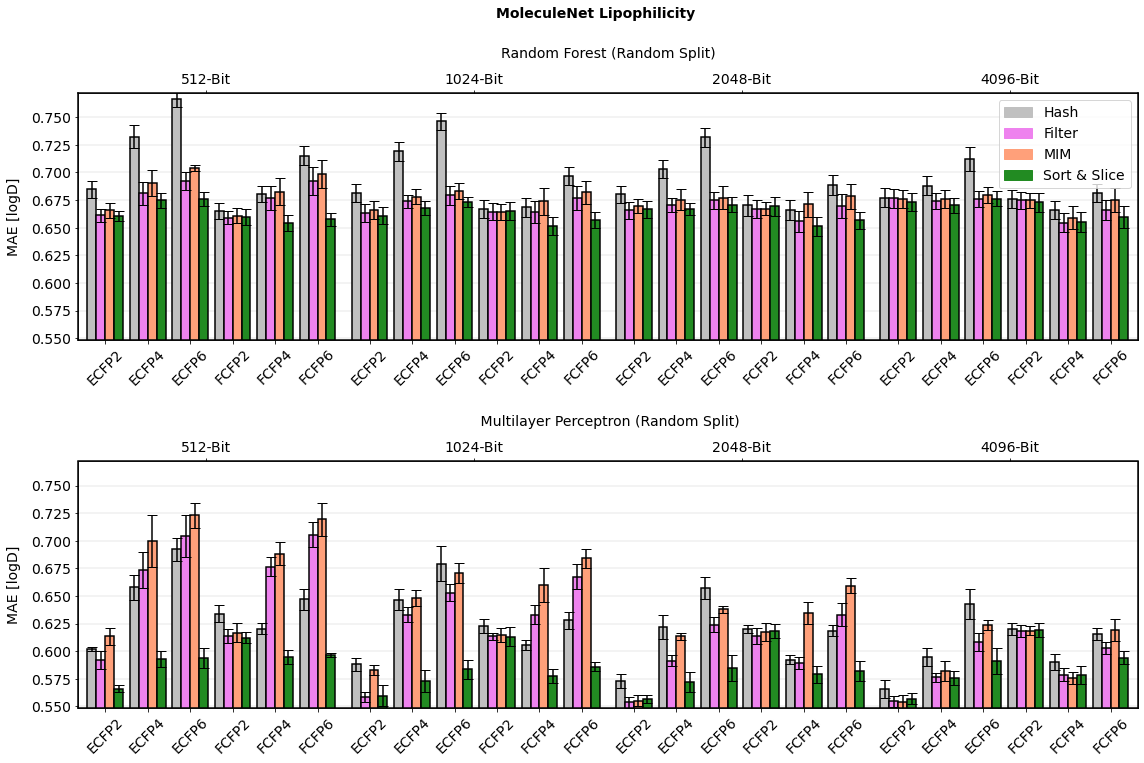

In [4]:
visualise_bar_charts(dataset_name = "moleculenet_lipophilicity", # specify dataset name
                     split_type = "rand", # specify split type "rand" or "scaff" (for random or scaffold split)
                     metric = "MAE", # specify performance metric
                     y_unit = " [logD]") # specify unit for y-axis (if applicable)

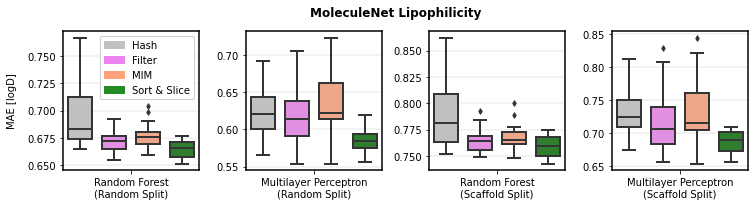

In [5]:
visualise_box_plots(dataset_name = "moleculenet_lipophilicity", # specify dataset name
                    metric = "MAE", # specify performance metric
                    y_unit = " [logD]", # specify unit for y-axis if applicable
                    show_legend = True, # show legend or not
                    show_x_ticks = True) # show text below subplots or not